# Import librairies

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# lazy 
from lazypredict.Supervised import LazyClassifier
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin

# search hyperparameters
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# modèles 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from sklearn.svm import LinearSVC

import xgboost as xgb
import shap

# métriques 
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import classification_report,accuracy_score, f1_score, fbeta_score,  average_precision_score
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, precision_recall_curve

# Rééchantillonage
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import EditedNearestNeighbours

from imblearn.under_sampling import RandomUnderSampler

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# sauvegarde model
import pickle
import itertools
import os

# import des fonctions de modélisations
import  modeling_functions as mf

# Chargement données issues du preprocessing

In [51]:

# jeu de données issues du preprocessing mixte
df_V1 = pd.read_csv("../data_saved/df_final.csv", index_col=["id_Location","id_Date"])

# jeu de données issues du preprocessing successif
df_V2 =  pd.read_csv("../data_saved/data_preprocessed_V2.csv", index_col=["id_Location","id_Date"])

missing_percentages = df_V2.isna().mean()
threshold = 0.25
# Colonnes à conserver
columns_to_keep = missing_percentages[missing_percentages <= threshold].index
columns_dropped = missing_percentages[missing_percentages > threshold].index
df_V2 = df_V2[columns_to_keep]
print("Colonnes supprimées sur le df V2 :", columns_dropped)

print(missing_percentages.loc["Evaporation"])

# jeu de données avec des variables lags et en variation additionnelles
df_V3 =  pd.read_csv("../data_saved/data_preprocessed_V3.csv", index_col=["id_Location","id_Date"])

missing_percentages = df_V3.isna().mean()
threshold = 0.25
# Colonnes à conserver
columns_to_keep = missing_percentages[missing_percentages <= threshold].index
columns_dropped = missing_percentages[missing_percentages > threshold].index
df_V3 = df_V3[columns_to_keep]
print("Colonnes supprimées sur le df V3:", columns_dropped)


print("dimensions V1 :", df_V1.shape)
print("dimensions V2 :", df_V2.shape)
print("dimensions V3 :", df_V3.shape)

print("dimensions V1 sans Nas :", df_V1.dropna().shape)
print("dimensions V2 sans Nas:", df_V2.dropna().shape)
print("dimensions V3 sans Nas:", df_V3.dropna().shape)


Colonnes supprimées sur le df V2 : Index(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], dtype='object')
0.27965511663724657
Colonnes supprimées sur le df V3: Index(['Evaporation_mean3j', 'Sunshine_mean3j', 'Cloud_delta'], dtype='object')
dimensions V1 : (135600, 42)
dimensions V2 : (142193, 94)
dimensions V3 : (142193, 83)
dimensions V1 sans Nas : (135600, 42)
dimensions V2 sans Nas: (136222, 94)
dimensions V3 sans Nas: (123585, 83)


# Vérification multicolinéarité


In [52]:
#vif_V1 = mf.check_vif(df_V1.dropna())
remove_cols = ["MinTemp","MaxTemp",'WindSpeed3pm','Humidity3pm', 
               'Pressure3pm','Temp3pm',
               'Season_cos',"Season_sin",
               'WindGustSpeed']


df_V1_clean = df_V1.drop(columns = remove_cols)
#vif_V1_clean = mf.check_vif(df_V1_clean.dropna())

In [53]:
#vif_V2 = mf.check_vif(df_V2.dropna())
remove_cols = ["MinTemp","MaxTemp",'WindSpeed3pm','Humidity3pm', 
                'Pressure3pm','Temp3pm',
                'Season_cos',"Season_sin",
                'WindGustSpeed']


df_V2_clean = df_V2.drop(columns = remove_cols)
#vif_V2_clean = mf.check_vif(df_V2_clean.dropna())

In [54]:
#vif_V3 = mf.check_vif(df_V3.dropna())
#sns.heatmap(df_V3.iloc[:,-20:-1].corr(), cmap='RdBu')

df_V3_clean = df_V3.drop(columns = ["WindGustSpeed","MaxTemp_mean3j"])
#vif_V3_clean = mf.check_vif(df_V3_clean.dropna())

# Séparation en train et test 

In [55]:
# Version classique (random sur 20% des données)

X_train_V1, X_test_V1, y_train_V1, y_test_V1 = \
    mf.separation_train_test(df_V1, sep_method="classique", split = 0.8)
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = \
    mf.separation_train_test(df_V2, sep_method="classique", split = 0.8)
X_train_V3, X_test_V3, y_train_V3, y_test_V3 = \
    mf.separation_train_test(df_V3, sep_method="classique", split = 0.8)



In [56]:
# Version temporelle  : 
# train = premières années représentant environ 80 % des données
# test = années restantes

X_train_V1t, X_test_V1t, y_train_V1t, y_test_V1t = \
    mf.separation_train_test(df_V1, sep_method="temporelle", split = 0.8)
X_train_V2t, X_test_V2t, y_train_V2t, y_test_V2t = \
    mf.separation_train_test(df_V2, sep_method="temporelle", split = 0.8)
X_train_V3t, X_test_V3t, y_train_V3t, y_test_V3t = \
    mf.separation_train_test(df_V3, sep_method="temporelle", split = 0.8)

In [57]:
# Check les dimensions train et test

print(X_train_V1t.shape)
print(X_test_V1t.shape)
print(X_train_V2t.shape)
print(X_test_V2t.shape)
print(X_train_V3t.shape)
print(X_test_V3t.shape)



(94452, 39)
(41148, 39)
(94809, 92)
(41413, 92)
(85659, 82)
(37926, 82)


# Scaling

In [58]:
X_train_V1_scaled, X_test_V1_scaled = mf.scaling(X_train_V1, X_test_V1, scaler = MinMaxScaler())
X_train_V2_scaled, X_test_V2_scaled = mf.scaling(X_train_V2, X_test_V2, scaler = MinMaxScaler())
X_train_V3_scaled, X_test_V3_scaled = mf.scaling(X_train_V3, X_test_V3, scaler = MinMaxScaler())

X_train_V1t_scaled, X_test_V1t_scaled = mf.scaling(X_train_V1t, X_test_V1t, scaler = MinMaxScaler())
X_train_V2t_scaled, X_test_V2t_scaled = mf.scaling(X_train_V2t, X_test_V2t, scaler = MinMaxScaler())
X_train_V3t_scaled, X_test_V3t_scaled = mf.scaling(X_train_V3t, X_test_V3t, scaler = MinMaxScaler())


In [66]:

print(y_test_V3t)

print(X_test_V3t.loc[("Adelaide"),].tail(10))

print(y_test_V3t.loc[("Adelaide", '2017-06-22'),])



id_Location  id_Date   
Albury       2015-01-01   0.00
             2015-01-02   0.00
             2015-01-03   0.00
             2015-01-04   0.00
             2015-01-05   0.00
                          ... 
Uluru        2017-06-20   0.00
             2017-06-21   0.00
             2017-06-22   0.00
             2017-06-23   0.00
             2017-06-24   0.00
Name: RainTomorrow, Length: 37926, dtype: float64
            Rainfall  WindGustSpeed  RainToday  Month_cos  Month_sin  \
id_Date                                                                
2017-06-01      0.00          17.00       0.00      -1.00       0.00   
2017-06-02      0.00          20.00       0.00      -1.00       0.00   
2017-06-06      0.00          24.00       0.00      -1.00       0.00   
2017-06-07      0.00          19.00       0.00      -1.00       0.00   
2017-06-08      0.00          22.00       0.00      -1.00       0.00   
2017-06-12      0.00          19.00       0.00      -1.00       0.00   
2017-06-1

KeyError: ('Adelaide', '2017-06-22')

<Figure size 1000x1000 with 0 Axes>

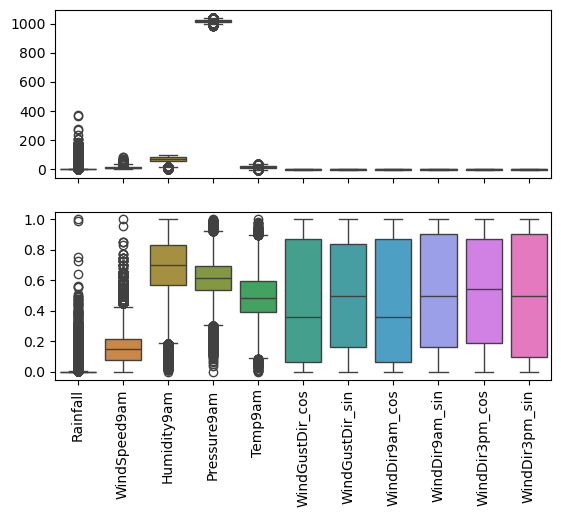

In [7]:
columns_check_scaling = [
                         'Rainfall', 
                         'WindSpeed9am', 'Humidity9am',
                         'Pressure9am',  'Temp9am',  
       'WindGustDir_cos', 'WindGustDir_sin', 'WindDir9am_cos',
       'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin']
       
plt.figure(figsize = (10,10))
plt.subplots(ncols=1, nrows=2, sharex = True)
plt.subplot(211)
sns.boxplot(X_train_V2t.loc[:,columns_check_scaling ])
plt.xticks(rotation=90)
plt.subplot(212)
sns.boxplot(X_train_V2t_scaled.loc[:,columns_check_scaling ])
plt.xticks(rotation=90)
plt.show()


<Figure size 1000x3000 with 0 Axes>

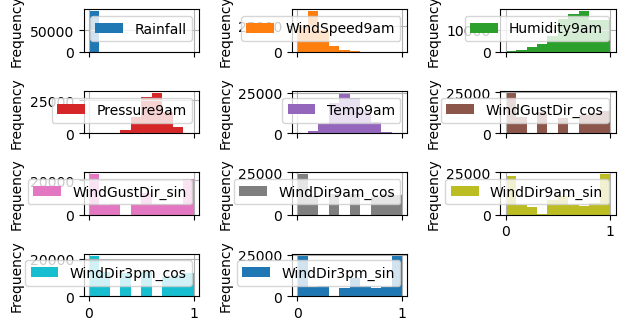

In [8]:
# check distribution après scaling

plt.figure(figsize = (10,30))
X_train_V2t_scaled.loc[:,columns_check_scaling ].\
    plot.hist(subplots = True, grid = True, layout=(6,3))

plt.tight_layout()
plt.show()



# Lazy predict 

In [58]:

removed_classifiers = [
"ClassifierChain",
"ComplementNB",
"GradientBoostingClassifier",
"GaussianProcessClassifier",
"HistGradientBoostingClassifier",
"MLPClassifier",
"LogisticRegressionCV",
"MultiOutputClassifier",
"MultinomialNB",
"OneVsOneClassifier",
"OneVsRestClassifier",
"OutputCodeClassifier",
"RadiusNeighborsClassifier",
"VotingClassifier",
'SVC','LabelPropagation','LabelSpreading','NuSV']


In [59]:
# warning, assez long (1-2 min par jeu de données)

print("Lazy predict, données V1")

models_V1t, predictions_V1t = mf.lazy_results(X_train_V1t_scaled, X_test_V1t_scaled, y_train_V1t, y_test_V1t)

print("Lazy predict, données V2")

models_V2t, predictions_V2t = mf.lazy_results(X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t)

print("Lazy predict, données V3")
models_V3t, predictions_V3t = mf.lazy_results(X_train_V3t_scaled, X_test_V3t_scaled, y_train_V3t, y_test_V3t)

models_V1t.to_csv("../modeling_results/lazy_predict_mixtepreprocessing_temp.csv",  decimal = ",")
models_V2t.to_csv("../modeling_results/lazy_predict_succereprocessing_temp.csv",  decimal = ",")
models_V3t.to_csv("../modeling_results/lazy_predict_V3process_temp.csv",  decimal = ",")




Lazy predict, données V1
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [01:00<00:00,  2.32s/it]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.85               0.72     0.72      0.84   
ExtraTreesClassifier               0.85               0.71     0.71      0.84   
LinearDiscriminantAnalysis         0.84               0.72     0.72      0.83   
LogisticRegression                 0.84               0.72     0.72      0.83   
CalibratedClassifierCV             0.84               0.71     0.71      0.83   
BaggingClassifier                  0.84               0.71     0.71      0.83   
LinearSVC                          0.84               0.71     0.71      0.83   
AdaBoostClassifier                 0.84               0.71     0.71      0.83   
SGDClassifier                      0.84               0.71     0.71      0.83   
RidgeClassifier                    0.84               0.70     0.70      0.83   
RidgeClassifierCV                  0.84               0.70     0.70      0.83   
KNeighborsClassifier               0.83               0.69     0.69      0.81   
PassiveAggressiveClassifier        0.80               0.72     0.72      0.80   
GaussianNB                         0.80               0.72     0.72      0.80   
Perceptron                         0.80               0.70     0.70      0.80   
DecisionTreeClassifier             0.79               0.69     0.69      0.79   
NearestCentroid                    0.77               0.74     0.74      0.79   
ExtraTreeClassifier                0.77               0.66     0.66      0.77   
BernoulliNB                        0.75               0.72     0.72      0.76   
DummyClassifier                    0.78               0.50     0.50      0.69   
QuadraticDiscriminantAnalysis      0.22               0.50     0.50      0.08   

                               Time Taken  
Model                                      
RandomForestClassifier              18.39  
ExtraTreesClassifier                12.45  
LinearDiscriminantAnalysis           0.49  
LogisticRegression                   0.36  
CalibratedClassifierCV               2.75  
BaggingClassifier                    9.98  
LinearSVC                            0.80  
AdaBoostClassifier                   5.59  
SGDClassifier                        0.53  
RidgeClassifier                      0.25  
RidgeClassifierCV                    0.47  
KNeighborsClassifier                 3.89  
PassiveAggressiveClassifier          0.34  
GaussianNB                           0.26  
Perceptron                           0.38  
DecisionTreeClassifier               1.62  
NearestCentroid                      0.21  
ExtraTreeClassifier                  0.31  
BernoulliNB                          0.25  
DummyClassifier                      0.19  
QuadraticDiscriminantAnalysis        0.47

Lazy predict, données V2
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [01:27<00:00,  3.36s/it]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.85               0.72     0.72      0.84   
LogisticRegression                 0.85               0.72     0.72      0.84   
LinearDiscriminantAnalysis         0.85               0.72     0.72      0.84   
ExtraTreesClassifier               0.85               0.71     0.71      0.83   
LinearSVC                          0.85               0.71     0.71      0.83   
SGDClassifier                      0.84               0.71     0.71      0.83   
BaggingClassifier                  0.84               0.71     0.71      0.83   
RidgeClassifier                    0.85               0.70     0.70      0.83   
RidgeClassifierCV                  0.85               0.70     0.70      0.83   
AdaBoostClassifier                 0.84               0.71     0.71      0.83   
KNeighborsClassifier               0.82               0.67     0.67      0.81   
Perceptron                         0.81               0.70     0.70      0.80   
PassiveAggressiveClassifier        0.81               0.69     0.69      0.80   
DecisionTreeClassifier             0.79               0.70     0.70      0.79   
NearestCentroid                    0.77               0.73     0.73      0.78   
ExtraTreeClassifier                0.77               0.65     0.65      0.77   
BernoulliNB                        0.74               0.71     0.71      0.75   
CalibratedClassifierCV             0.80               0.54     0.54      0.72   
DummyClassifier                    0.78               0.50     0.50      0.68   
GaussianNB                         0.61               0.64     0.64      0.64   
QuadraticDiscriminantAnalysis      0.45               0.51     0.51      0.49   

                               Time Taken  
Model                                      
RandomForestClassifier              19.24  
LogisticRegression                   0.67  
LinearDiscriminantAnalysis           1.10  
ExtraTreesClassifier                16.19  
LinearSVC                            2.10  
SGDClassifier                        1.45  
BaggingClassifier                   15.52  
RidgeClassifier                      0.51  
RidgeClassifierCV                    1.13  
AdaBoostClassifier                   8.31  
KNeighborsClassifier                 4.64  
Perceptron                           0.65  
PassiveAggressiveClassifier          0.73  
DecisionTreeClassifier               2.68  
NearestCentroid                      0.43  
ExtraTreeClassifier                  0.60  
BernoulliNB                          0.49  
CalibratedClassifierCV               8.52  
DummyClassifier                      0.39  
GaussianNB                           0.53  
QuadraticDiscriminantAnalysis        0.95

Lazy predict, données V3
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [01:12<00:00,  2.80s/it]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.83               0.68     0.68      0.82   
AdaBoostClassifier                 0.83               0.67     0.67      0.81   
BaggingClassifier                  0.82               0.67     0.67      0.80   
ExtraTreesClassifier               0.83               0.65     0.65      0.80   
LinearDiscriminantAnalysis         0.81               0.65     0.65      0.79   
SGDClassifier                      0.81               0.65     0.65      0.79   
LogisticRegression                 0.82               0.64     0.64      0.79   
KNeighborsClassifier               0.81               0.64     0.64      0.79   
LinearSVC                          0.82               0.63     0.63      0.78   
RidgeClassifierCV                  0.81               0.62     0.62      0.78   
RidgeClassifier                    0.81               0.62     0.62      0.78   
DecisionTreeClassifier             0.76               0.66     0.66      0.76   
NearestCentroid                    0.75               0.70     0.70      0.76   
ExtraTreeClassifier                0.74               0.62     0.62      0.74   
PassiveAggressiveClassifier        0.72               0.65     0.65      0.73   
BernoulliNB                        0.71               0.69     0.69      0.73   
Perceptron                         0.74               0.58     0.58      0.73   
CalibratedClassifierCV             0.78               0.50     0.50      0.69   
DummyClassifier                    0.78               0.50     0.50      0.68   
GaussianNB                         0.59               0.62     0.62      0.62   
QuadraticDiscriminantAnalysis      0.45               0.51     0.51      0.49   

                               Time Taken  
Model                                      
RandomForestClassifier              17.98  
AdaBoostClassifier                   6.57  
BaggingClassifier                   12.54  
ExtraTreesClassifier                14.31  
LinearDiscriminantAnalysis           0.95  
SGDClassifier                        1.42  
LogisticRegression                   0.41  
KNeighborsClassifier                 3.89  
LinearSVC                            0.94  
RidgeClassifierCV                    1.00  
RidgeClassifier                      0.41  
DecisionTreeClassifier               2.10  
NearestCentroid                      0.34  
ExtraTreeClassifier                  0.45  
PassiveAggressiveClassifier          0.47  
BernoulliNB                          0.39  
Perceptron                           0.44  
CalibratedClassifierCV               6.27  
DummyClassifier                      0.30  
GaussianNB                           0.43  
QuadraticDiscriminantAnalysis        0.72

In [60]:
# Comparaison entre méthode classique et temporelle pour séparer les données 
# sur un modèle basique

models_select  = {
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
}

mf.fit_models(models_select, 
        X_train_V2_scaled, X_test_V2_scaled, y_train_V2, y_test_V2, 
        save_model = False, save_results=False)
mf.fit_models(models_select, 
        X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t, 
        save_model = False, save_results=False)

# Bilan, assez peu d'impacts

Fitting  RandomForestClassifier


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.88    0.96      0.92 21144.00
1.0                0.80    0.53      0.64  6101.00
accuracy           0.87    0.87      0.87     0.87
macro avg          0.84    0.75      0.78 27245.00
weighted avg       0.86    0.87      0.85 27245.00
Matrice de confusion :
       0.00  1.00
0.00  20358   786
1.00   2879  3222
Fitting  RandomForestClassifier


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.78    0.48      0.60  9178.00
accuracy           0.86    0.86      0.86     0.86
macro avg          0.82    0.72      0.75 41413.00
weighted avg       0.85    0.86      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30989  1246
1.00   4757  4421


({'RandomForestClassifier':               precision  recall  f1-score  support
  0.0                0.87    0.96      0.91 32235.00
  1.0                0.78    0.48      0.60  9178.00
  accuracy           0.86    0.86      0.86     0.86
  macro avg          0.82    0.72      0.75 41413.00
  weighted avg       0.85    0.86      0.84 41413.00},
 {'RandomForestClassifier':        0.00  1.00
  0.00  30989  1246
  1.00   4757  4421},
 {'RandomForestClassifier': RandomForestClassifier(n_jobs=-1)})

# Fit modèles simples 

In [61]:
# Choix de 3 modèles 
models_select  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BaggingClassifier': BaggingClassifier(n_estimators = 500, max_samples = 0.5,
                                           max_features = 0.5, n_jobs=-1),
    'LinearSVC'   : LinearSVC()                                    
}


In [62]:
# Test sur données preprocessed V1

report_V1t, cm_V1t, models_V1t = \
    mf.fit_models(
        models_select, 
        X_train_V1t_scaled, X_test_V1t_scaled, y_train_V1t, y_test_V1t, 
        save_model = True, save_models_dir="base_V1t_",
        save_results=True,save_results_dir="Base/base_V1t_")


Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.90      0.89 32167.00
1.0                0.63    0.61      0.62  8981.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.76    0.75      0.76 41148.00
weighted avg       0.83    0.84      0.83 41148.00
Matrice de confusion :
       0.00  1.00
0.00  28878  3289
1.00   3490  5491


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.95      0.91 32167.00
1.0                0.75    0.49      0.59  8981.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.81    0.72      0.75 41148.00
weighted avg       0.84    0.85      0.84 41148.00
Matrice de confusion :
       0.00  1.00
0.00  30719  1448
1.00   4622 

In [63]:
# Test sur données preprocessed V2

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select, 
               X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
               save_model = True, save_models_dir="base_V2t_",
               save_results=True,save_results_dir="Base/base_V2t_")



Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.91      0.90 32235.00
1.0                0.66    0.59      0.62  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.75      0.76 41413.00
weighted avg       0.84    0.84      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  29489  2746
1.00   3772  5406


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.77    0.48      0.60  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.75 41413.00
weighted avg       0.85    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30937  1298
1.00   4733 

In [64]:
# Test sur données preprocessed V3

report_V3t, cm_V3t, models_V3t = \
    mf.fit_models(models_select, 
               X_train_V3t_scaled, X_test_V3t_scaled, y_train_V3t, y_test_V3t,
               save_model = True, save_models_dir="base_V3t_",
               save_results=True,save_results_dir="Base/base_V3t_")


Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.84    0.95      0.89 29559.00
1.0                0.65    0.35      0.45  8367.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.74    0.65      0.67 37926.00
weighted avg       0.80    0.81      0.79 37926.00
Matrice de confusion :
       0.00  1.00
0.00  27981  1578
1.00   5439  2928


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.85    0.96      0.90 29559.00
1.0                0.72    0.40      0.51  8367.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.79    0.68      0.71 37926.00
weighted avg       0.82    0.83      0.81 37926.00
Matrice de confusion :
       0.00  1.00
0.00  28263  1296
1.00   5019 

   Dataset              model_name   Métrique value
0       V1      LogisticRegression     recall  0.61
1       V1  RandomForestClassifier     recall  0.49
2       V1       BaggingClassifier     recall  0.43
3       V1               LinearSVC     recall  0.62
4       V2      LogisticRegression     recall  0.59
5       V2  RandomForestClassifier     recall  0.48
6       V2       BaggingClassifier     recall  0.45
7       V2               LinearSVC     recall  0.58
8       V3      LogisticRegression     recall  0.35
9       V3  RandomForestClassifier     recall  0.40
10      V3       BaggingClassifier     recall  0.32
11      V3               LinearSVC     recall  0.24
12      V1      LogisticRegression  precision  0.63
13      V1  RandomForestClassifier  precision  0.75
14      V1       BaggingClassifier  precision  0.78
15      V1               LinearSVC  precision  0.62
16      V2      LogisticRegression  precision  0.66
17      V2  RandomForestClassifier  precision  0.77
18      V2  

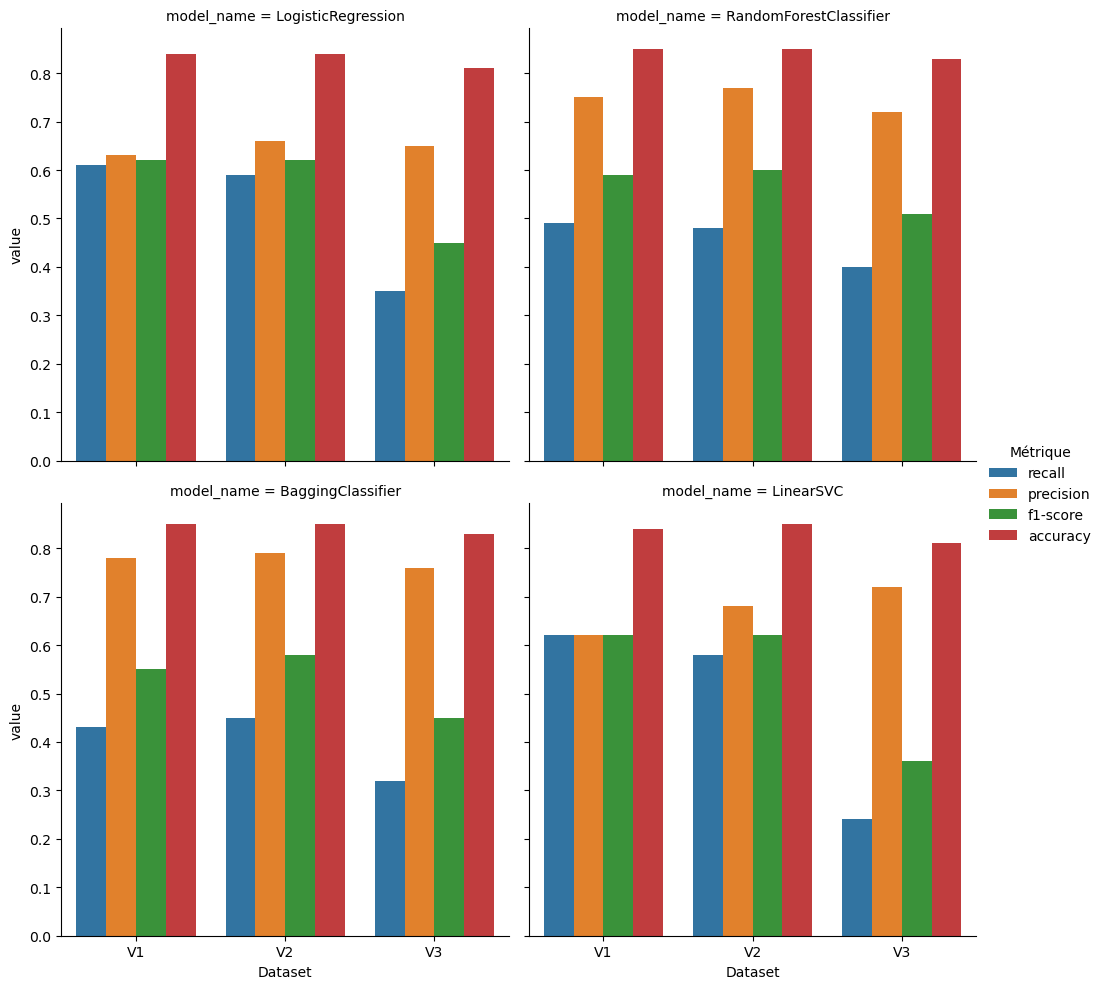

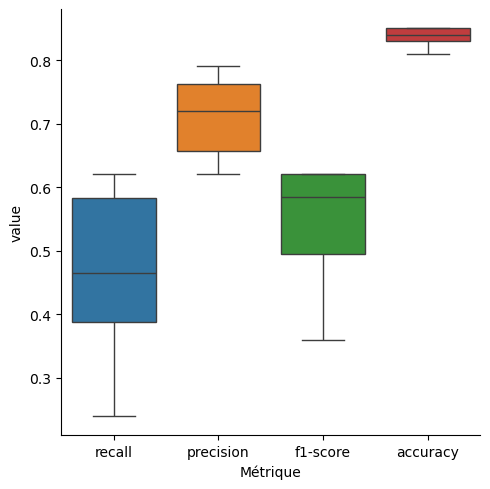

In [65]:
# Comparaison des preprocessing 

model_list = list(models_select.keys())
data_list = ['V1',"V2","V3"]
metrics_list = ["recall","precision","f1-score"]
class_label = "1.0"
index_results = list(itertools.product(data_list, model_list))
index_results = pd.MultiIndex.from_tuples(index_results , 
                                          names=["Dataset", "model_name"])

table_comp_preprocess = pd.DataFrame(index = 
                                     index_results, 
                                     columns=[metrics_list] )

table_comp_preprocess["accuracy"]=""

for model_name in model_list:
    table_comp_preprocess.loc[("V1",model_name),"accuracy"] = \
                report_V1t[model_name].loc["accuracy","precision"]
    
    table_comp_preprocess.loc[("V2",model_name),"accuracy"] = \
                report_V2t[model_name].loc["accuracy","precision"]
    
    table_comp_preprocess.loc[("V3",model_name),"accuracy"] = \
                report_V3t[model_name].loc["accuracy","precision"]
    
    for m in metrics_list:
        table_comp_preprocess.loc[("V1",model_name),m] = \
                report_V1t[model_name].loc[class_label,m]
        table_comp_preprocess.loc[("V2",model_name),m] = \
                report_V2t[model_name].loc[class_label,m]
        table_comp_preprocess.loc[("V3",model_name),m] = \
                report_V3t[model_name].loc[class_label,m]
        

table_comp_preprocess = table_comp_preprocess.reset_index()
table_comp_preprocess.columns = ["Dataset","model_name", "recall","precision","f1-score","accuracy"]

table_comp_preprocess = pd.melt(
    table_comp_preprocess,
        id_vars=["Dataset","model_name"],
        value_vars=["recall","precision","f1-score","accuracy"],
        var_name="Métrique")

print(table_comp_preprocess)


sns.catplot(data = table_comp_preprocess, x = "Dataset", y="value", 
            hue = "Métrique", col = "model_name", kind = "bar",
            col_wrap=2)

plt.savefig("../plots/rapport/comparaison_preprocessing.png")

sns.catplot(data = table_comp_preprocess, x = "Métrique", y="value", 
            hue = "Métrique", kind = "box")

plt.savefig("../plots/rapport/comparaison_metriques_simple.png")


# Rééchantillonage

## Comparaisons des méthodes de sampling

In [66]:
# Test des méthodes de sampling et comparaison

samplerlist = {
    "RandomUnderSampling" : RandomUnderSampler(),
    "NearMiss" : NearMiss(sampling_strategy="not minority"),
    "TomekLinks" : TomekLinks(sampling_strategy='majority'),
    "ClusterCentroids" : ClusterCentroids(sampling_strategy="auto"), 
    "EditedNearestNeighbours" : EditedNearestNeighbours(sampling_strategy="majority"), 
    "SMOTE" : SMOTE(sampling_strategy='minority') , 
    "SMOTETomek()" : SMOTETomek(sampling_strategy='auto')}

report_V2t = dict()
cm_V2t = dict()

for sampler_name, sampler in samplerlist.items():
    print("Sampler = ", sampler_name)
    # undersampling et fit sur données preprocessed V2
    X_train_rs_V2t, y_train_rs_V2t = mf.resample(X_train_V2t,  y_train_V2t, resampler = sampler)
    X_train_rs_V2t, X_test_V2t_scaled = mf.scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)
 
    report_V2t[sampler_name], cm_V2t[sampler_name], models_V2t = \
        mf.fit_models(models_select, 
                    X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t,
                    save_model = True, save_models_dir= sampler_name +"_V2t_",
                    save_results=True, save_results_dir="Resample/" + sampler_name +"_V2t_")




Sampler =  RandomUnderSampling
Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon rééchantillonné : {0.0: 21325, 1.0: 21325}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.93    0.75      0.83 32235.00
1.0                0.48    0.80      0.60  9178.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.70    0.78      0.71 41413.00
weighted avg       0.83    0.76      0.78 41413.00
Matrice de confusion :
       0.00  1.00
0.00  24126  8109
1.00   1815  7363


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 32235.00
1.0                0.54    0.76      0.63  9178.00
accuracy           0.80    0.80      0.80     0.80
macro avg          0.73 

                 Sampler              model_name  Métrique value
0    RandomUnderSampling      LogisticRegression    recall  0.80
1    RandomUnderSampling  RandomForestClassifier    recall  0.76
2    RandomUnderSampling       BaggingClassifier    recall  0.76
3    RandomUnderSampling               LinearSVC    recall  0.81
4               NearMiss      LogisticRegression    recall  0.74
..                   ...                     ...       ...   ...
107                SMOTE               LinearSVC  accuracy  0.22
108         SMOTETomek()      LogisticRegression  accuracy  0.22
109         SMOTETomek()  RandomForestClassifier  accuracy  0.84
110         SMOTETomek()       BaggingClassifier  accuracy  0.85
111         SMOTETomek()               LinearSVC  accuracy  0.22

[112 rows x 4 columns]


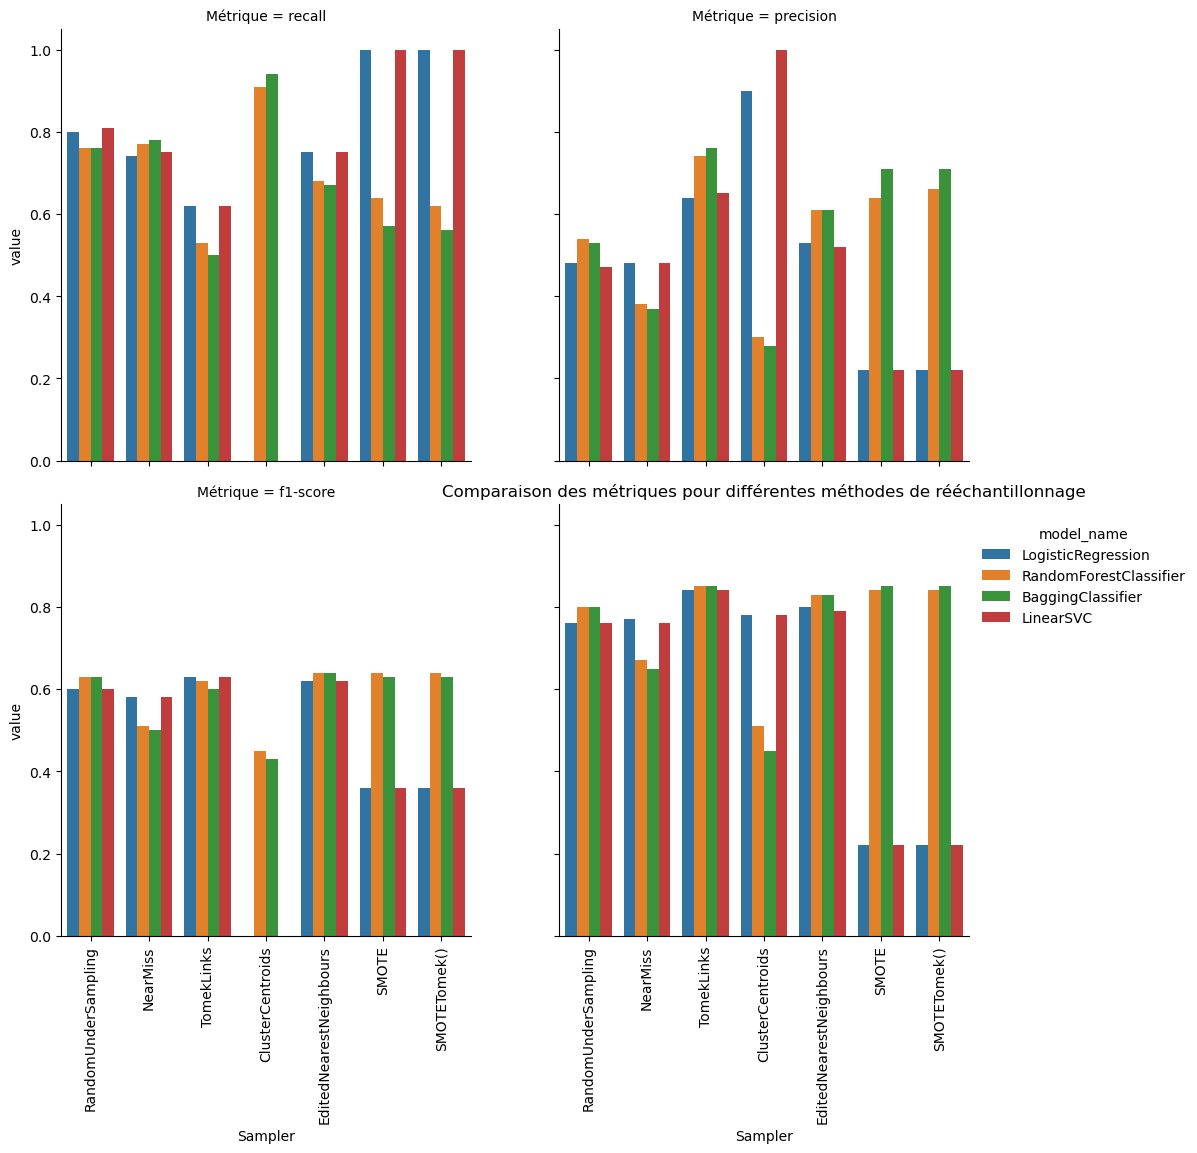

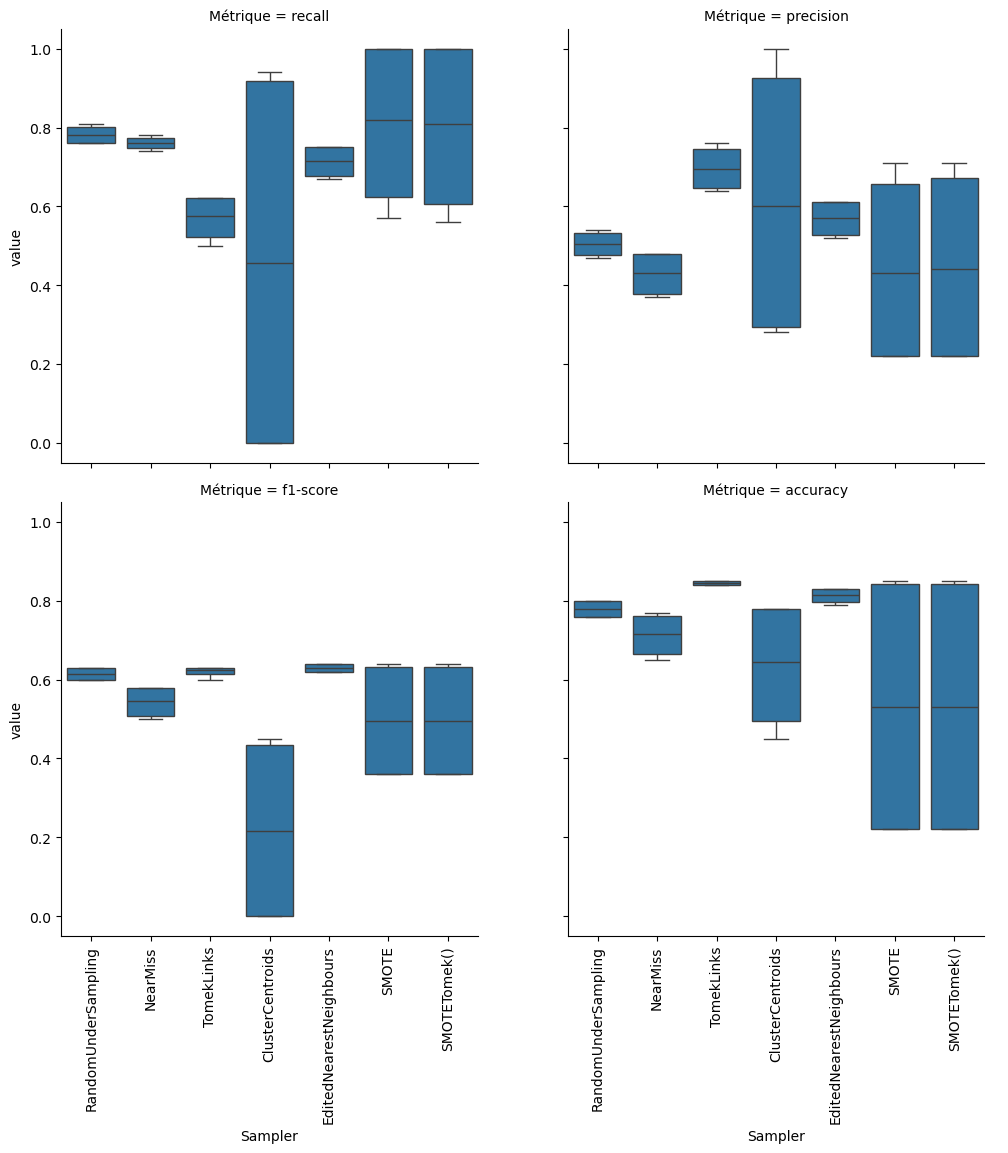

In [67]:
# comparaison des samplers 
model_list = list(models_select.keys())
metrics_list = ["recall","precision","f1-score"]
sampler_names = samplerlist .keys()
class_label = "1.0"
index_results = list(itertools.product(sampler_names, model_list))
index_results = pd.MultiIndex.from_tuples(index_results , 
                                          names=["Sampler", "model_name"])

table_comp_sampling = pd.DataFrame(index = 
                                     index_results, 
                                     columns=[metrics_list] )

table_comp_sampling["accuracy"]=""

for model_name in model_list:
    for sampler_name in  sampler_names:

        table_comp_sampling.loc[(sampler_name,model_name),"accuracy"] = \
                        report_V2t[sampler_name][model_name].loc["accuracy","precision"]
    
        for m in metrics_list:
                table_comp_sampling.loc[(sampler_name,model_name),m] = \
                        report_V2t[sampler_name][model_name].loc[class_label,m]
        

table_comp_sampling = table_comp_sampling.reset_index()
table_comp_sampling.columns = ["Sampler","model_name", "recall","precision","f1-score","accuracy"]

table_comp_sampling  = pd.melt(
    table_comp_sampling ,
        id_vars=["Sampler","model_name"],
        value_vars=["recall","precision","f1-score","accuracy"],
        var_name="Métrique")

print(table_comp_sampling )


plot = sns.catplot(data = table_comp_sampling , x = "Sampler", y="value", 
            hue = "model_name", col =  "Métrique", kind = "bar",
            col_wrap=2)

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    
plt.title("Comparaison des métriques pour différentes méthodes de rééchantillonnage")
plt.savefig("../plots/rapport/comparaison_sampling.png",  bbox_inches = 'tight')


plot = sns.catplot(data = table_comp_sampling , x = "Sampler", y="value", 
            col =  "Métrique", kind = "box",
            col_wrap=2)

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig("../plots/rapport/comparaison_sampling2.png",  bbox_inches = 'tight')


## Comparaison avec sous sans rééchantillonage

In [68]:
# Comparaison avec sous sans rééchantillonage

samplerlist = {
    "TomekLinks" : TomekLinks(sampling_strategy='majority'),
    "EditedNearestNeighbours" : EditedNearestNeighbours(sampling_strategy="majority")}

report_V2t = dict()
cm_V2t = dict()

report_V2t["Pas de sampling"], cm_V2t["Pas de sampling"], models_V2t = \
        mf.fit_models(models_select, 
                    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
                    save_model = False, save_models_dir= "Pas de sampling" +"_V2t_",
                    save_results=False, save_results_dir="Resample/" + "Pas de sampling" +"_V2t_")




for sampler_name, sampler in samplerlist.items():
    print("Sampler = ", sampler_name)
    # undersampling et fit sur données preprocessed V2
    X_train_rs_V2t, y_train_rs_V2t = mf.resample(X_train_V2t,  y_train_V2t, resampler = sampler)
    X_train_rs_V2t, X_test_V2t_scaled = mf.scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)
 
    report_V2t[sampler_name], cm_V2t[sampler_name], models_V2t_rs = \
        mf.fit_models(models_select, 
                    X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t,
                    save_model = True, save_models_dir= sampler_name +"_V2t_",
                    save_results=True, save_results_dir="Resample/" + sampler_name +"_V2t_")




Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.91      0.90 32235.00
1.0                0.66    0.59      0.62  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.75      0.76 41413.00
weighted avg       0.84    0.84      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  29489  2746
1.00   3772  5406


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.77    0.48      0.59  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.75 41413.00
weighted avg       0.84    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30954  1281
1.00   4813 

                    Sampler              model_name   Métrique value
0                TomekLinks      LogisticRegression     recall  0.62
1                TomekLinks  RandomForestClassifier     recall  0.53
2                TomekLinks       BaggingClassifier     recall  0.50
3                TomekLinks               LinearSVC     recall  0.62
4   EditedNearestNeighbours      LogisticRegression     recall  0.75
5   EditedNearestNeighbours  RandomForestClassifier     recall  0.68
6   EditedNearestNeighbours       BaggingClassifier     recall  0.67
7   EditedNearestNeighbours               LinearSVC     recall  0.75
8           Pas de sampling      LogisticRegression     recall  0.59
9           Pas de sampling  RandomForestClassifier     recall  0.48
10          Pas de sampling       BaggingClassifier     recall  0.45
11          Pas de sampling               LinearSVC     recall  0.58
12               TomekLinks      LogisticRegression  precision  0.64
13               TomekLinks  Rando

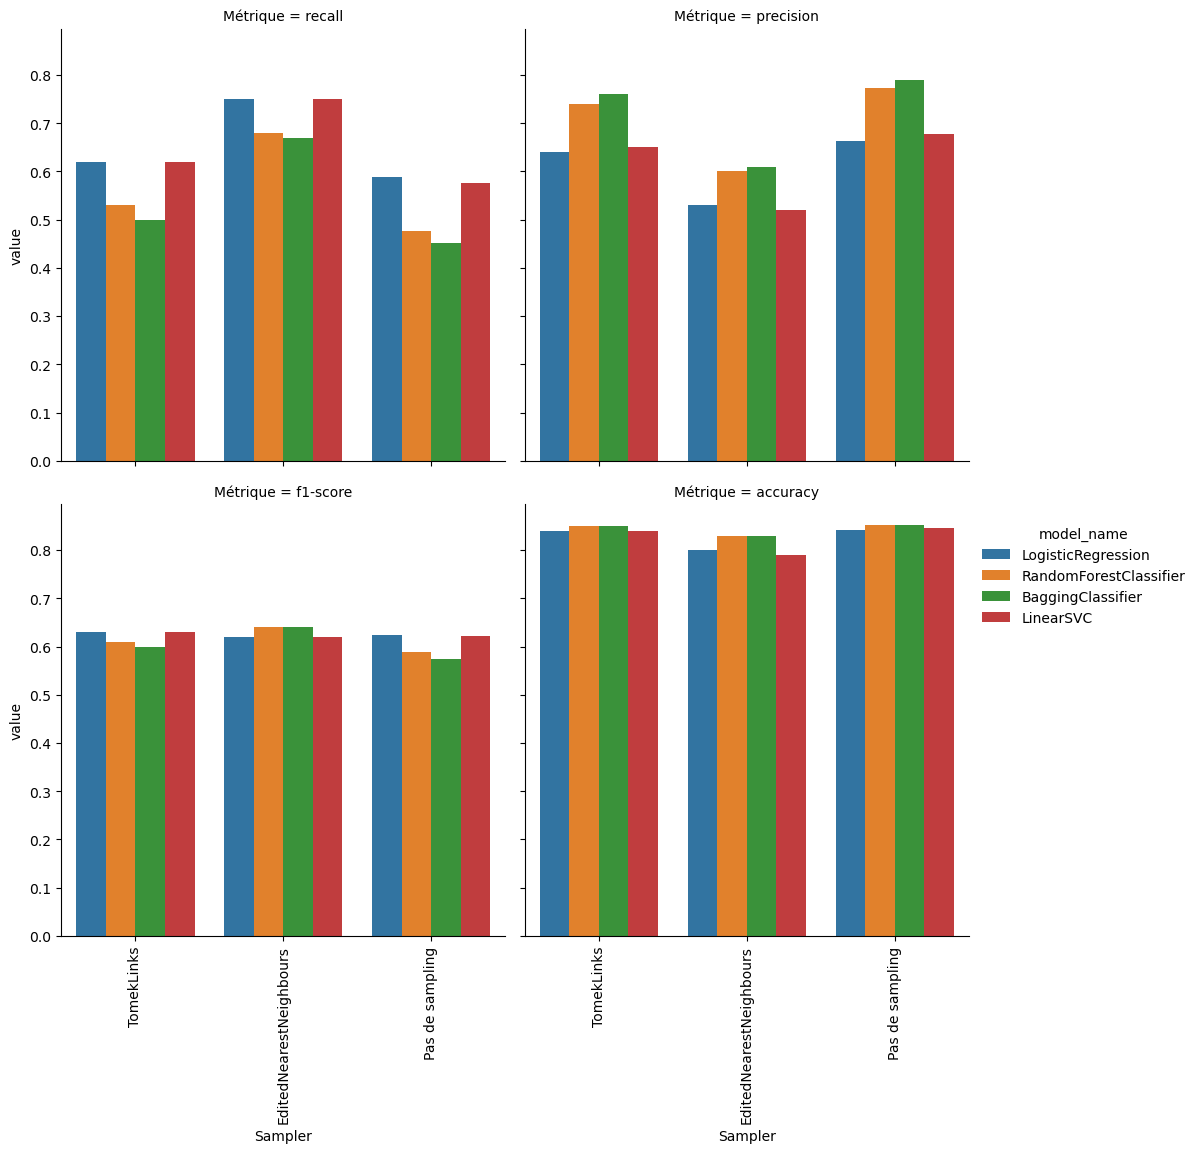

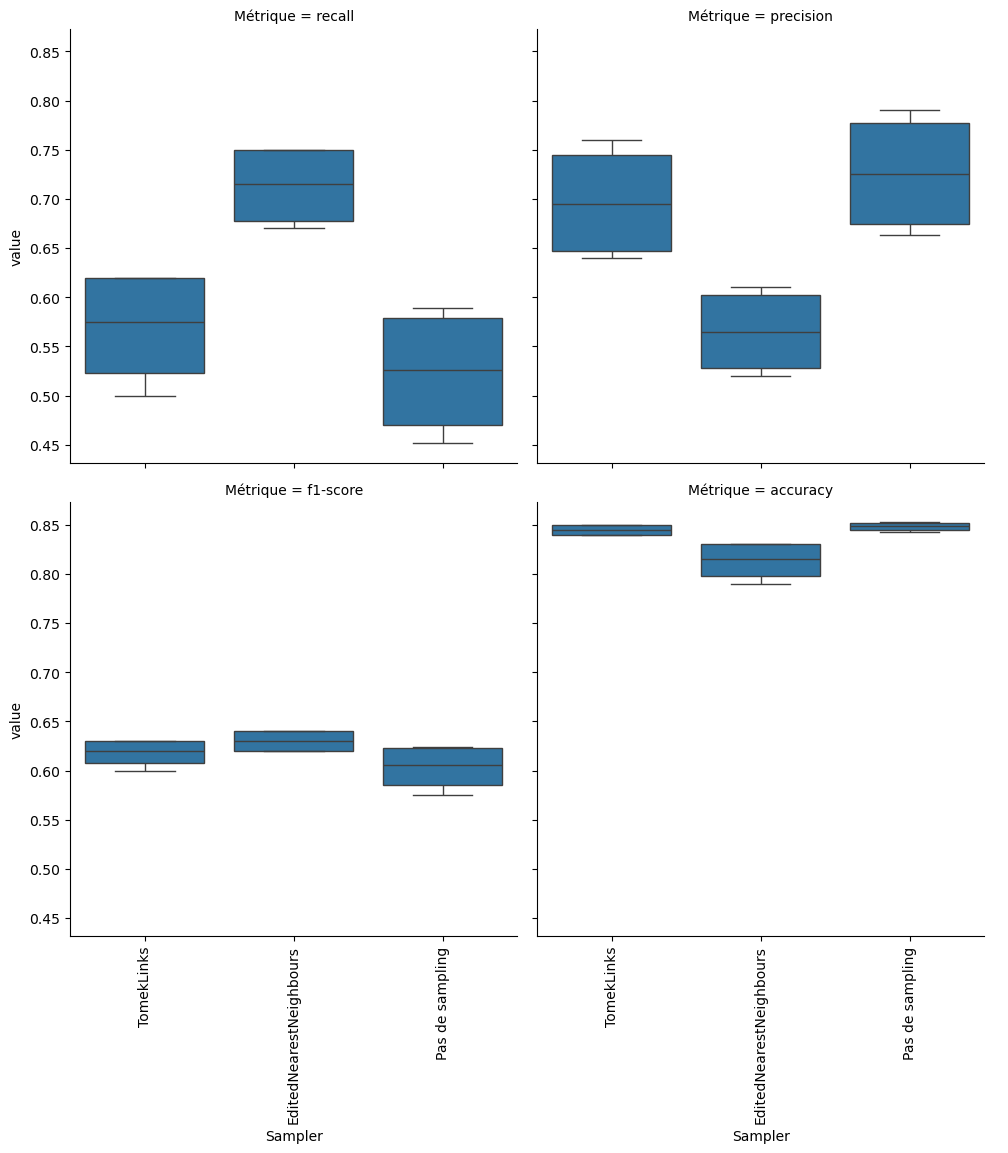

In [69]:
# comparaison avec ou sans rééchantillonage
model_list = list(models_select.keys())
metrics_list = ["recall","precision","f1-score"]
sampler_names = list(samplerlist .keys())
sampler_names.append("Pas de sampling")
class_label = "1.0"
index_results = list(itertools.product(sampler_names, model_list))
index_results = pd.MultiIndex.from_tuples(index_results , 
                                          names=["Sampler", "model_name"])

table_comp_sampling = pd.DataFrame(index = 
                                     index_results, 
                                     columns=[metrics_list] )

table_comp_sampling["accuracy"]=""

for model_name in model_list:
    for sampler_name in  sampler_names:

        table_comp_sampling.loc[(sampler_name,model_name),"accuracy"] = \
                        report_V2t[sampler_name][model_name].loc["accuracy","precision"]
    
        for m in metrics_list:
                table_comp_sampling.loc[(sampler_name,model_name),m] = \
                        report_V2t[sampler_name][model_name].loc[class_label,m]
        

table_comp_sampling = table_comp_sampling.reset_index()
table_comp_sampling.columns = ["Sampler","model_name", "recall","precision","f1-score","accuracy"]

table_comp_sampling  = pd.melt(
    table_comp_sampling ,
        id_vars=["Sampler","model_name"],
        value_vars=["recall","precision","f1-score","accuracy"],
        var_name="Métrique")

print(table_comp_sampling )


plot = sns.catplot(data = table_comp_sampling , x = "Sampler", y="value", 
            hue = "model_name", col =  "Métrique", kind = "bar",
            col_wrap=2)

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig("../plots/rapport/comparaison_samplingVSnosampling.png",  bbox_inches = 'tight')

plot = sns.catplot(data = table_comp_sampling , x = "Sampler", y="value", 
            col =  "Métrique", kind = "box",
            col_wrap=2)

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig("../plots/rapport/comparaison_samplingVSnosampling2.png",  bbox_inches = 'tight')


## Balanced RandomForest et Bagging 


In [70]:
# test Balanced RandomForest et Bagging sur V2t

models_select_balanced = {
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BaggingClassifier': BaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5, n_jobs=-1),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5, n_jobs=-1)
}

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select_balanced, 
                  X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
                  save_model = True, save_models_dir="imb_V2t_",
                  save_results=True, save_results_dir="Resample/imb_V2t_")



Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  BalancedRandomForestClassifier
Fitting  BalancedBaggingClassifier


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.77    0.48      0.59  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.75 41413.00
weighted avg       0.85    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30912  1323
1.00   4737  4441


Nom du modèle : BaggingClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.96      0.91 32235.00
1.0                0.79    0.46      0.58  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.83    0.71      0.75 41413.00
weighted avg       0.85    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.0

                        model_name   Métrique value
0           RandomForestClassifier     recall  0.48
1                BaggingClassifier     recall  0.46
2   BalancedRandomForestClassifier     recall  0.77
3        BalancedBaggingClassifier     recall  0.73
4           RandomForestClassifier  precision  0.77
5                BaggingClassifier  precision  0.79
6   BalancedRandomForestClassifier  precision  0.54
7        BalancedBaggingClassifier  precision  0.57
8           RandomForestClassifier   f1-score  0.59
9                BaggingClassifier   f1-score  0.58
10  BalancedRandomForestClassifier   f1-score  0.64
11       BalancedBaggingClassifier   f1-score  0.64
12          RandomForestClassifier   accuracy  0.85
13               BaggingClassifier   accuracy  0.85
14  BalancedRandomForestClassifier   accuracy  0.81
15       BalancedBaggingClassifier   accuracy  0.82


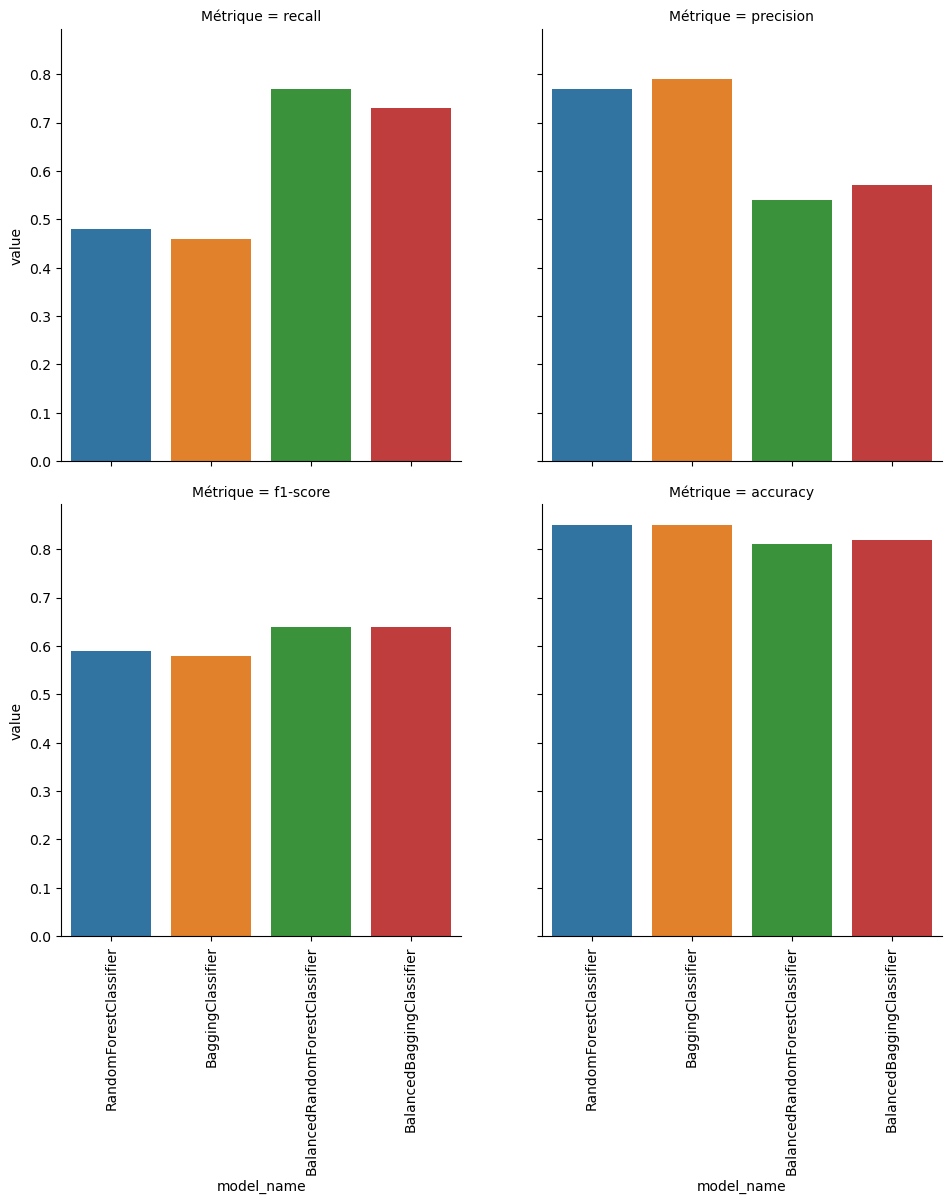

In [71]:
# Comparaison des modèles balanced / unbalanced 

model_list = list(models_select_balanced.keys())
metrics_list = ["recall","precision","f1-score"]
class_label = "1.0"
index_results = list(itertools.product(model_list))
index_results = pd.MultiIndex.from_tuples(index_results , 
                                          names=["model_name"])

table_comp = pd.DataFrame(index = index_results, 
                          columns=[metrics_list] )

table_comp["accuracy"]=""

for model_name in model_list:
    table_comp.loc[(model_name),"accuracy"] = \
                report_V2t[model_name].loc["accuracy","precision"]
    
    for m in metrics_list:
        table_comp.loc[(model_name),m] = \
                report_V2t[model_name].loc[class_label,m]
        

table_comp = table_comp.reset_index()
table_comp.columns = ["model_name", "recall","precision","f1-score","accuracy"]

table_comp = pd.melt(
    table_comp,
        id_vars=["model_name"],
        value_vars=["recall","precision","f1-score","accuracy"],
        var_name="Métrique")

print(table_comp)


plot = sns.catplot(data = table_comp, x = "model_name", y="value", 
            hue = "model_name", col = "Métrique", kind = "bar",
            col_wrap=2)

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig("../plots/rapport/comparaison_balancedmodels.png",  bbox_inches = 'tight')


## Paramètre classweight

In [72]:
# grid search sur class_weight uniquement

#Setting the range for class weights
weights = np.linspace(0.0,1.0,20)
print(weights)

models_select_cw  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'LinearSVC'   : LinearSVC(),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1),
                                 
}

param_grids_cw = {
    'LogisticRegression': {'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'RandomForestClassifier': {'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'BalancedRandomForestClassifier': {'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'LinearSVC' : {'class_weight': [{0:x, 1:1.0-x} for x in weights]}
}

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 20 candidates, totalling 60 fits
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            1.84          0.05             0.15            0.01   
1            4.19          0.54             0.14            0.02   
2            4.89          0.12             0.11            0.01   
3            5.16          0.58             0.14            0.03   
4            4.49          0.31             0.13            0.02   
5            4.84          0.28             0.11            0.00   
6            4.75          0.46             0.13            0.02   
7            5.01          0.38             0.12            0.02   
8            5.55          0.68             0.12            0.02   
9            4.91          0.22             0.13            0.02   
10           3.97          0.37             0.18            0.03   
11           4.30          0.08             0.09            0.01   
12        

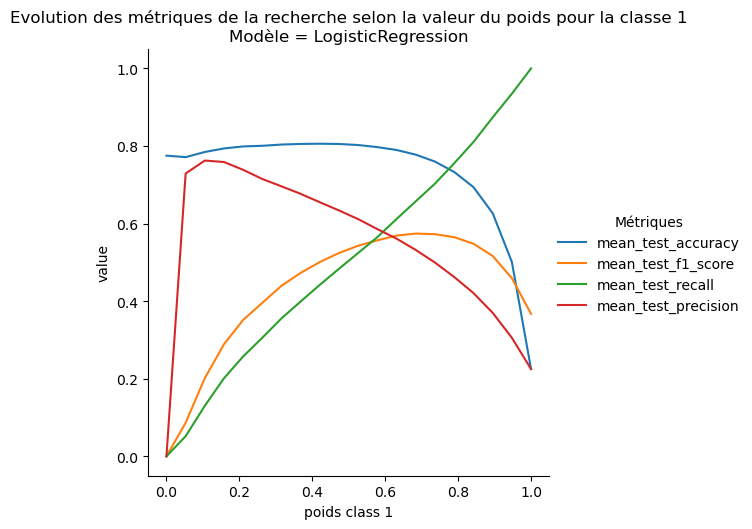

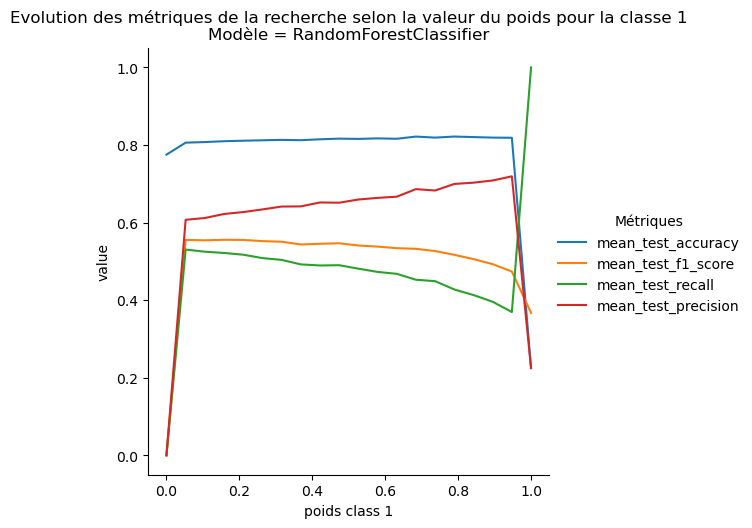

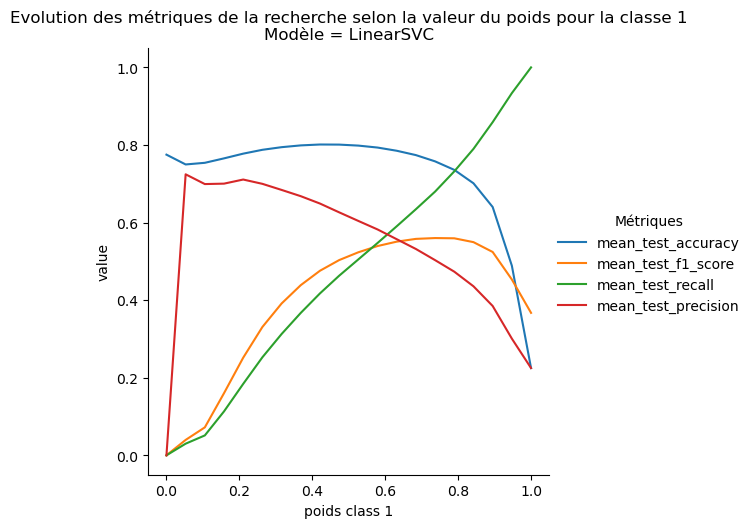

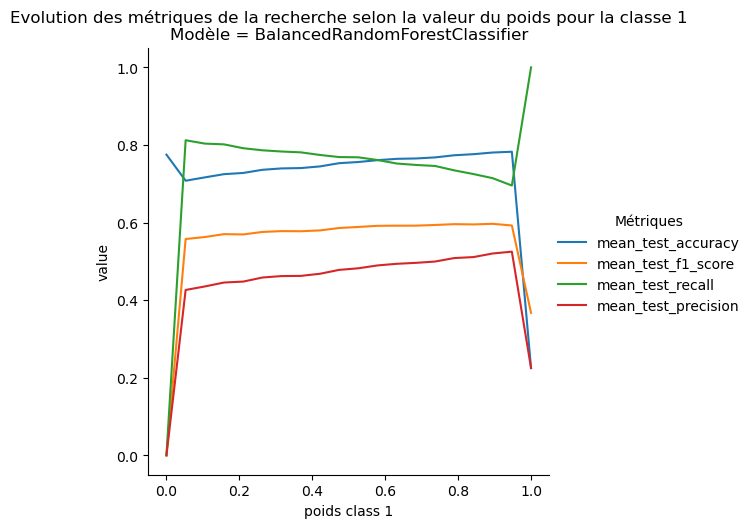

In [73]:
dataset = "V2t"
modeling_batch = "classweight"
# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "f1_score" : make_scorer(f1_score), 
                "recall" : make_scorer(recall_score, pos_label=1),
                "precision" : make_scorer(precision_score,pos_label=1)}


variable_cible = "Raintomorrow"
param_grids = param_grids_cw
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t

for model_name, model in models_select_cw.items() : 

    # crée les dossiers de résultats 
    model_dir = "../saved_models/global/" + \
        dataset + "/" + modeling_batch + "/"

    os.makedirs(os.path.dirname(model_dir), exist_ok=True)

    results_search, search = \
        mf.optimize_parameters(model_name, model, 
                               param_grids_cw[model_name] ,
                               X_train_search, X_test_search, y_train_search,  y_test_search,
                               scoring=grid_metrics,
                               search_method = 'GridSearchCV')
    
    # save le search
    with open(model_dir + "allmetrics" + model_name + 'search.pkl', 'wb') as f:
                    pickle.dump(search, f)

    
    data_plot = pd.DataFrame(search.cv_results_)
    print(data_plot)
    data_plot["poids class 1"] = 1-weights
    value_vars = ["mean_test_" + str(x) for x in grid_metrics.keys()]
    print(value_vars)
    data_plot= data_plot.melt(id_vars=["param_class_weight", "poids class 1"], 
                value_vars=value_vars, var_name="Métriques")

    sns.relplot(data = data_plot, x ="poids class 1", 
                y="value", hue = "Métriques", 
                kind = "line")

    plt.title("Evolution des métriques de la recherche selon la valeur du poids pour la classe 1" + "\n" + "Modèle = " + model_name)

    plt.savefig("../plots/rapport/gridsearch_class_weight" + model_name + ".png", 
                bbox_inches = 'tight')

                    

In [74]:
# # avec class_weight 
# df_V2.RainTomorrow.value_counts(normalize=True)

# models_select_cw = {
#     'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1, 
#                                              class_weight = {0 : 0.4, 1 : 0.6 }),
#     'RandomForestClassifier': RandomForestClassifier(n_jobs=-1,  
#                                                      class_weight = {0 : 0.1, 1 : 0.9 }),
#     'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1,
#                                                                       class_weight = {0 : 0.1, 1 : 0.9 }),
#     'LinearSVC': LinearSVC(class_weight = {0 : 0.4, 1 : 0.6 })
# }

# report_V2t, cm_V2t, models_V2t = \
#     mf.fit_models(models_select_cw , 
#                   X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
#                   save_model = True, save_models_dir="cw_V2t_",
#                   save_results=True, save_results_dir="Resample/cw_V2t_")



# Choix des hyperparamètres à optimiser

In [10]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,5)
weights = [0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.75,0.9,0.95,1]
print(weights)
print(weights)

# Hyperparamètres à tester pour chaque modèle
param_grids1 = {
    'LogisticRegression': {'max_iter' : [500,1000],
                           'C': [0.1, 1, 10], 
                           'solver': ['liblinear', 'saga'],
                           'class_weight': [{0:x, 1:1.0-x} for x in weights],
                           'penalty':['l1', 'l2']},
    'RandomForestClassifier': {'n_estimators': [50, 100, 200], 
                               'max_depth': [10, 20, 30],
                               'criterion':['gini', 'entropy', 'log_loss'],
                               'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'BalancedRandomForestClassifier': {'n_estimators': [50, 100, 200], 
                               'max_depth': [10, 20, 30],
                               'criterion':['gini', 'entropy', 'log_loss'],
                               'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'BaggingClassifier': {'n_estimators': [500, 1000, 2000], 
                           'max_samples' : [0.1, 0.5, 1]},
    'BalancedBaggingClassifier': {'n_estimators': [500, 1000, 2000], 
                           'max_samples' : [0.05, 0.1, 0.2, 0.5]}
}
# Hyperparamètres à tester pour chaque modèle (plus vaste)


param_grids2 = {
    'LogisticRegression': {
        'max_iter' : [100,500],
        'C':[0.1, 1, 10],
        'solver': ['newton-cholesky','newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty':['none', 'elasticnet', 'l1', 'l2'],
        'fit_intercept': [True, False],
        'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [10, 30, 50],
        'max_features': ['sqrt', None],
        'min_samples_leaf': [1, 2, 5, 10],
        'min_samples_split': [2, 5, 10,20],
        'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'BalancedRandomForestClassifier': {
        'n_estimators': [100, 200, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [10, 30, 50],
        'max_features': ['sqrt', None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'BaggingClassifier': {
        'n_estimators': [50, 500, 1000, 2000], 
        'max_samples' : [0.05, 0.1, 0.2, 0.5, 1],
        'max_features': [0.5, 0.8, 0.95, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]},
    'BalancedBaggingClassifier': {
        'n_estimators': [50, 500, 1000, 2000], 
        'max_samples' : [0.05, 0.1, 0.2, 0.5, 1],
        'max_features': [0.5, 0.8, 0.95, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]}
}
param_grids3 = {
    'LogisticRegression': {
        'max_iter' : [100],
        'C':[0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cholesky','newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty':['none', 'elasticnet'],
        'fit_intercept': [True],
        'class_weight': [{0:x, 1:1.0-x} for x in weights]},
}



[0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 0.9, 0.95, 1]
[0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 0.9, 0.95, 1]


In [11]:
models_select_search = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1)
}


# optimisation sur les données V2 et V3

## 1) tuning LR, grille de paramètres simple

### 1-1) Données V2

Métrique de recherche : accuracy
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.95      0.91 32235.00
1.0                0.73    0.48      0.58  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.80    0.71      0.74 41413.00
weighted avg       0.84    0.85      0.83 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30618  1617
1.00   4779  4399
Métrique de recherche : average_precision
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.92      0.90 32235.00
1.0           

'GridSearchjFinished'

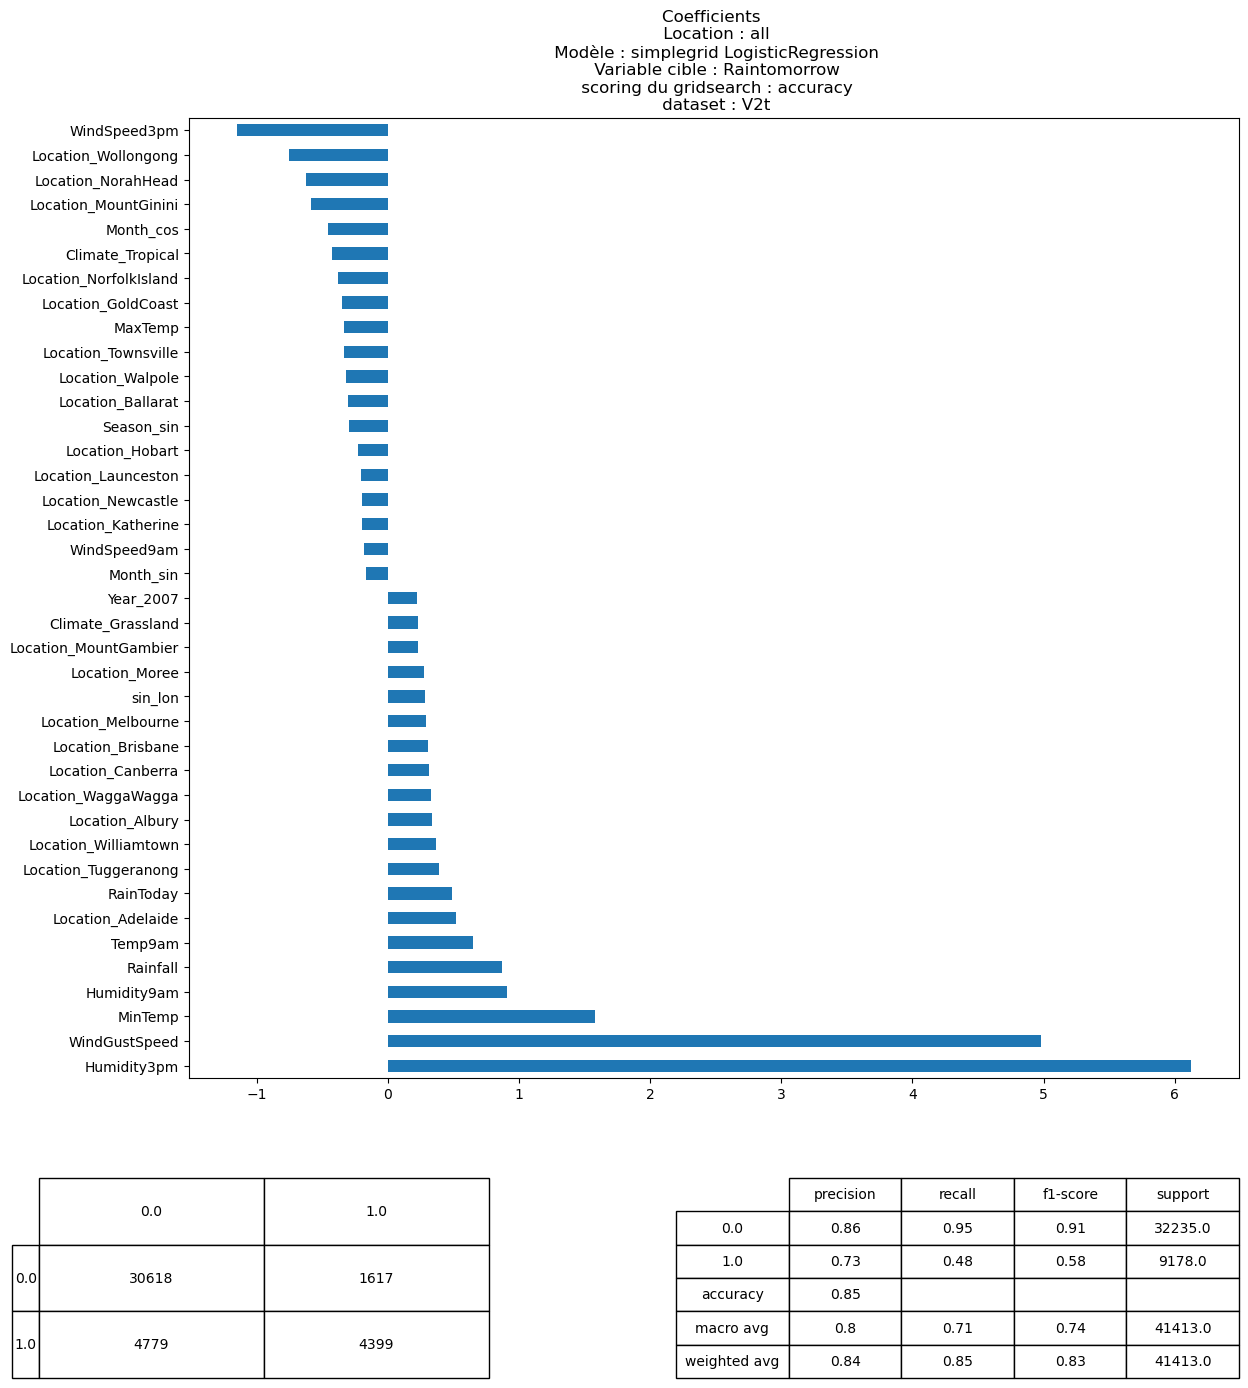

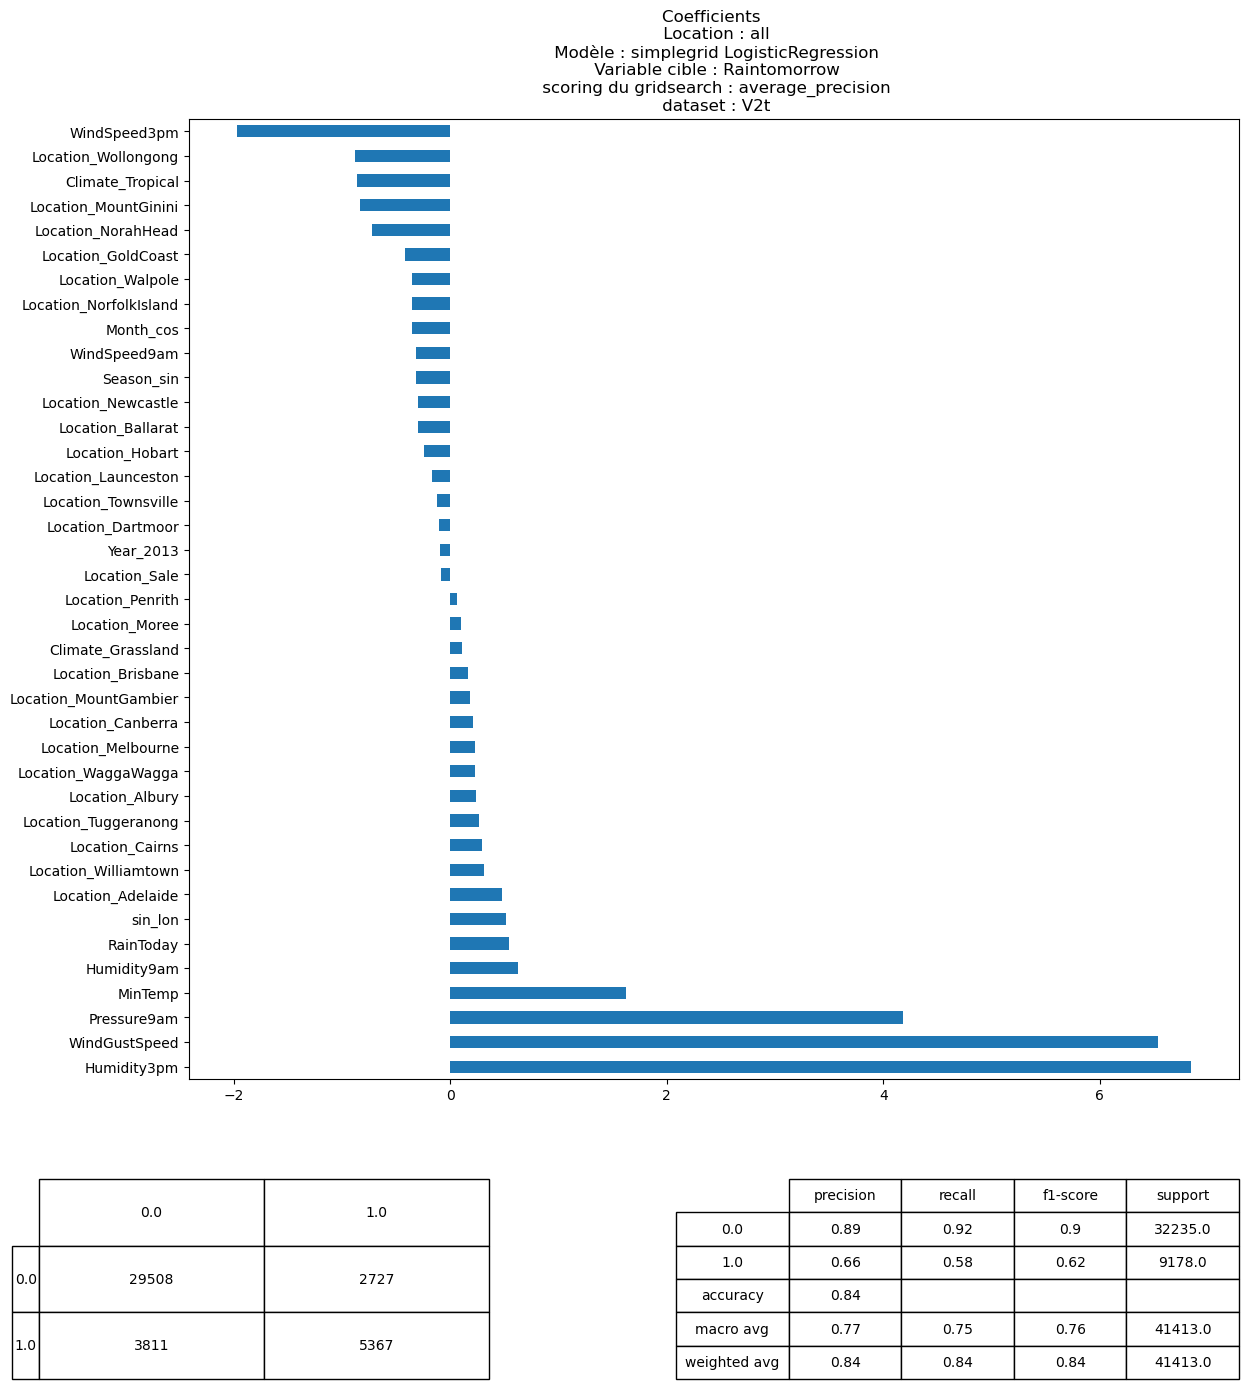

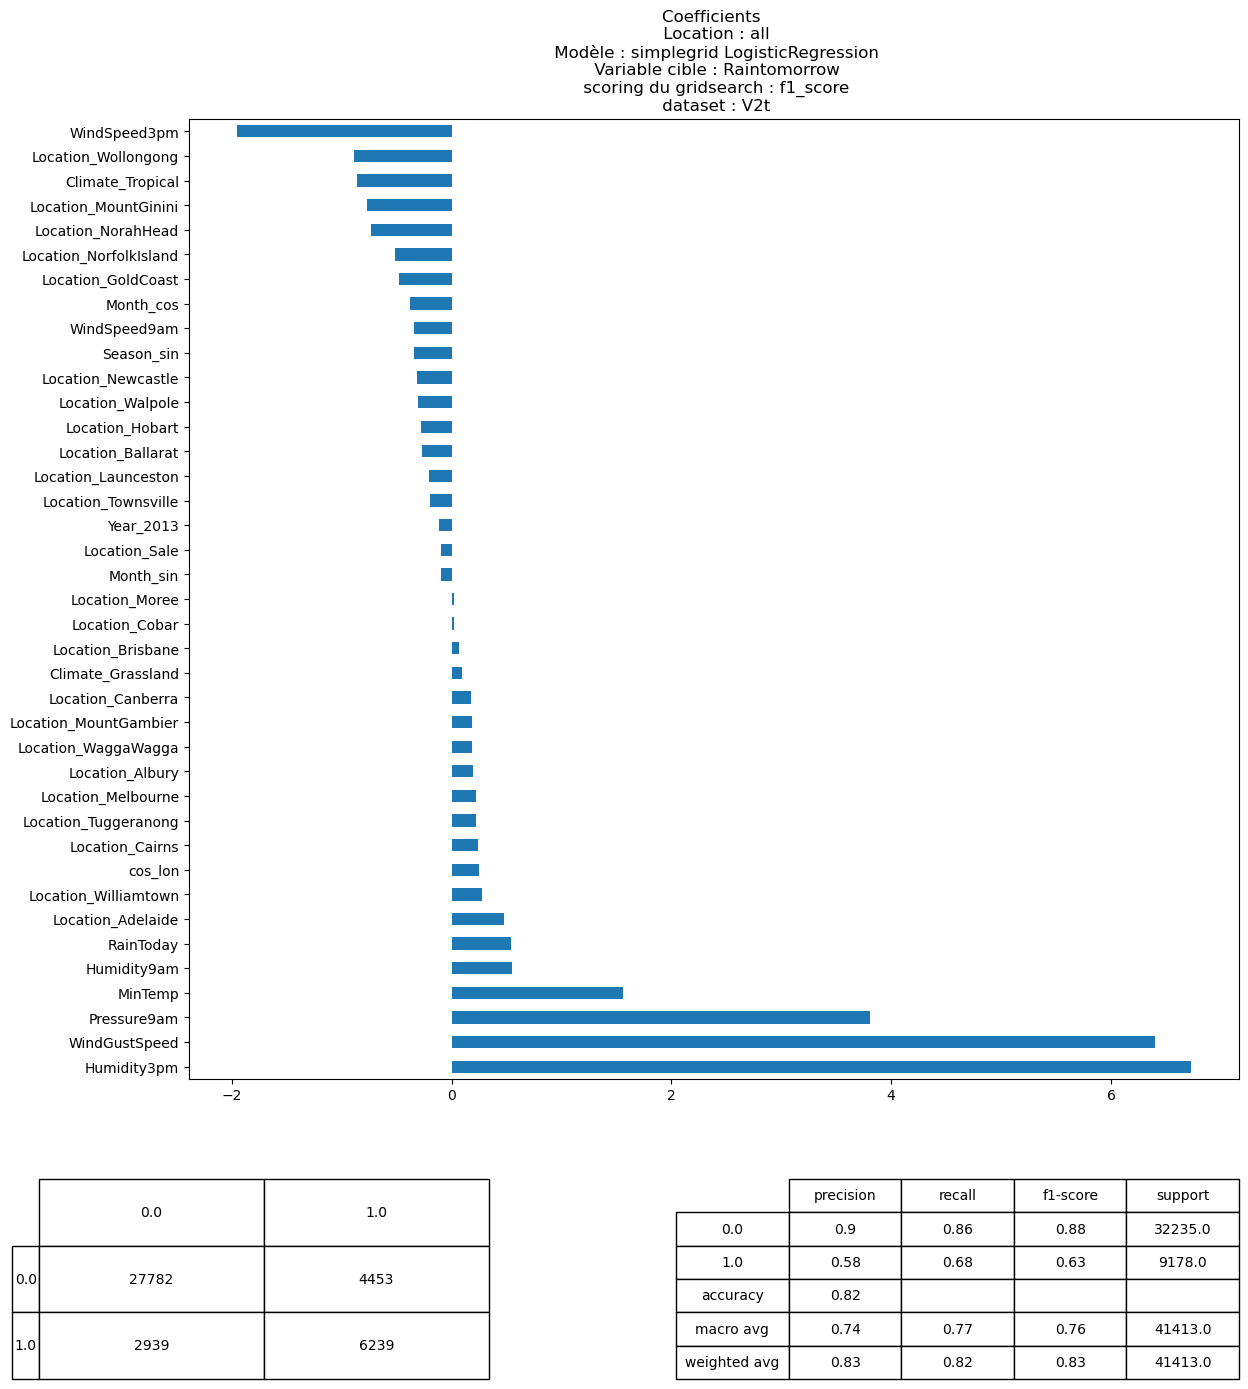

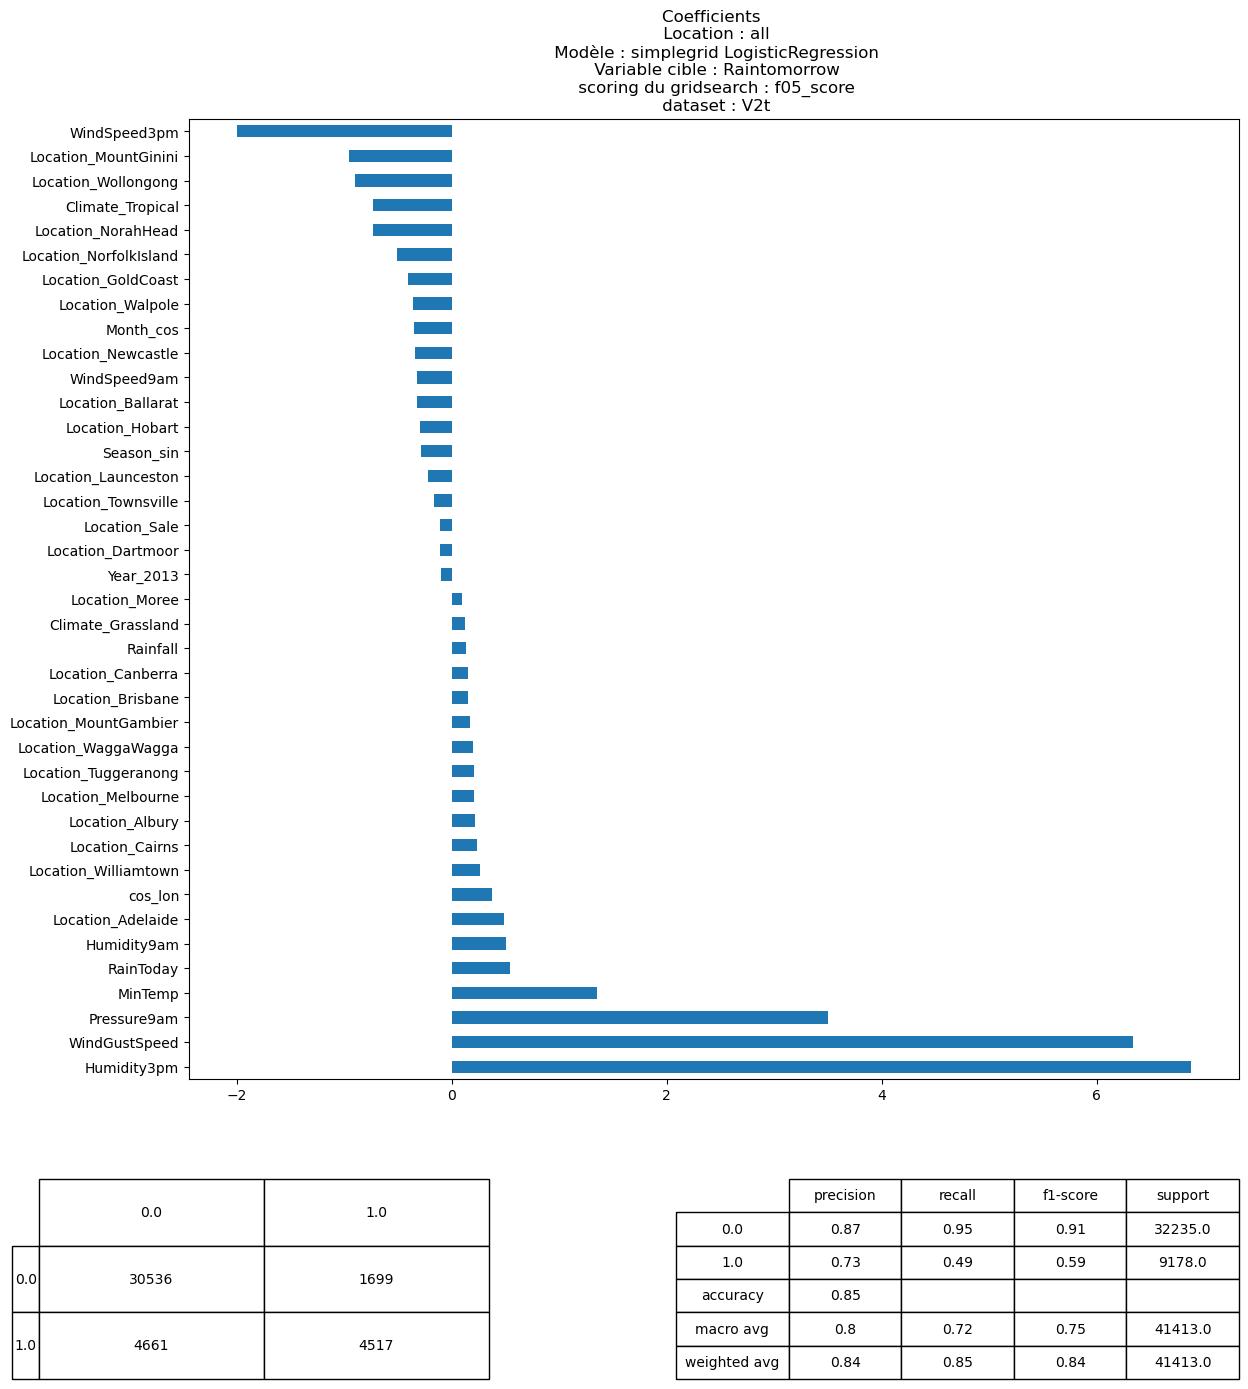

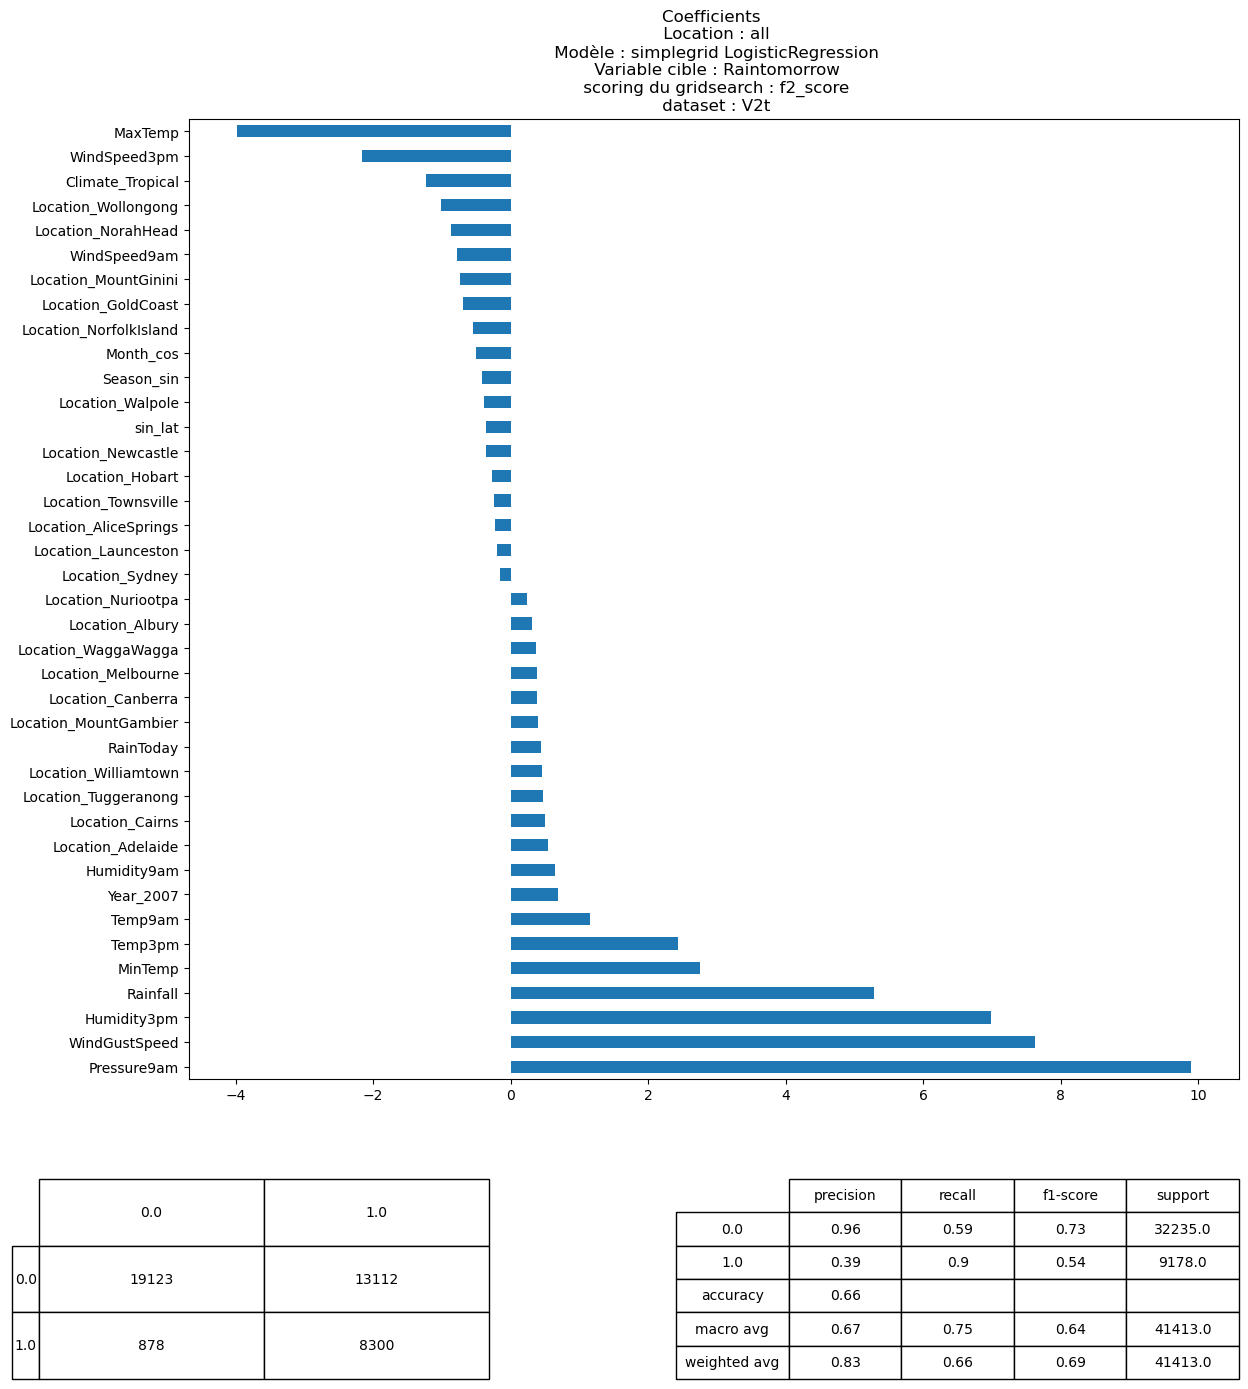

In [62]:
# tuning LR basique sur V2
model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)
dataset = "V2t"
modeling_batch = "simplegrid"

# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f05_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1),
                "f2_score" : make_scorer(fbeta_score, beta=2, pos_label=1)}

variable_cible = "Raintomorrow"
param_grids = param_grids1
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t


mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                    grid_metrics, variable_cible, 
                    X_train_search, X_test_search, y_train_search, y_test_search, 
                    n_coef_graph)
    


In [63]:

model_dir = "../saved_models/global/" + \
   dataset + "/" + modeling_batch + "/" 

model_name = "LogisticRegression"
scoring_name = "f1_score"
print(model_dir + scoring_name + model_name + "search.pkl")
# load le search
with open(model_dir + scoring_name + model_name + "search.pkl", 'rb') as f:
   search = pickle.load(f)


print(search.best_estimator_)

print(search.cv_results_)


../saved_models/global/V2t/simplegrid/f1_scoreLogisticRegressionsearch.pkl
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=500,
                   n_jobs=-1, penalty='l1', solver='liblinear')
{'mean_fit_time': array([  0.44511445,   1.65141551,   0.64599514,  73.31196229,
         0.55510489,   1.71965353,   0.51871832, 143.5341777 ,
         2.44869208,   6.61522841,   1.04815483,   2.73167936,
         2.63955283,   6.47011741,   1.20361567,   2.7708497 ,
         5.00135994,   5.2060492 ,   1.23559189,   3.02076419,
         5.05485559,   5.13834572,   1.01996024,   2.91888674,
        18.04484487,   6.00022562,   1.237746  ,   3.25014949,
        19.91844424,   6.19176269,   1.52433268,   3.26994117,
        18.2431256 ,   6.51294939,   1.37559032,   3.26523058,
        19.37725949,   6.54996498,   1.39963587,   3.23346599,
        15.53306929,   6.65975459,   1.29267597,   3.40629617,
        19.72568448,   7.0884548 ,   1.31068842,   3.64332032,
        13.71457

### 1-2) Données V3

Métrique de recherche : accuracy
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.83    0.95      0.89 29559.00
1.0                0.67    0.33      0.44  8367.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.75    0.64      0.66 37926.00
weighted avg       0.80    0.82      0.79 37926.00
Matrice de confusion :
       0.00  1.00
0.00  28196  1363
1.00   5636  2731
Métrique de recherche : average_precision
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.88    0.86      0.87 29559.00
1.0           

'GridSearchjFinished'

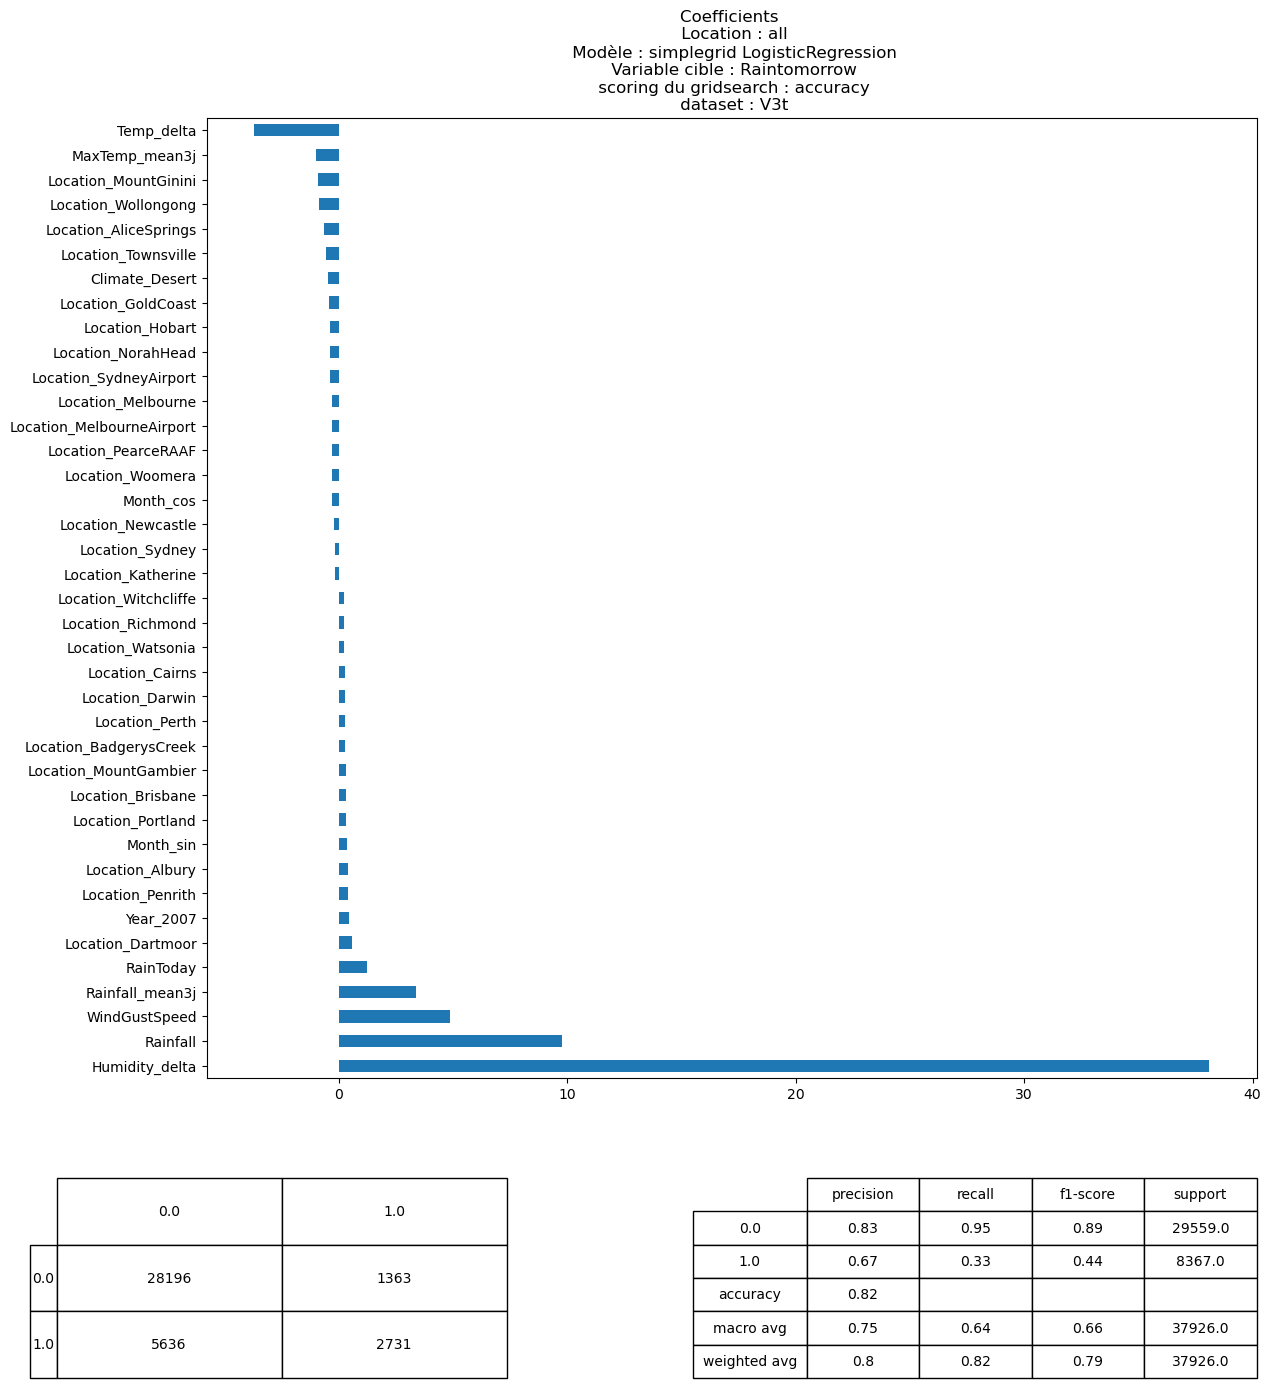

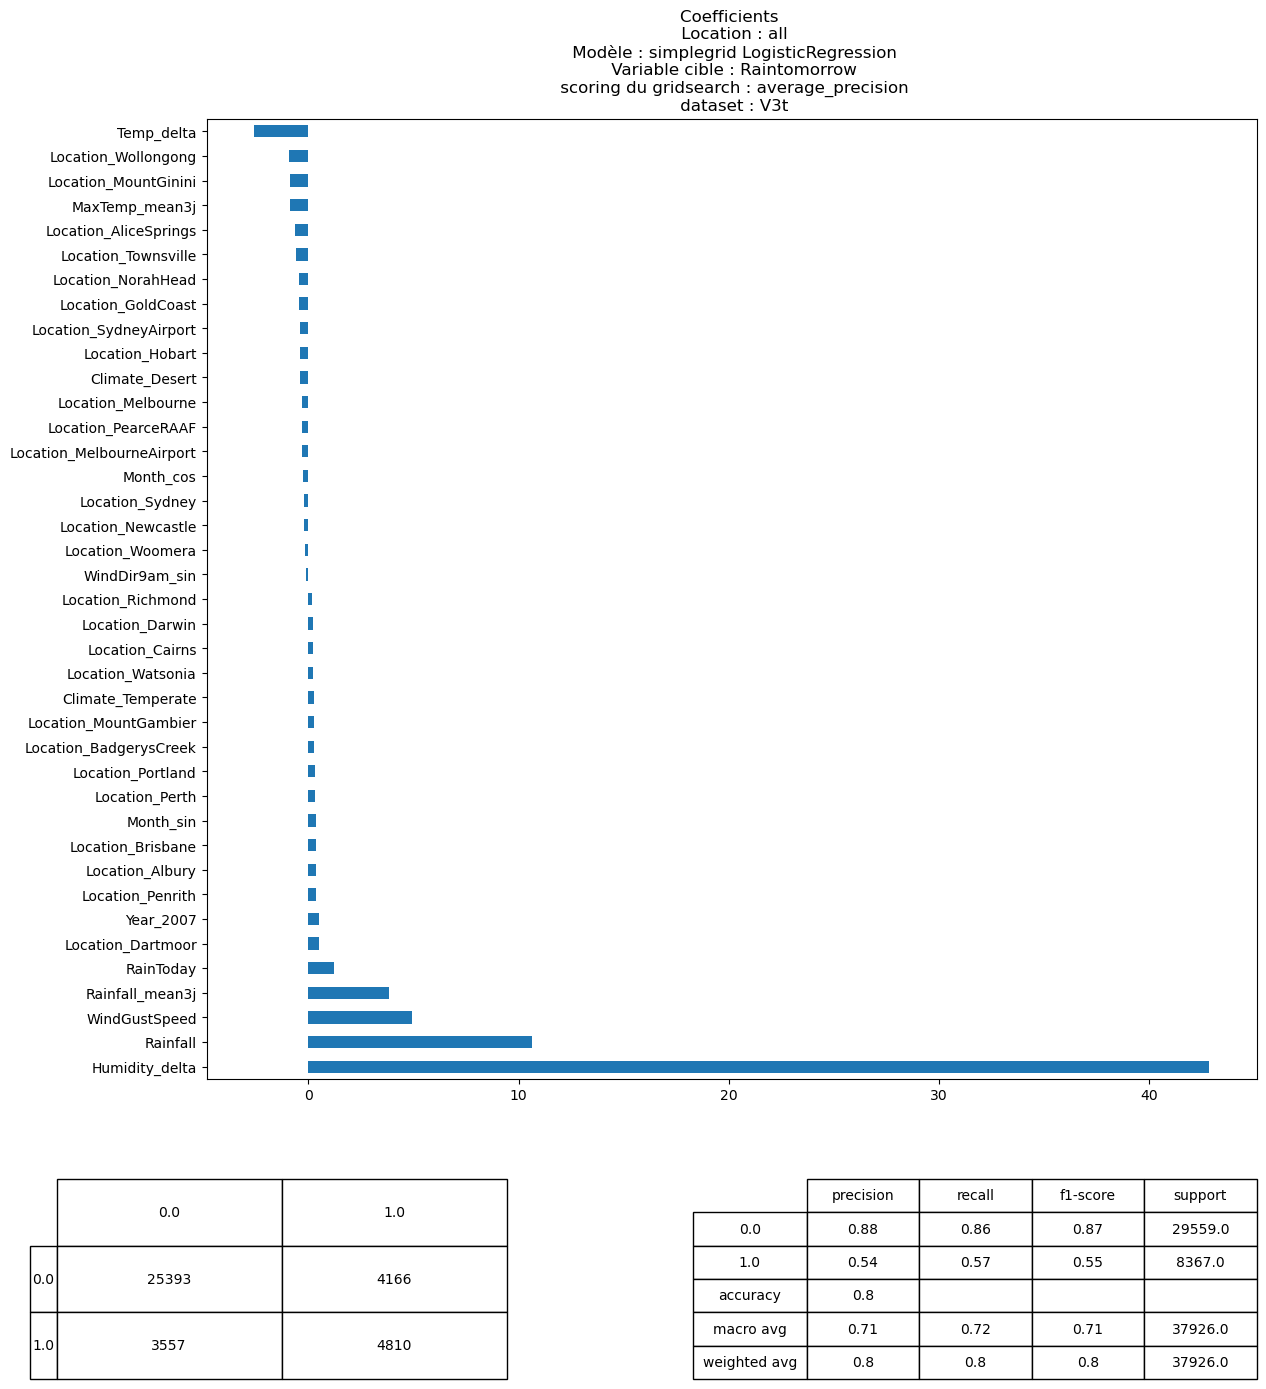

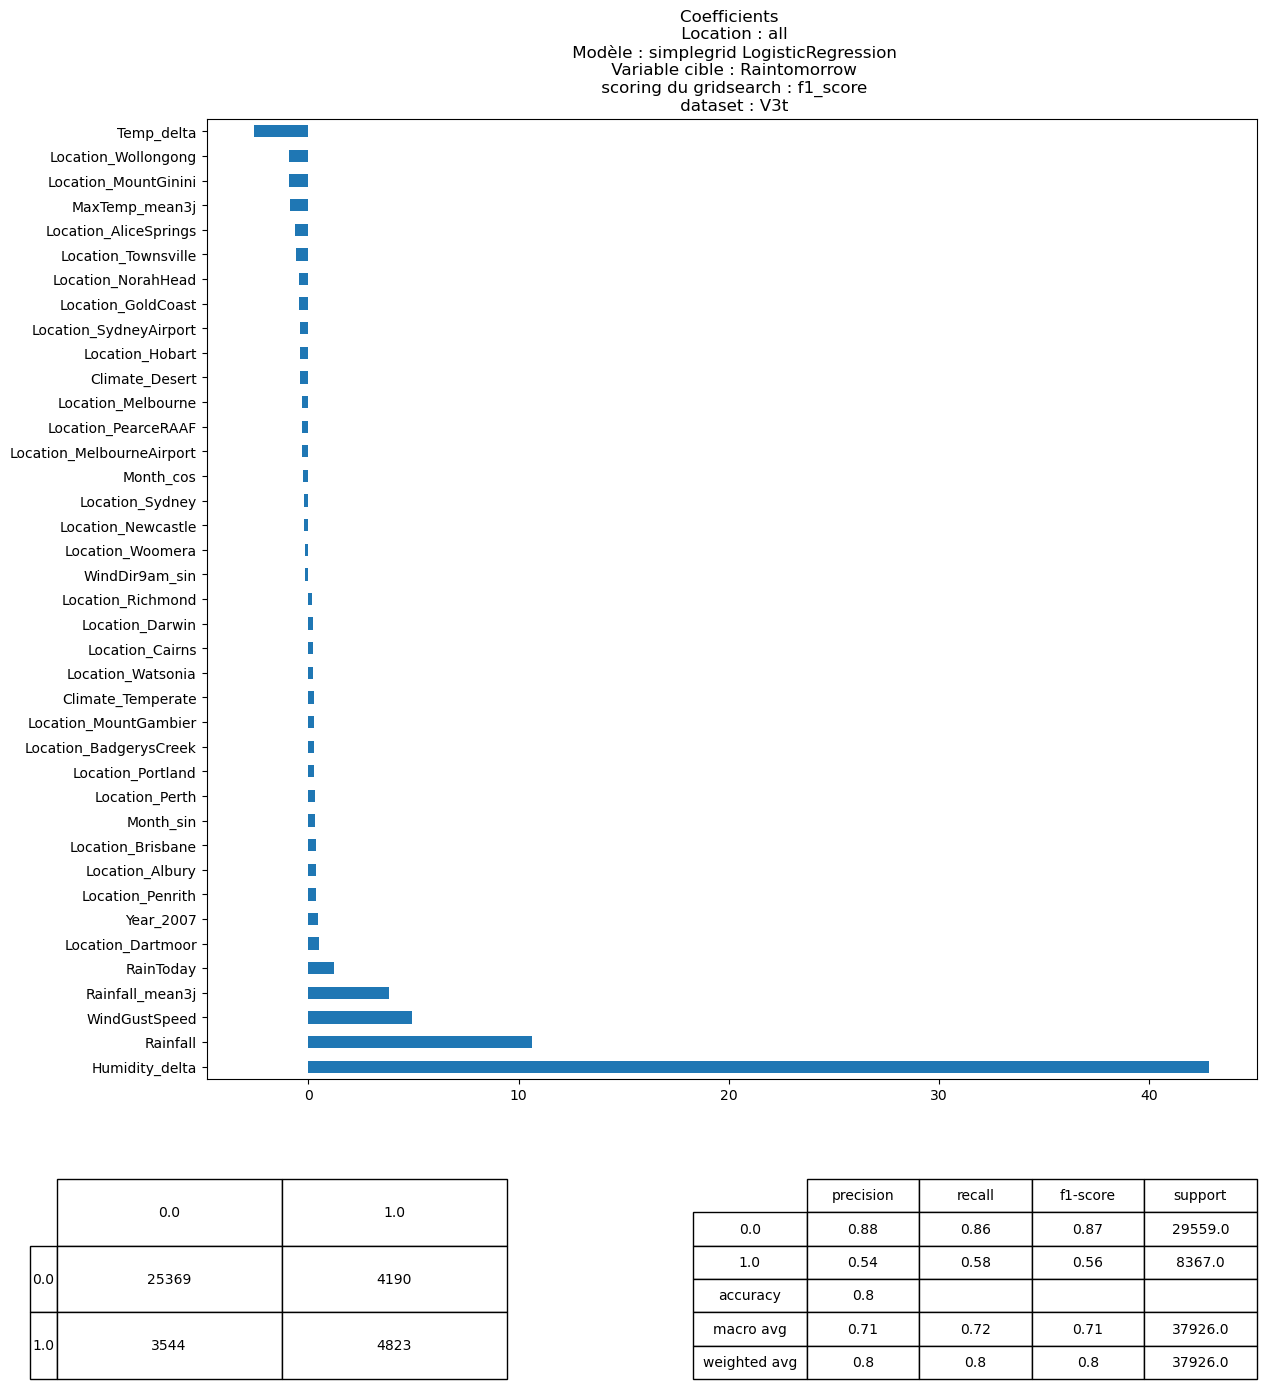

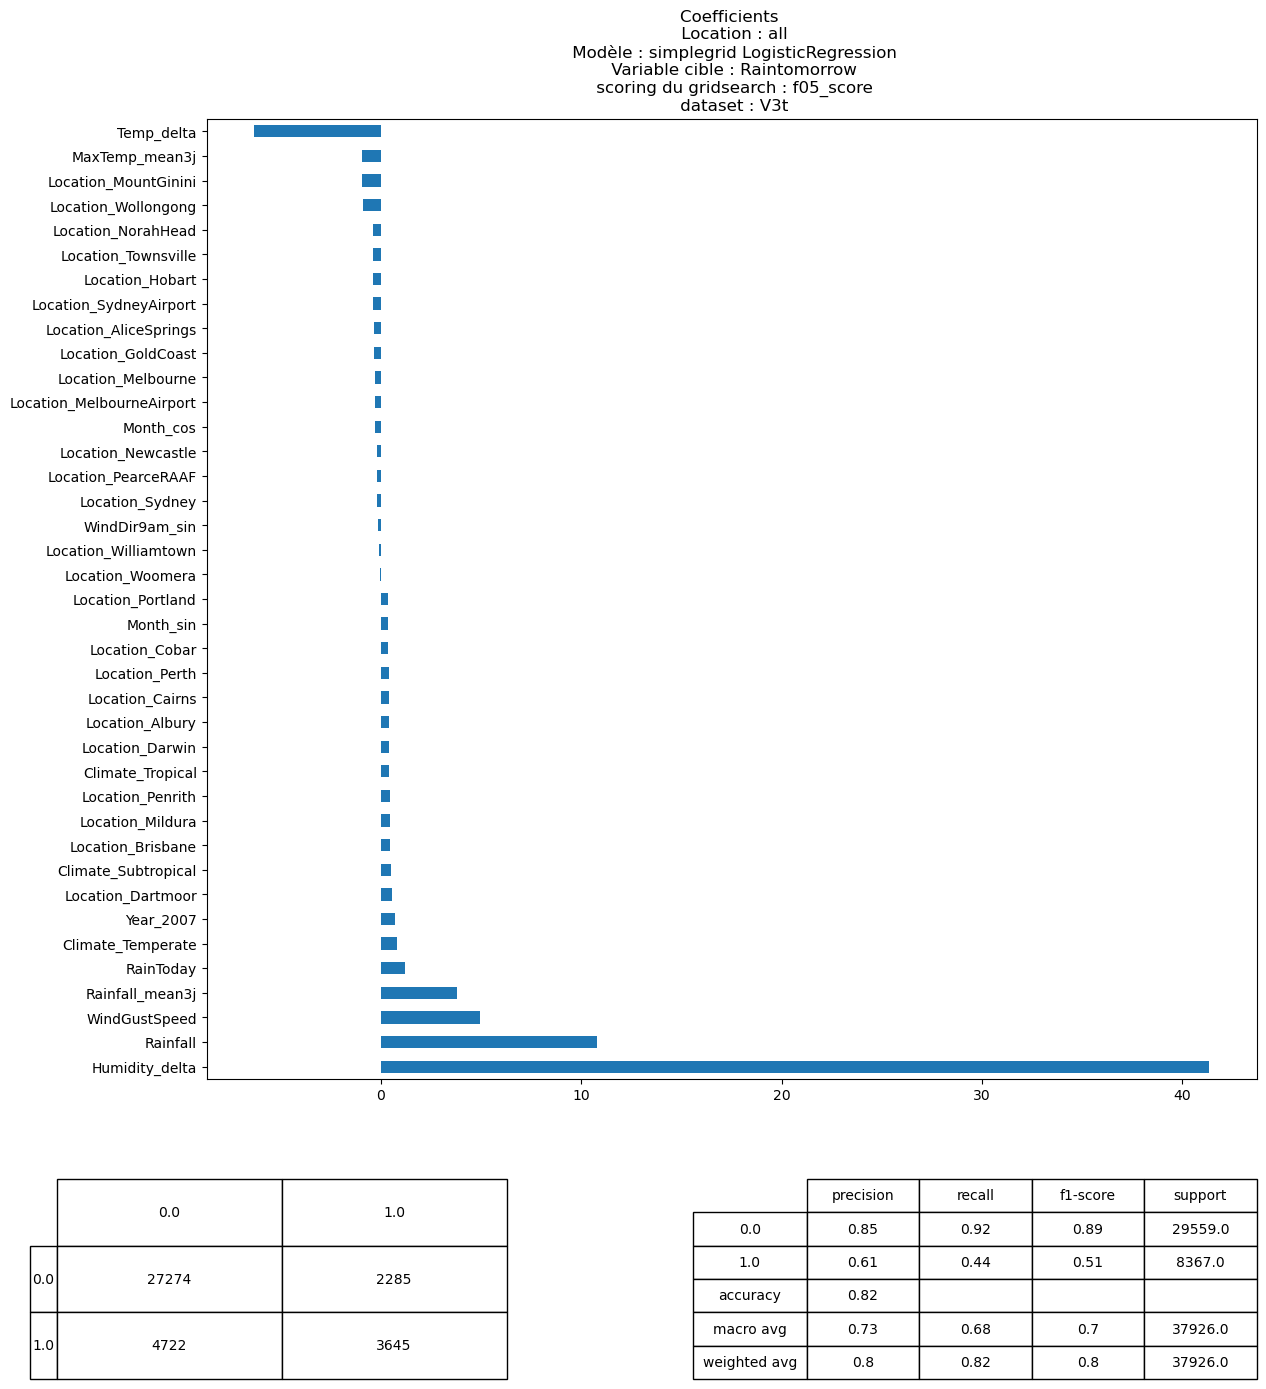

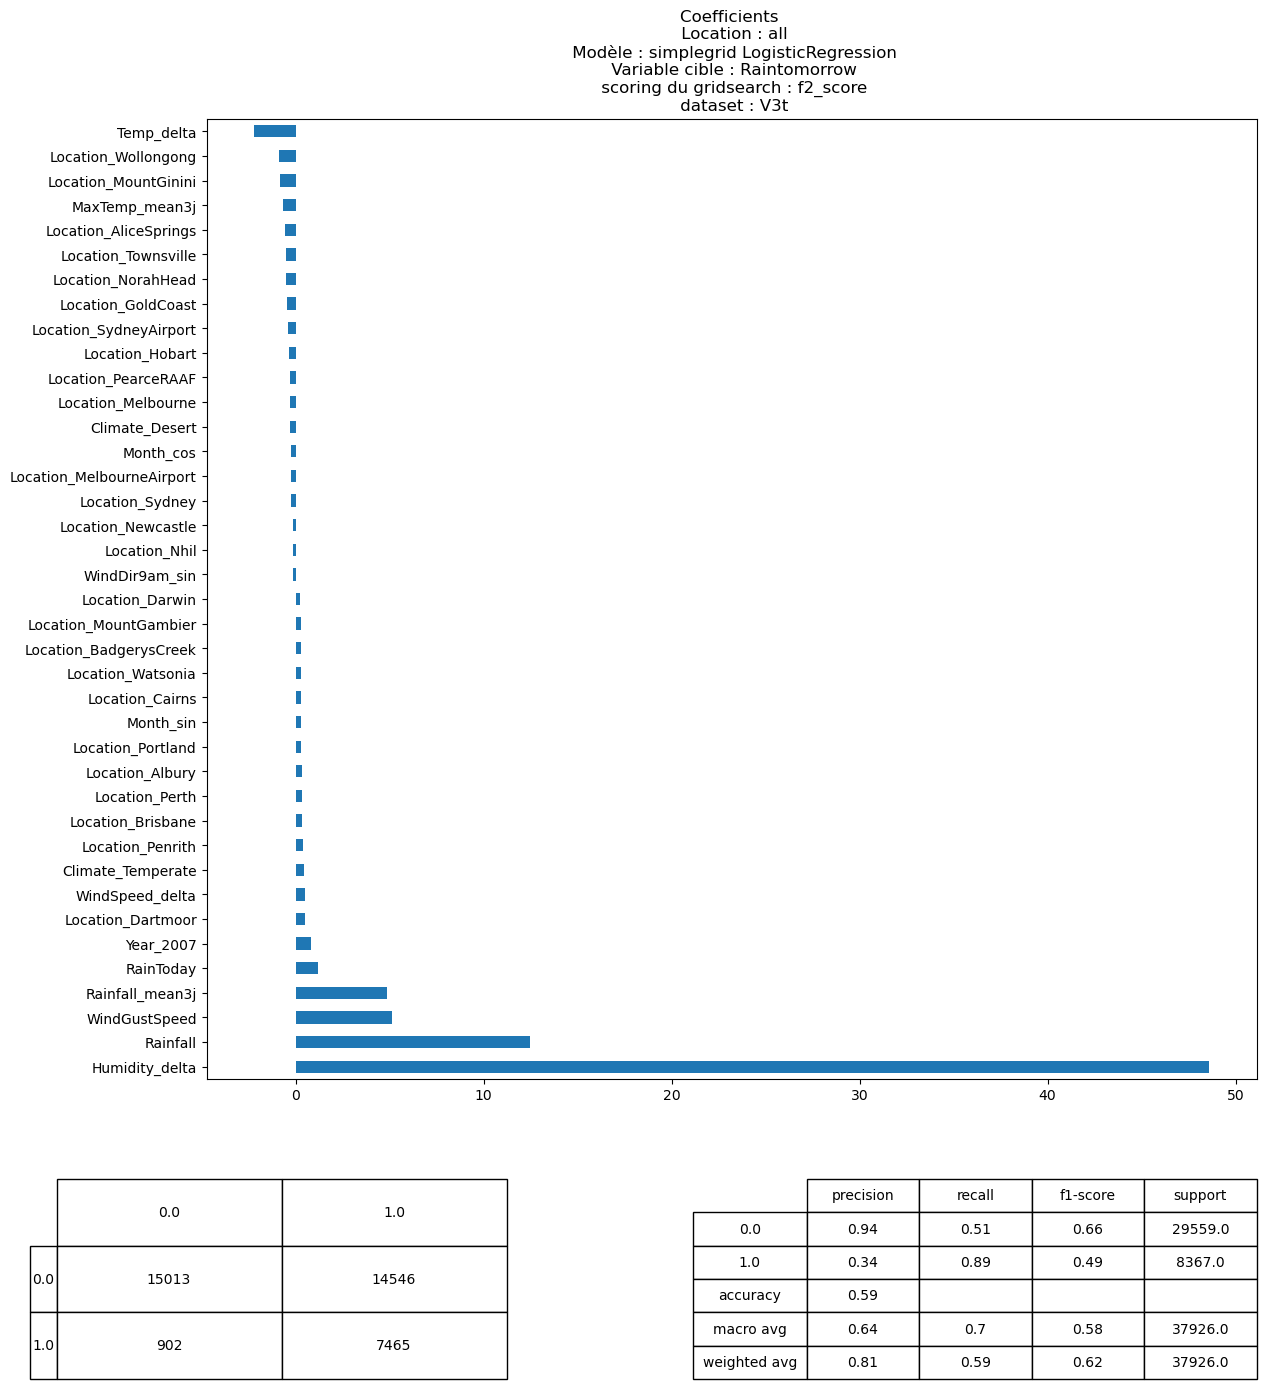

In [13]:
# tuning LR basique sur données V3
model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)
dataset = "V3t"
modeling_batch = "simplegrid"

# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f05_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1),
                "f2_score" : make_scorer(fbeta_score, beta=2, pos_label=1)}

variable_cible = "Raintomorrow"
param_grids = param_grids1
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V3t_scaled, X_test_V3t_scaled, y_train_V3t,  y_test_V3t


mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                    grid_metrics, variable_cible, 
                    X_train_search, X_test_search, y_train_search, y_test_search, 
                    n_coef_graph)
    

## 2) Tuning LR, grille de paramètres plus large

### Données V2

Métrique de recherche : accuracy
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.95      0.90 32235.00
1.0                0.73    0.44      0.55  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.79    0.70      0.73 41413.00
weighted avg       0.83    0.84      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30766  1469
1.00   5154  4024
Métrique de recherche : average_precision
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.95      0.90 32235.00
1.0       

'GridSearchjFinished'

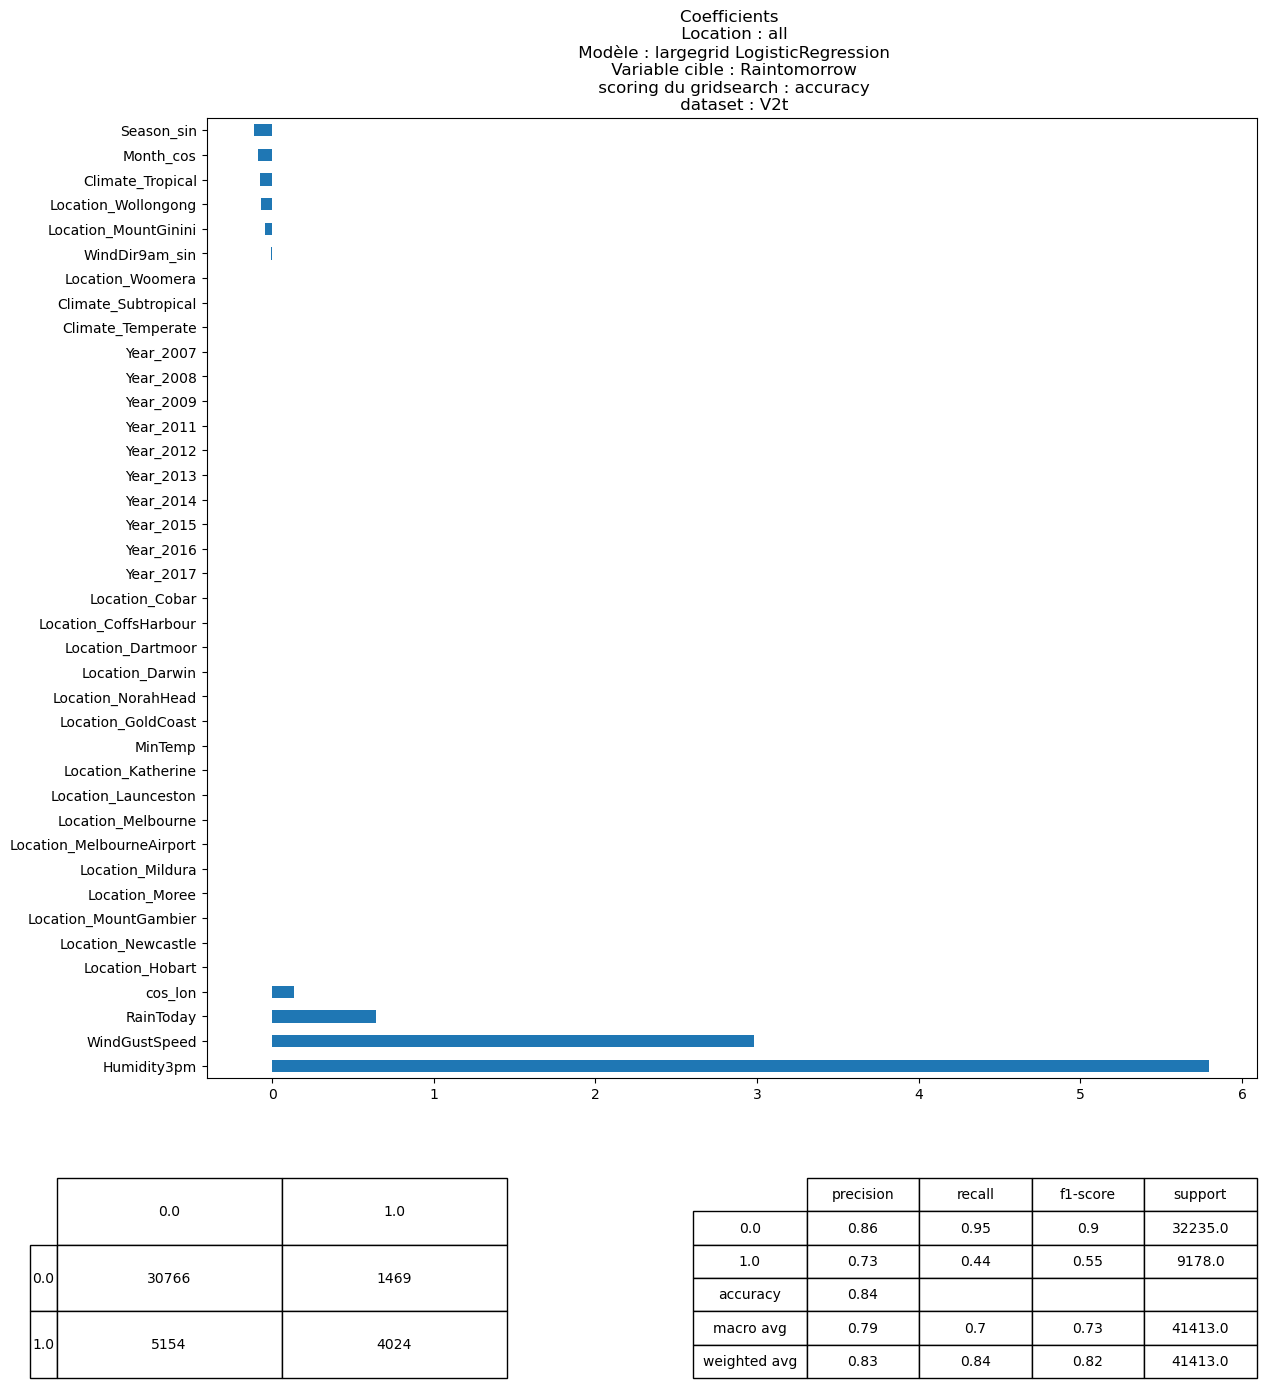

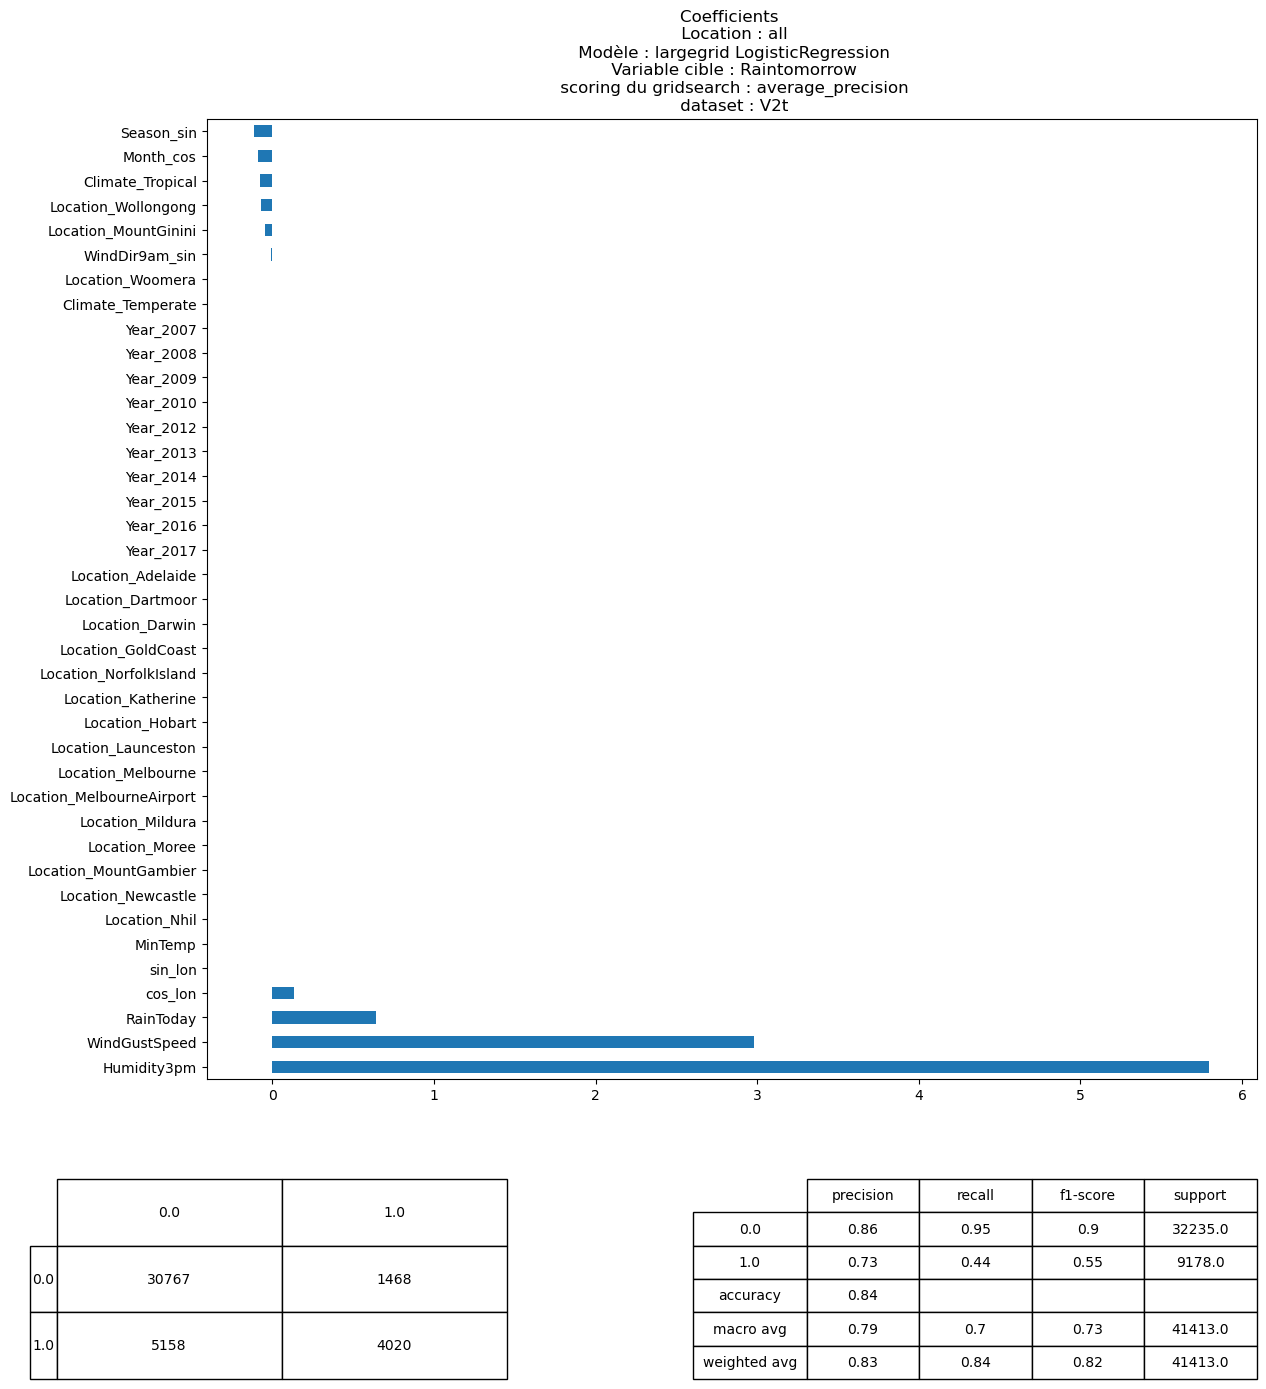

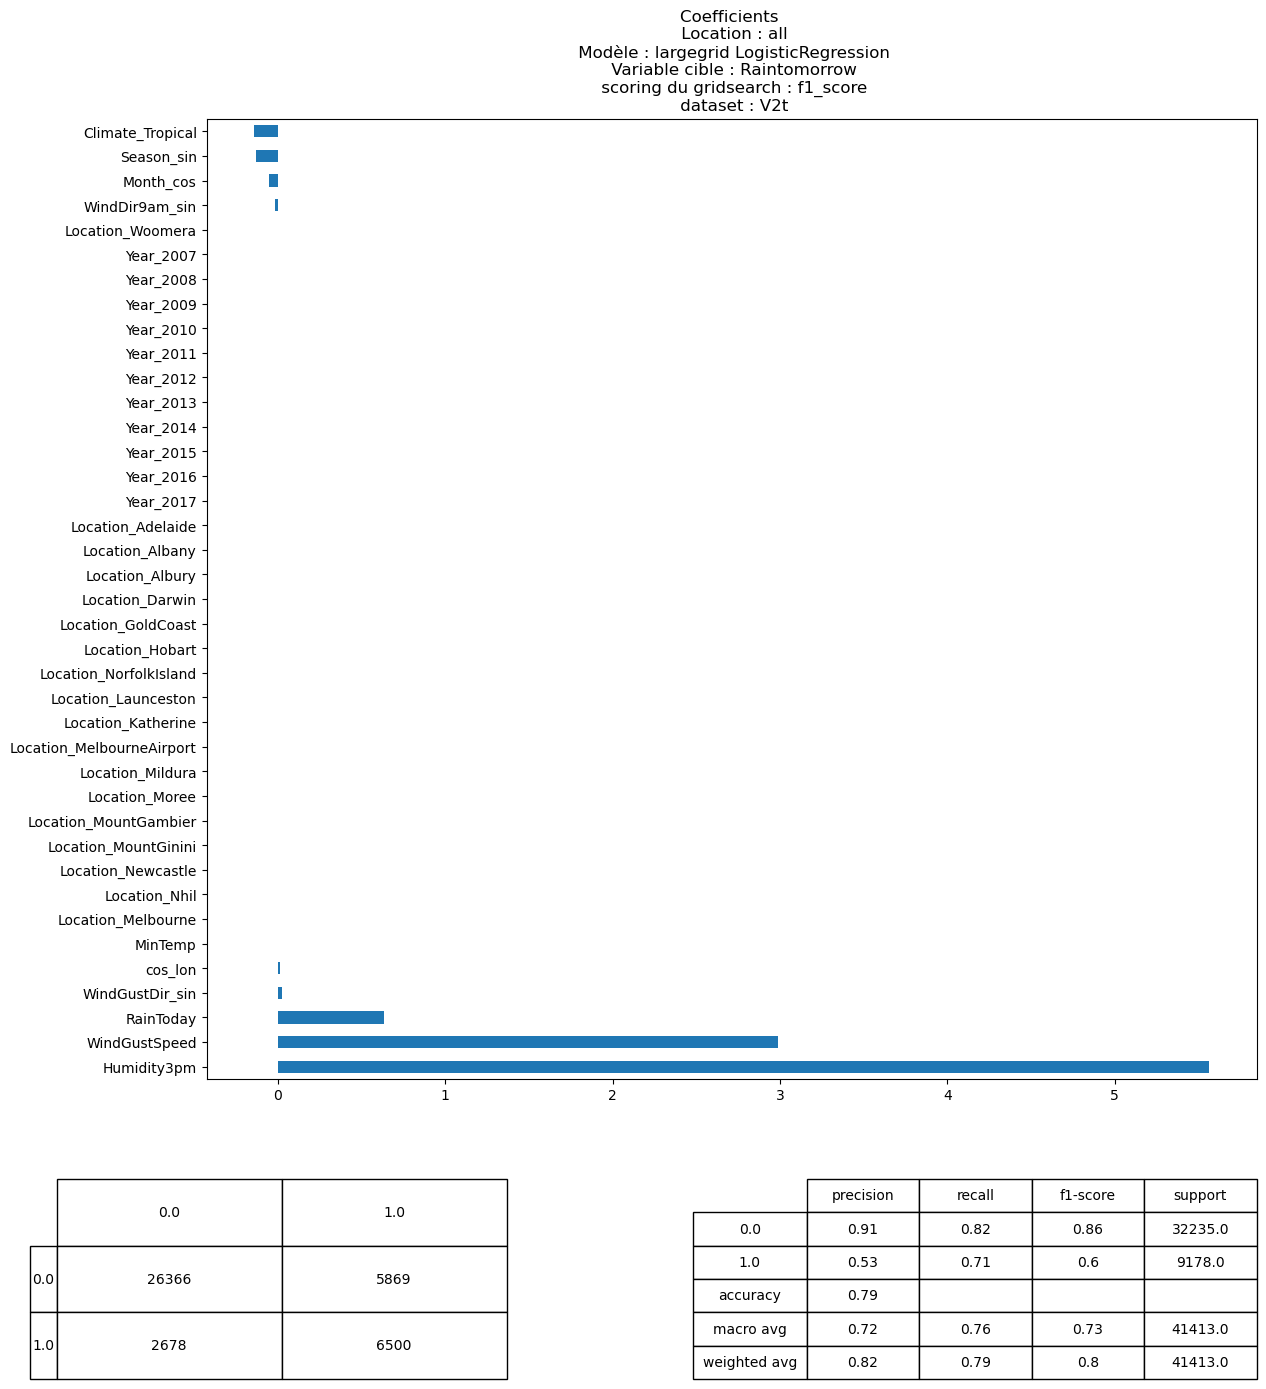

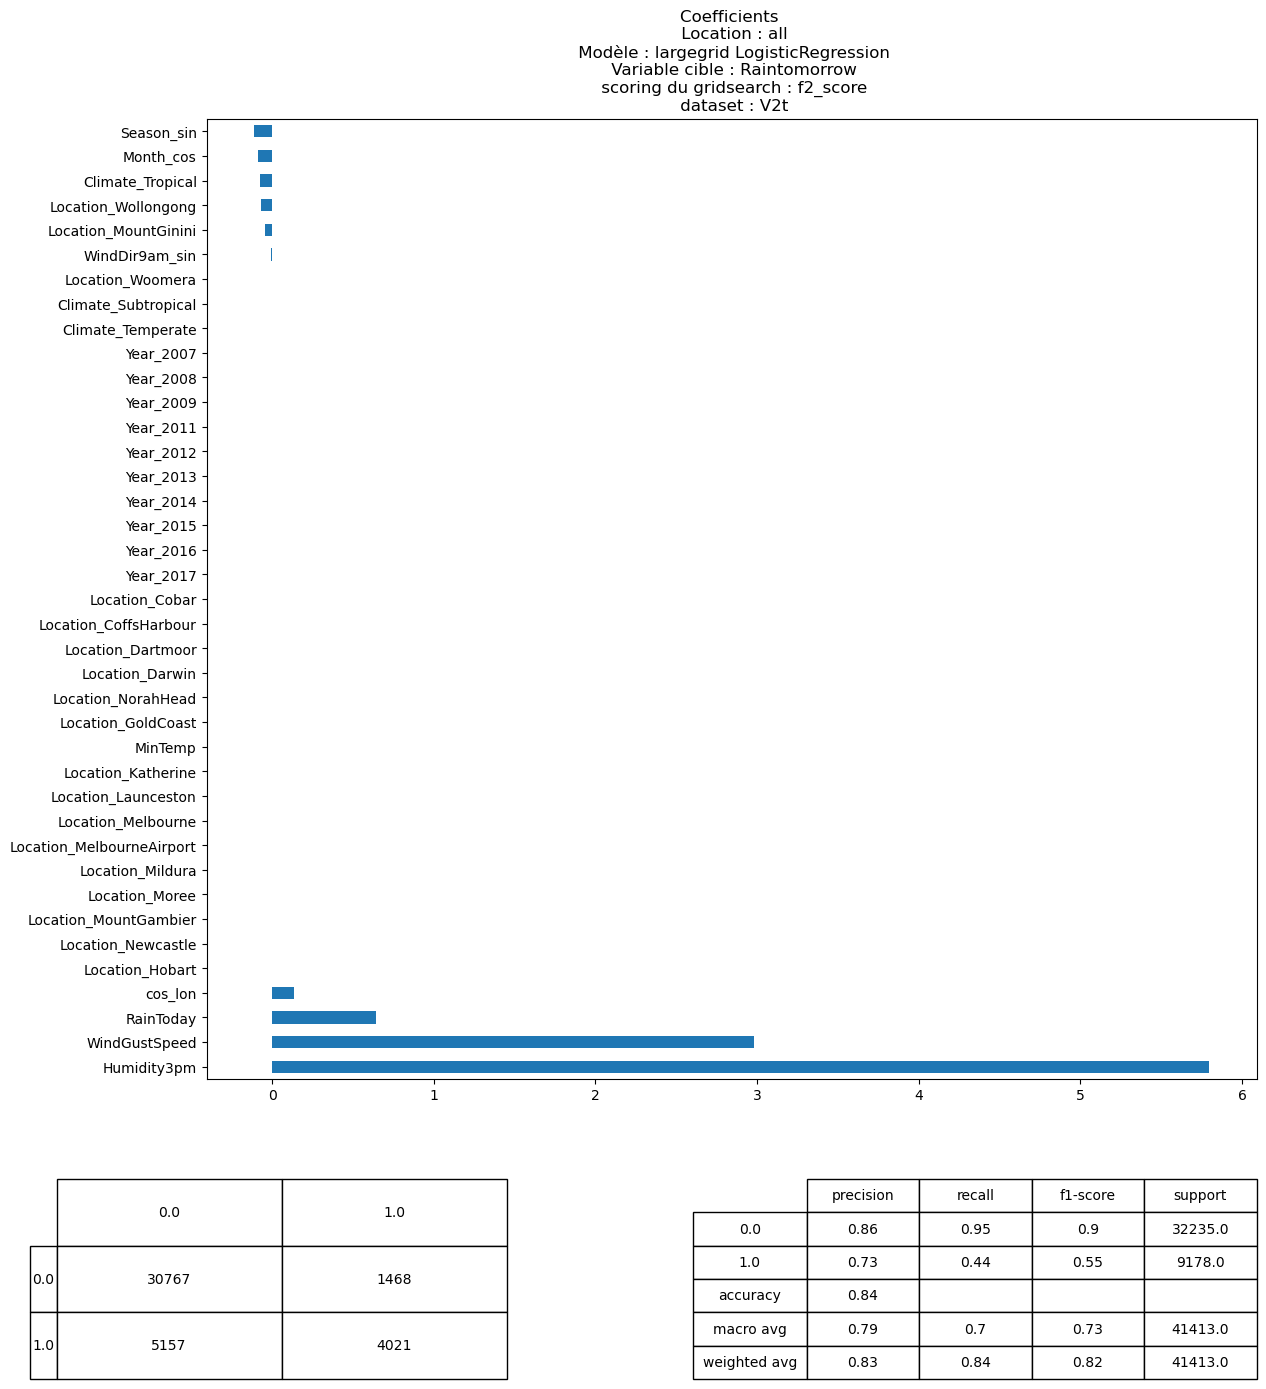

In [13]:
# tuning LR plus large (param_grids2) sur V2 (prend 120 min)
model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)
dataset = "V2t"
modeling_batch = "largegrid"

# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f2_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1)}

variable_cible = "Raintomorrow"
param_grids = param_grids2
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t


mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                    grid_metrics, variable_cible,
                    X_train_search, X_test_search, y_train_search, y_test_search, 
                    n_coef_graph)
    

{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 0.01, 'class_weight': {0: 0.495, 1: 0.505}, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}, 'best_cv_score': 0.8336972228374943, 'test_accuracy': 0.8400260787675368, 'test_f1_score': 0.5483057203245381, 'test_precision': 0.7325560211331754, 'test_recall': 0.43811287862279363}}}
LogisticRegression(C=0.01, class_weight={0: 0.495, 1: 0.505}, max_iter=500,
                   n_jobs=-1, penalty='l1', solver='saga')
0.8336972228374943
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0              0.04          0.00             0.00            0.00     0.00   
1              0.04          0.00             0.00            0.00     0.00   
2              0.04          0.00             0.00            0.00     0.00   
3              0.04          0.00             0.00            0.00     0.00   
4              0.05          0.01             0.00            0.00     0.00   
...

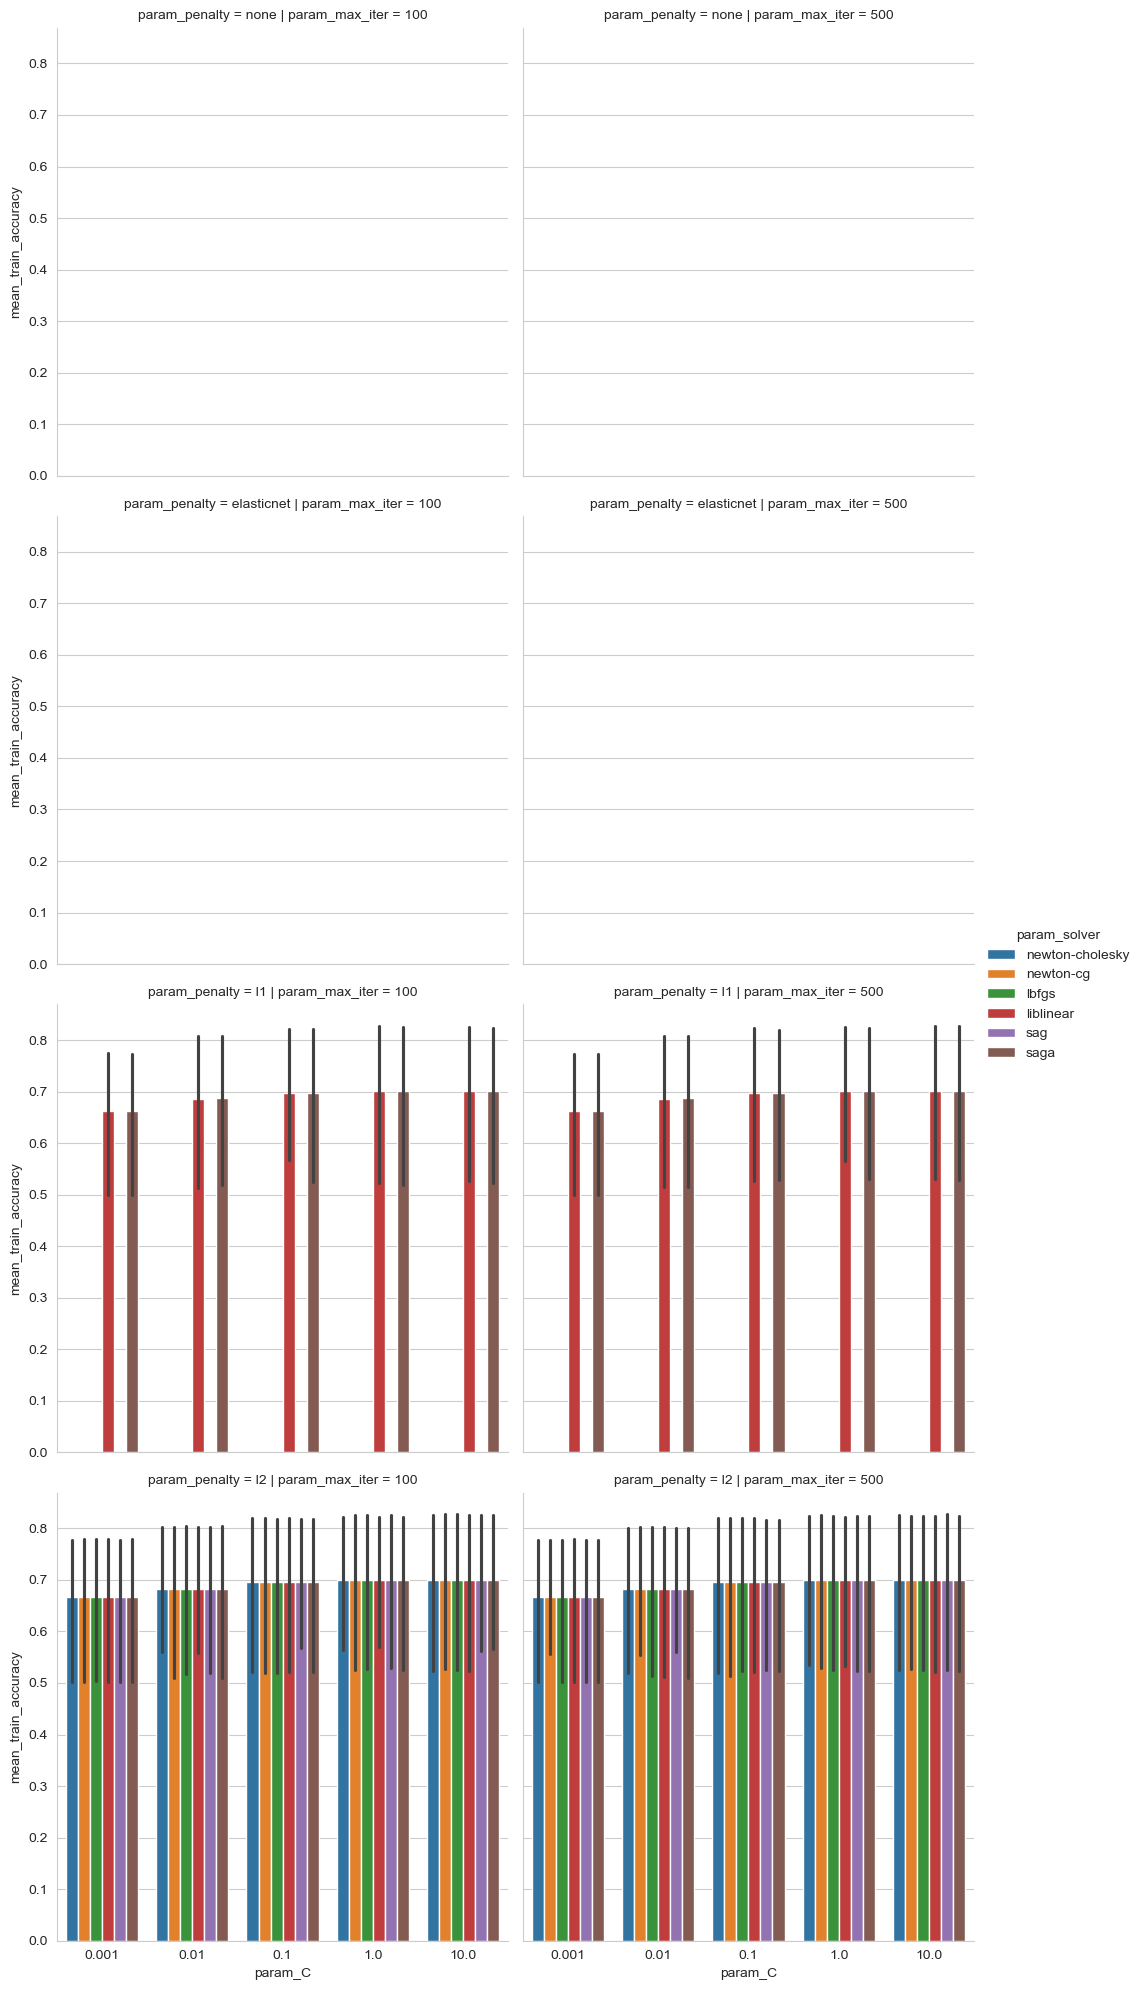

## 3) Tuning RandomForest et Balanced RandomForest

### Données V2

In [29]:
# tuning simple sur V2

model_list ={
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1)
}

dataset = "V2t"
modeling_batch = "simplegrid"
# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f05_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1),
                "f2_score" : make_scorer(fbeta_score, beta=2, pos_label=1)}
variable_cible = "Raintomorrow"
param_grids = param_grids1
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t

for model_name, model in model_list.items() : 

    mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                        grid_metrics, variable_cible,
                        X_train_search, X_test_search, y_train_search, 
                        y_test_search,  n_coef_graph)


NameError: name 'param_grids1' is not defined

### Données V3

Métrique de recherche : accuracy
Optimizing RandomForestClassifier


GridSearchCV
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Fitting  RandomForestClassifier_tuned


Nom du modèle : RandomForestClassifier_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.85    0.96      0.90 29559.00
1.0                0.72    0.41      0.53  8367.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.79    0.68      0.71 37926.00
weighted avg       0.82    0.84      0.82 37926.00
Matrice de confusion :
       0.00  1.00
0.00  28239  1320
1.00   4915  3452
Métrique de recherche : average_precision
Optimizing RandomForestClassifier


GridSearchCV
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Fitting  RandomForestClassifier_tuned


Nom du modèle : RandomForestClassifier_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.88    0.88      0.88

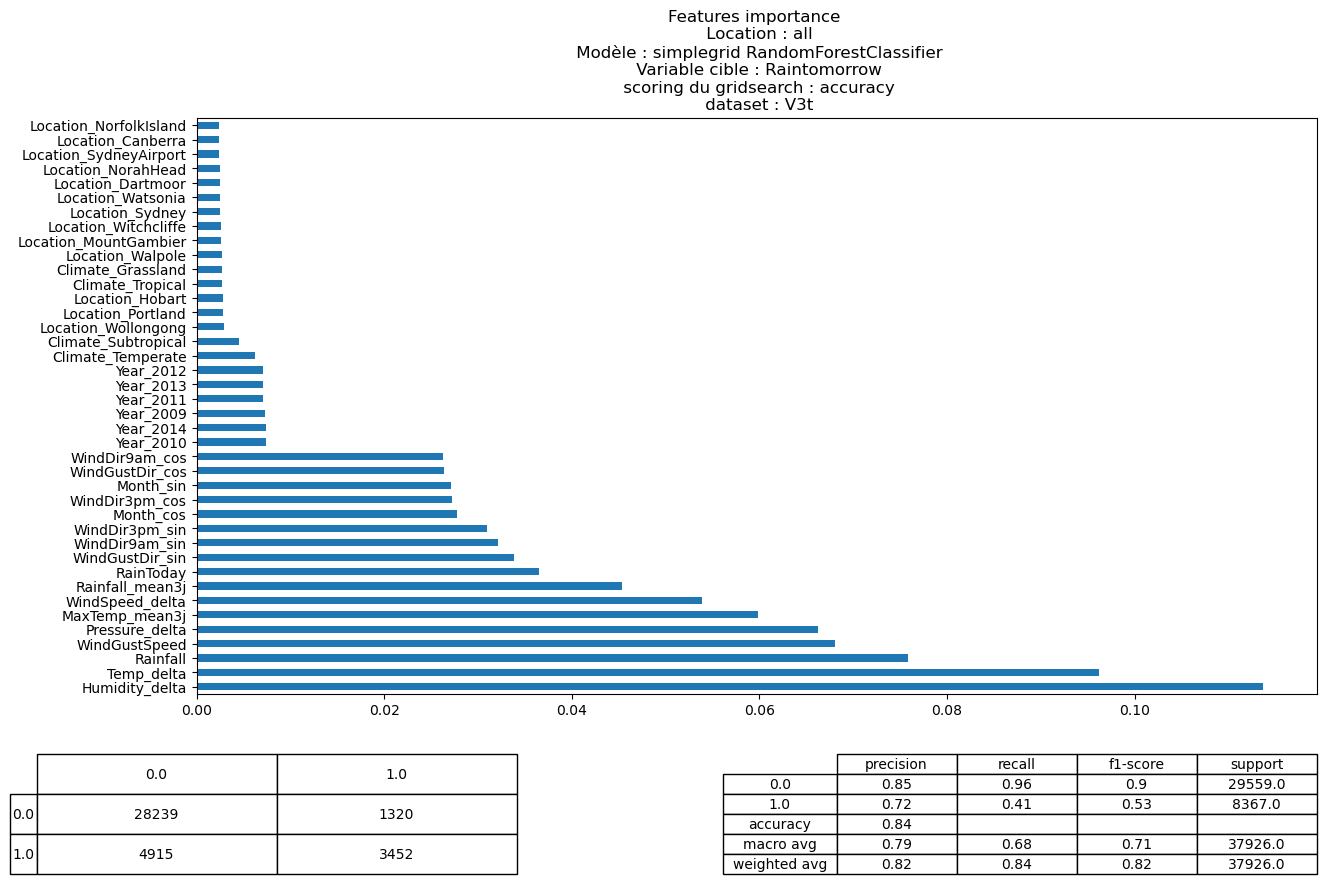

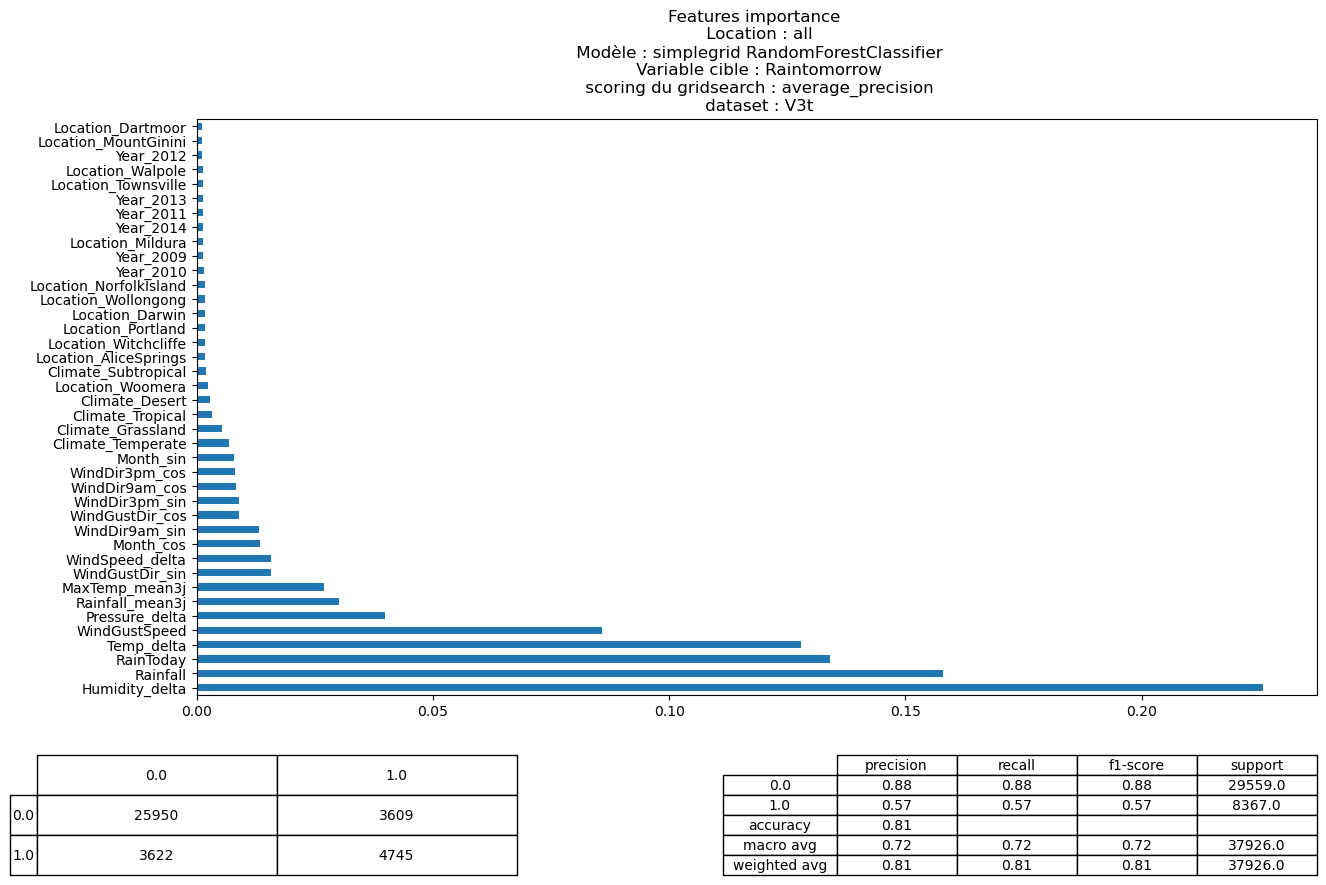

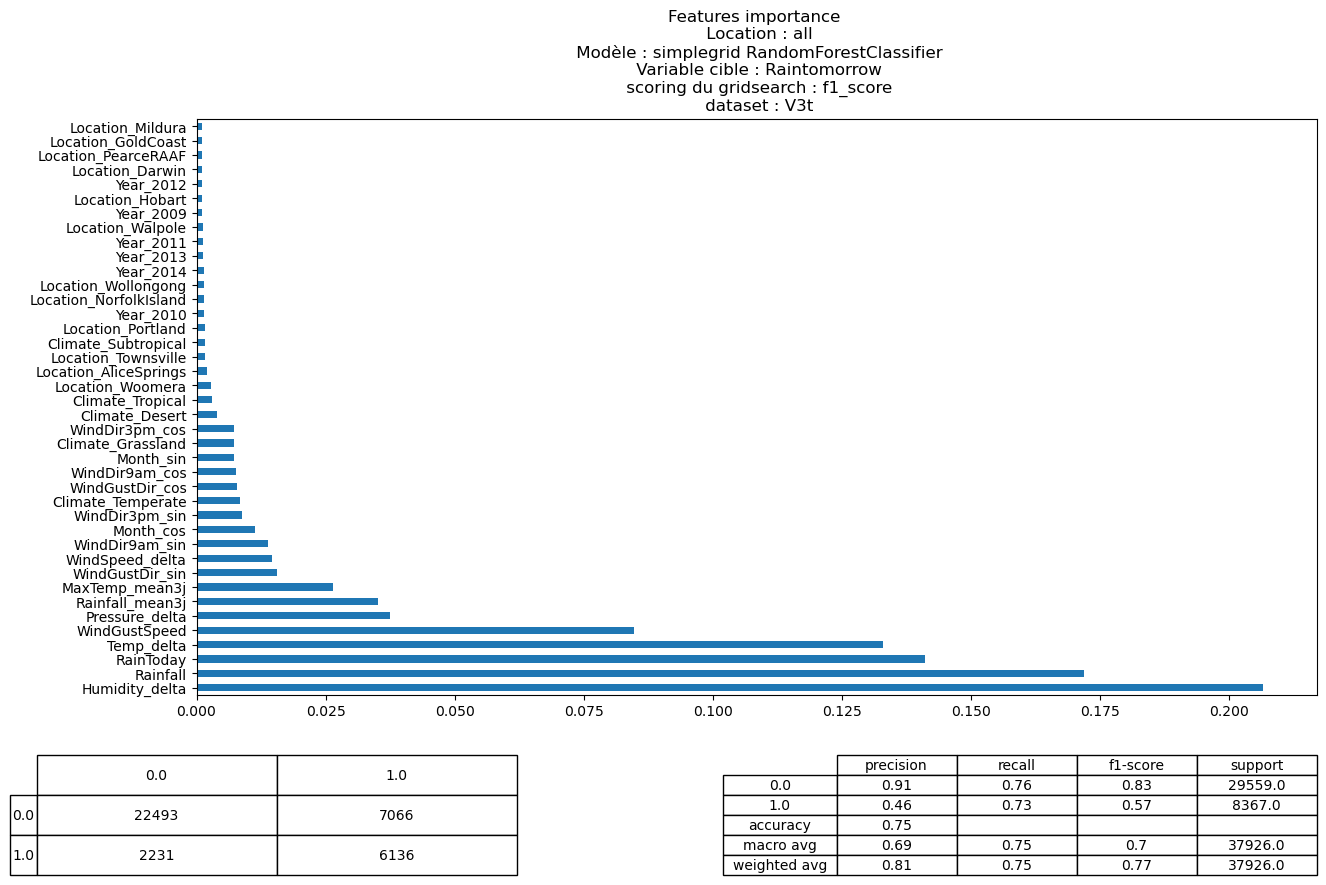

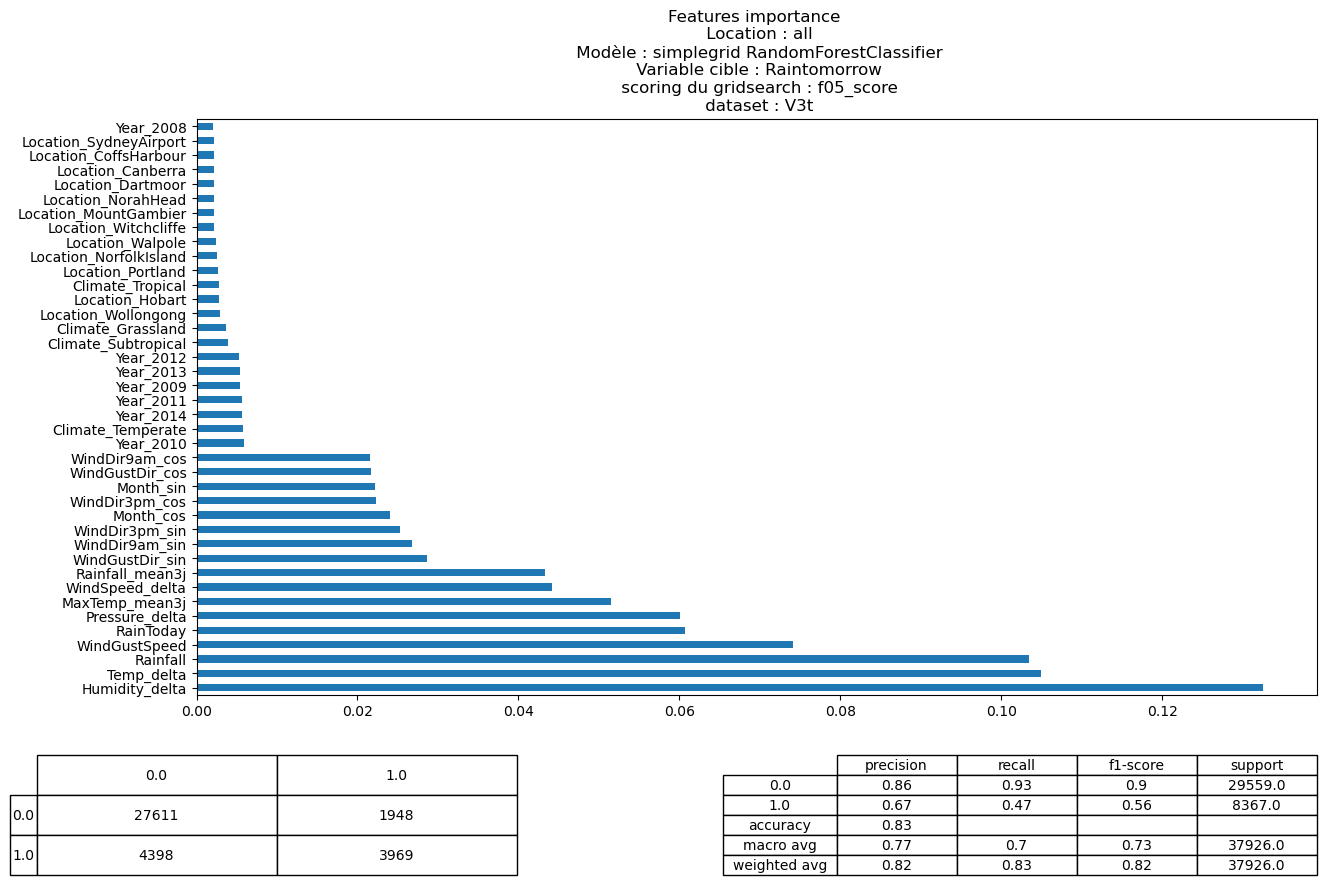

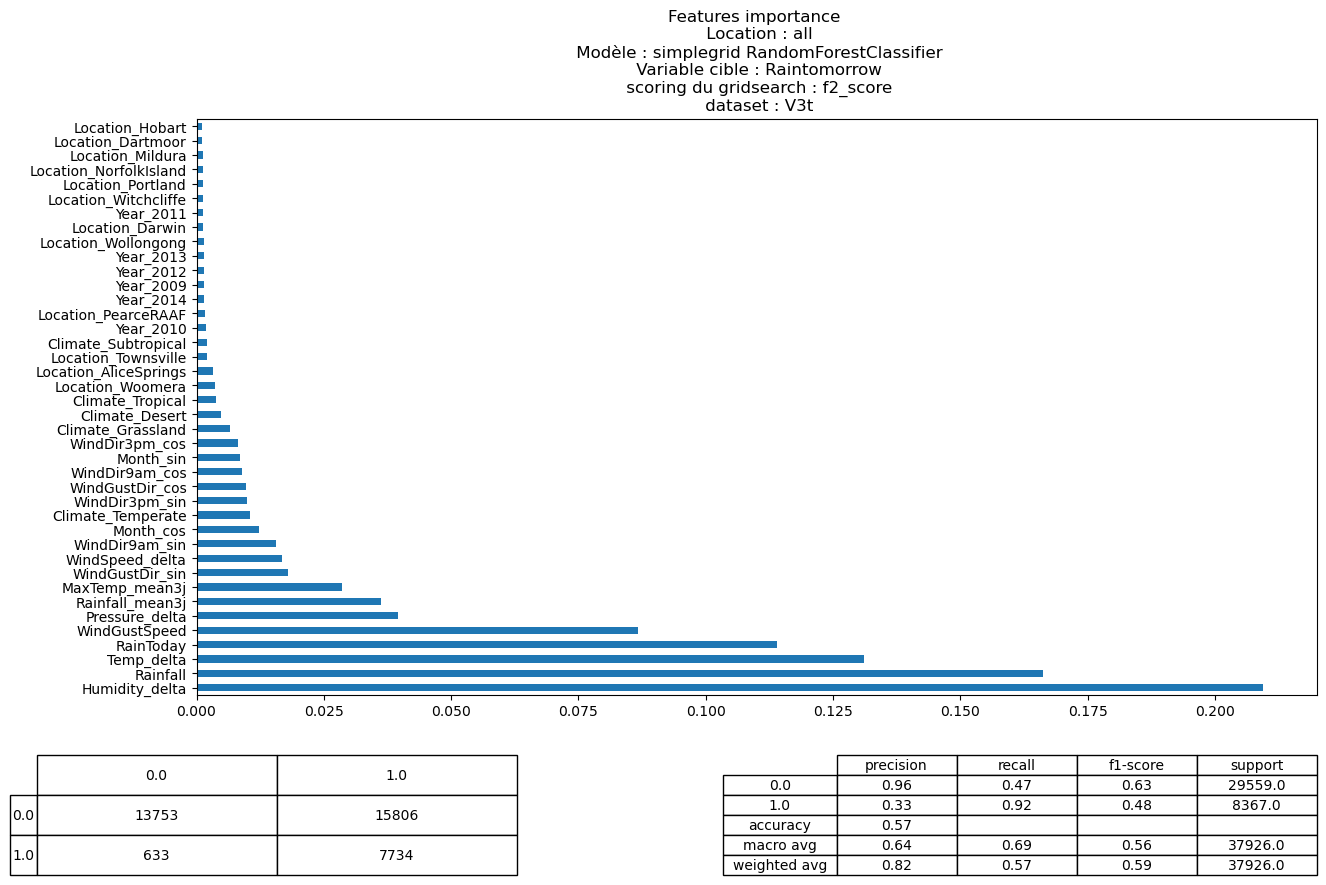

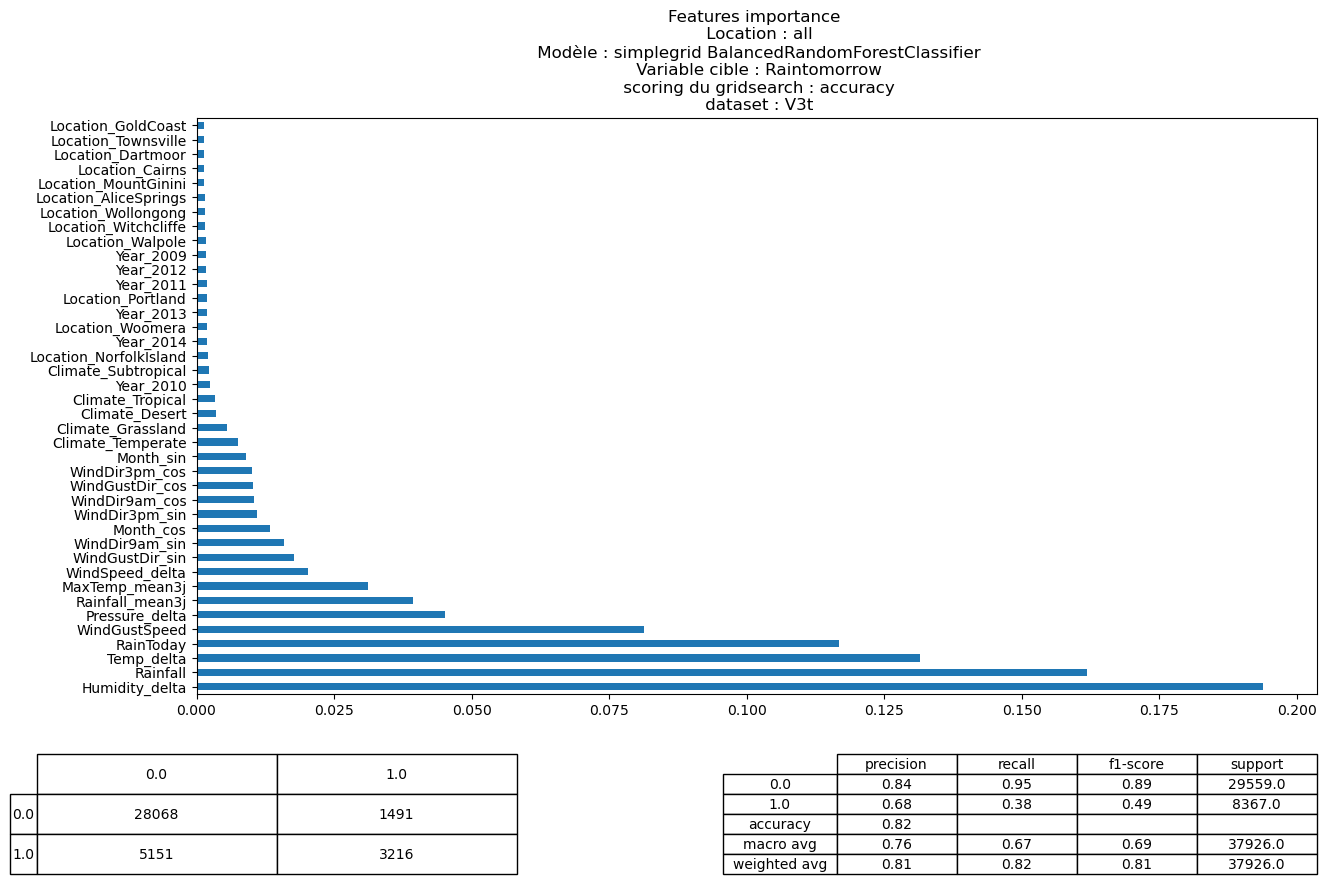

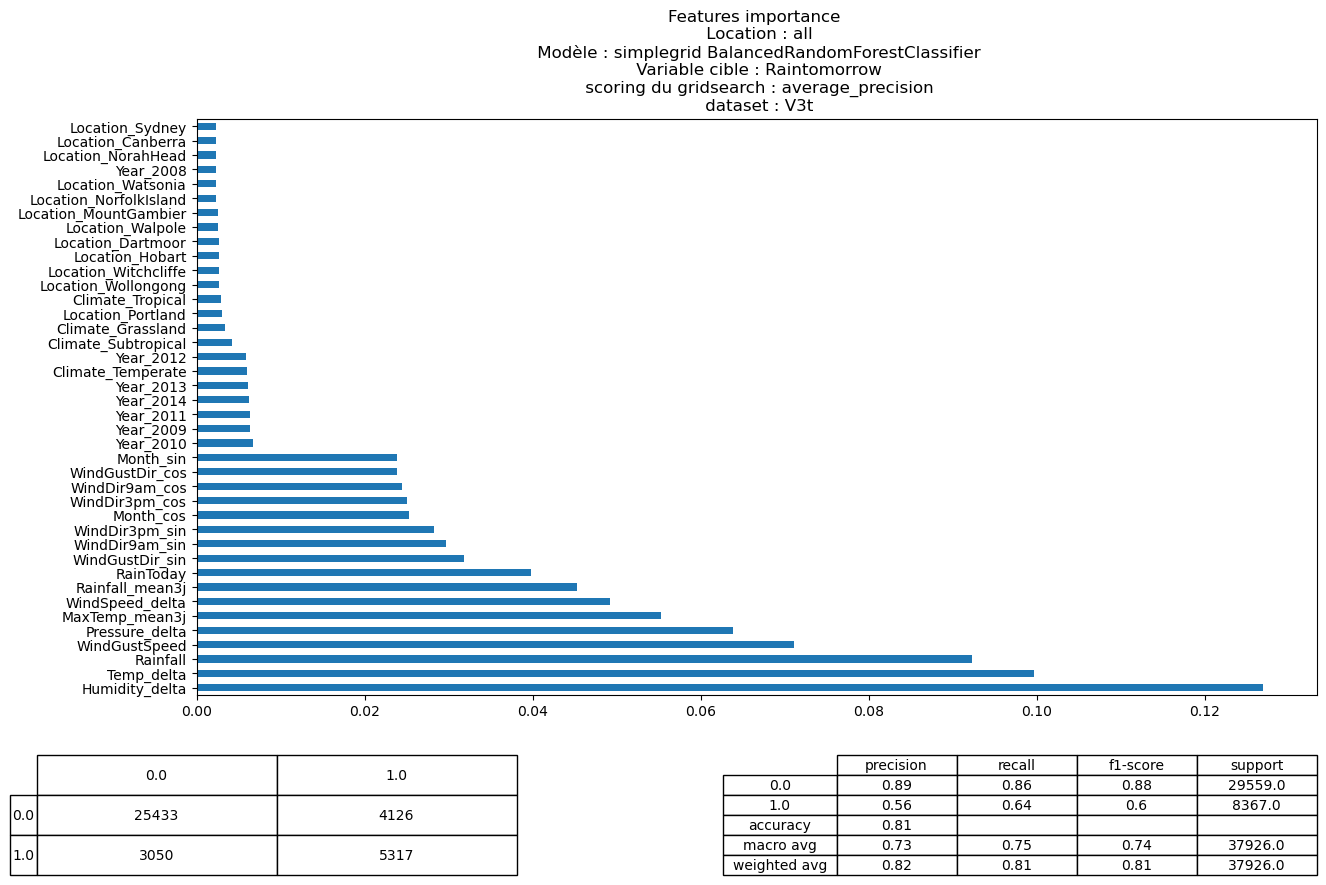

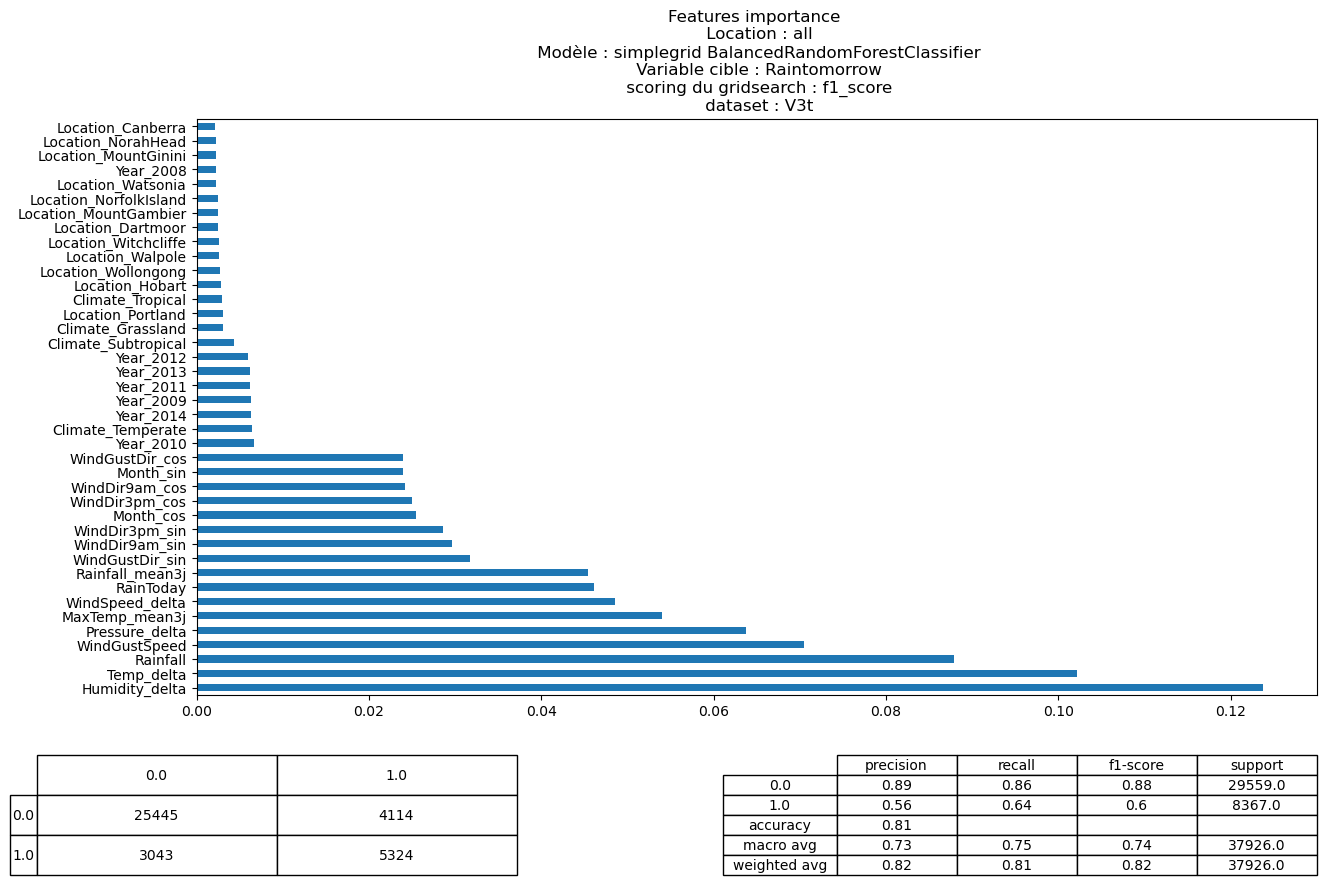

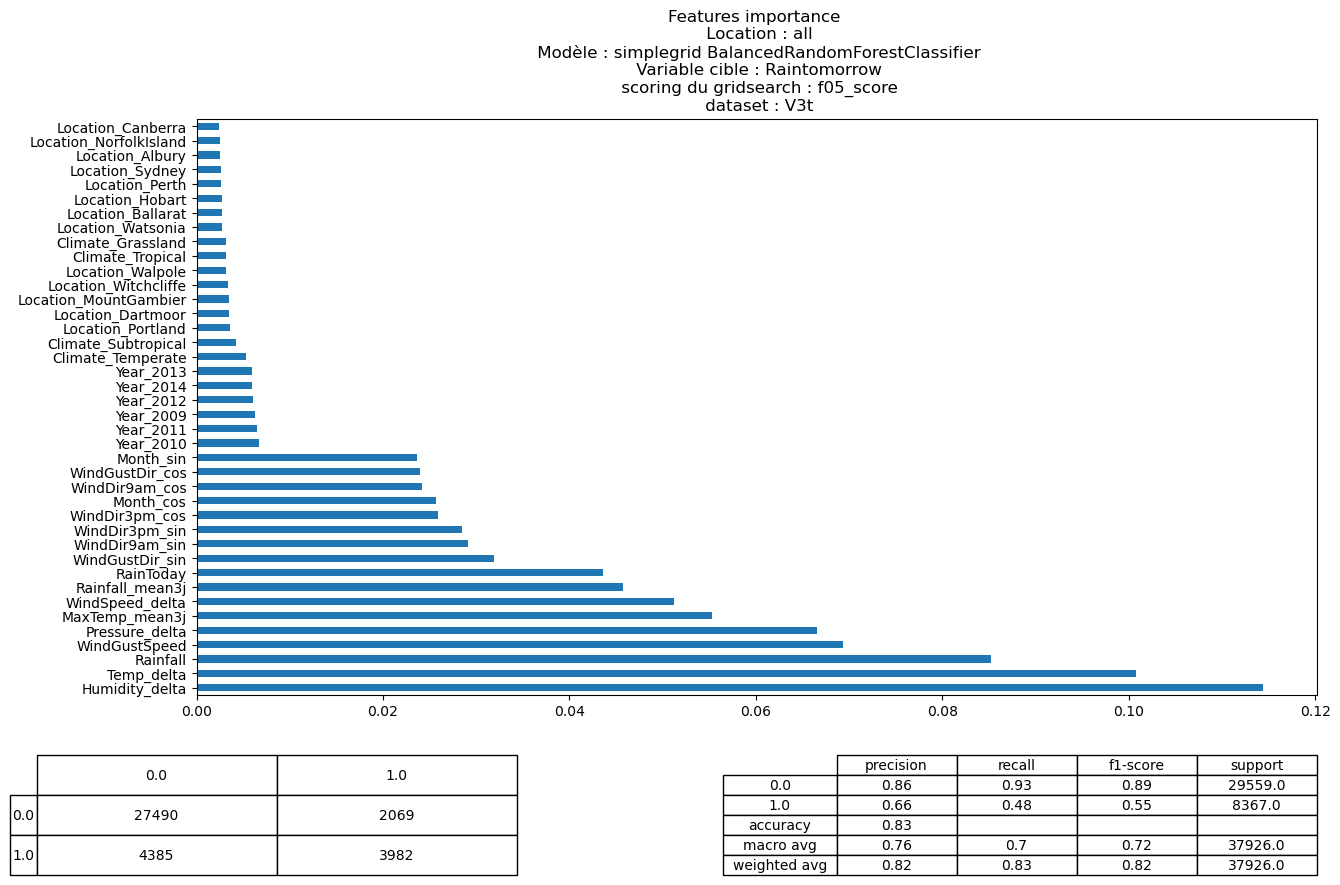

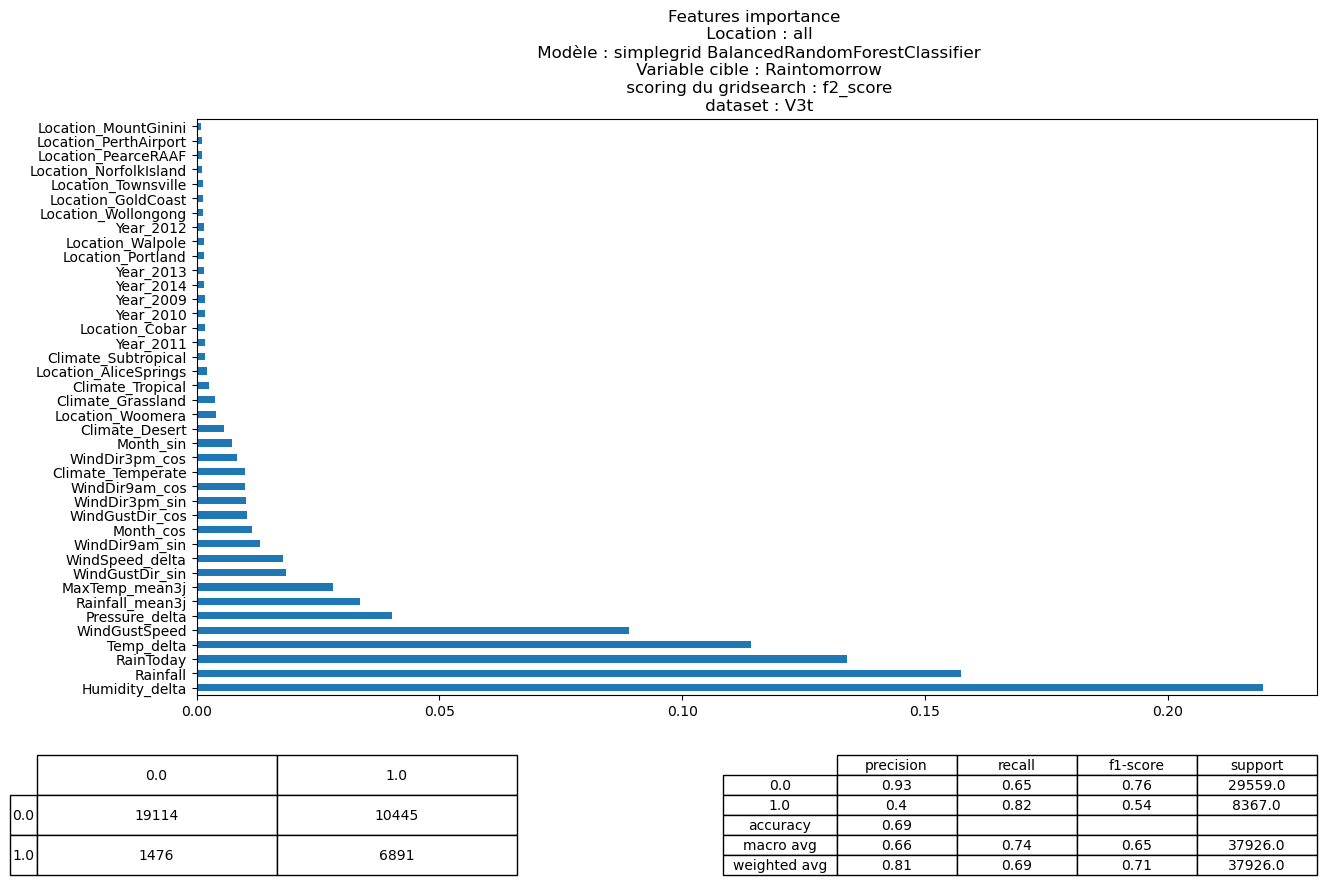

In [14]:
# tuning simple sur V3 (500 minutes !)

model_list ={
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1)
}

dataset = "V3t"
modeling_batch = "simplegrid"
# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f05_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1),
                "f2_score" : make_scorer(fbeta_score, beta=2, pos_label=1)}
variable_cible = "Raintomorrow"
param_grids = param_grids1
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V3t_scaled, X_test_V3t_scaled, y_train_V3t,  y_test_V3t

for model_name, model in model_list.items() : 

    mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                        grid_metrics, variable_cible,
                        X_train_search, X_test_search, y_train_search, 
                        y_test_search,  n_coef_graph)

## 4) tuning Bagging et BalancedBagging

### Données V2

Métrique de recherche : accuracy
Optimizing BaggingClassifier


GridSearchCV
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting  BaggingClassifier_tuned


Nom du modèle : BaggingClassifier_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.97      0.91 32235.00
1.0                0.79    0.45      0.57  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.71      0.74 41413.00
weighted avg       0.84    0.85      0.83 41413.00
Matrice de confusion :
       0.00  1.00
0.00  31133  1102
1.00   5091  4087
Métrique de recherche : average_precision
Optimizing BaggingClassifier


GridSearchCV
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting  BaggingClassifier_tuned


Nom du modèle : BaggingClassifier_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.96      0.91 32235.00
1.0                0.79   

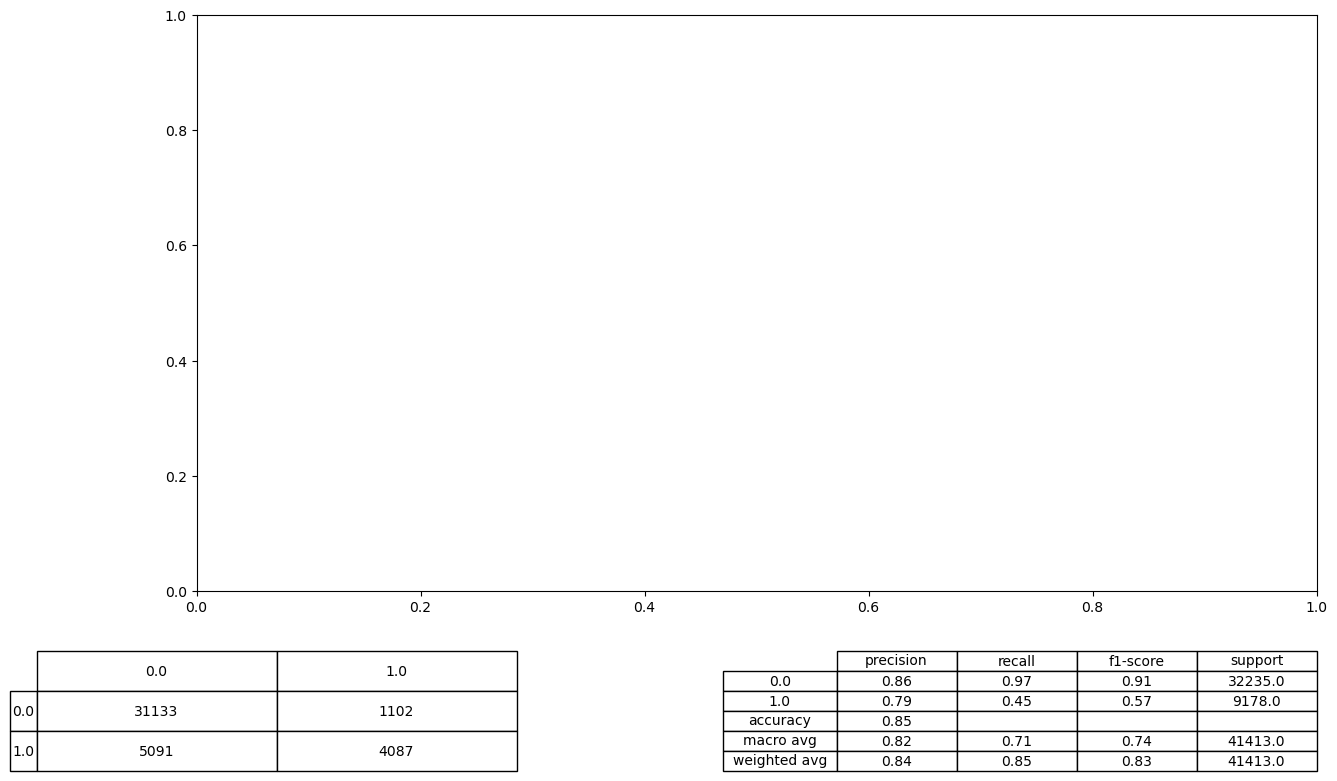

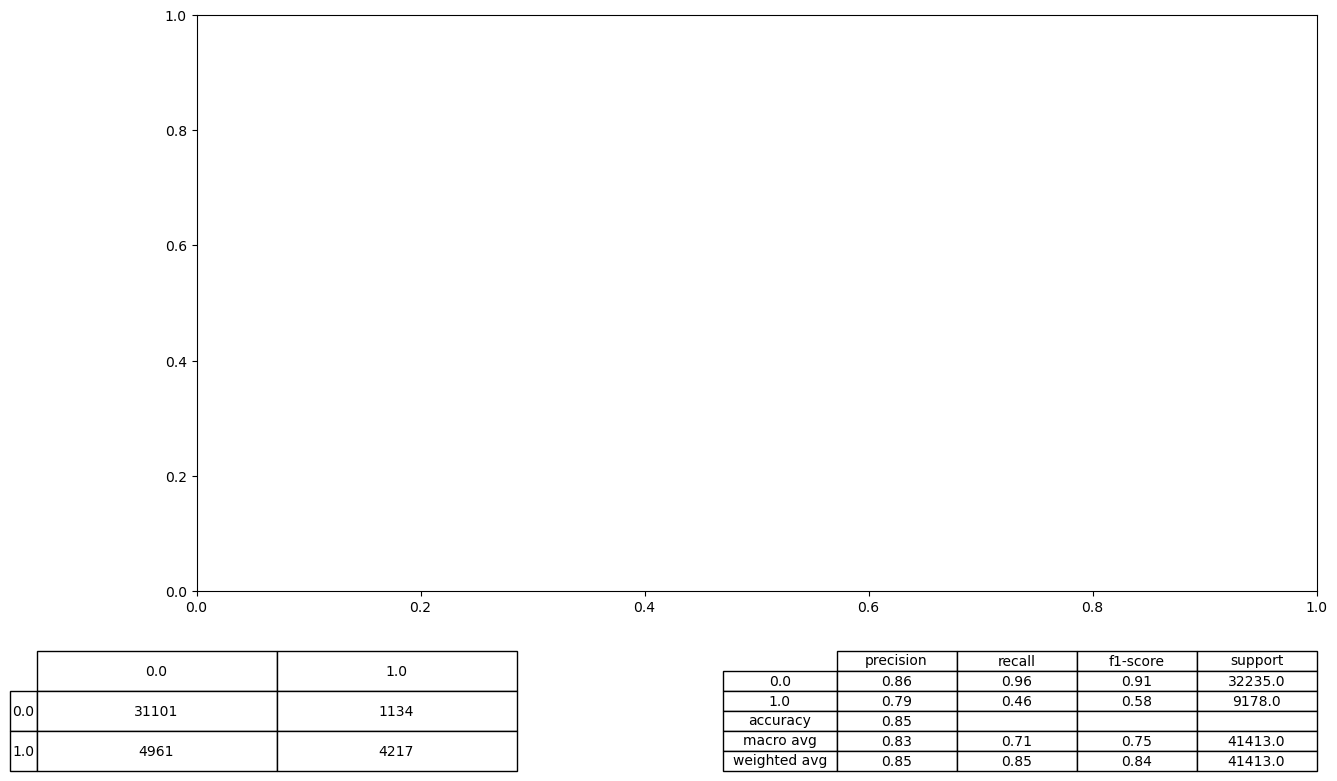

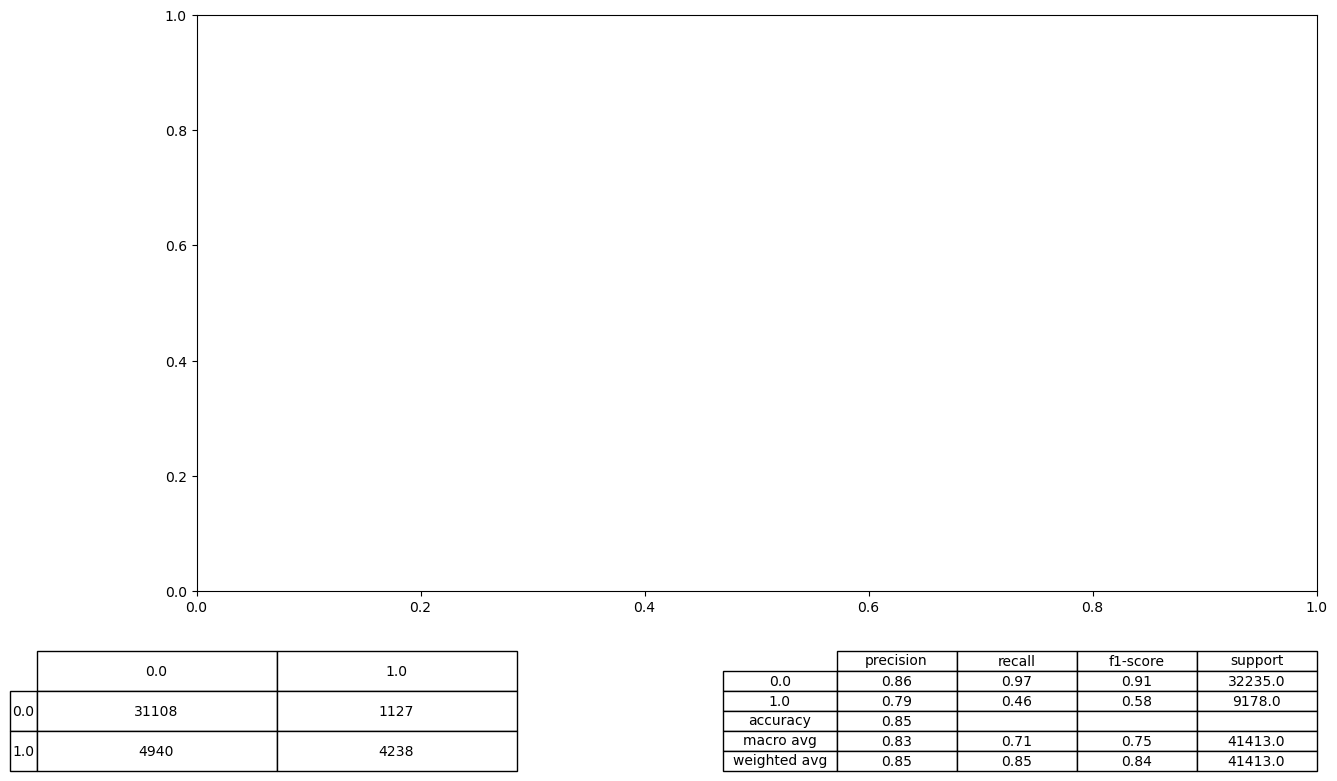

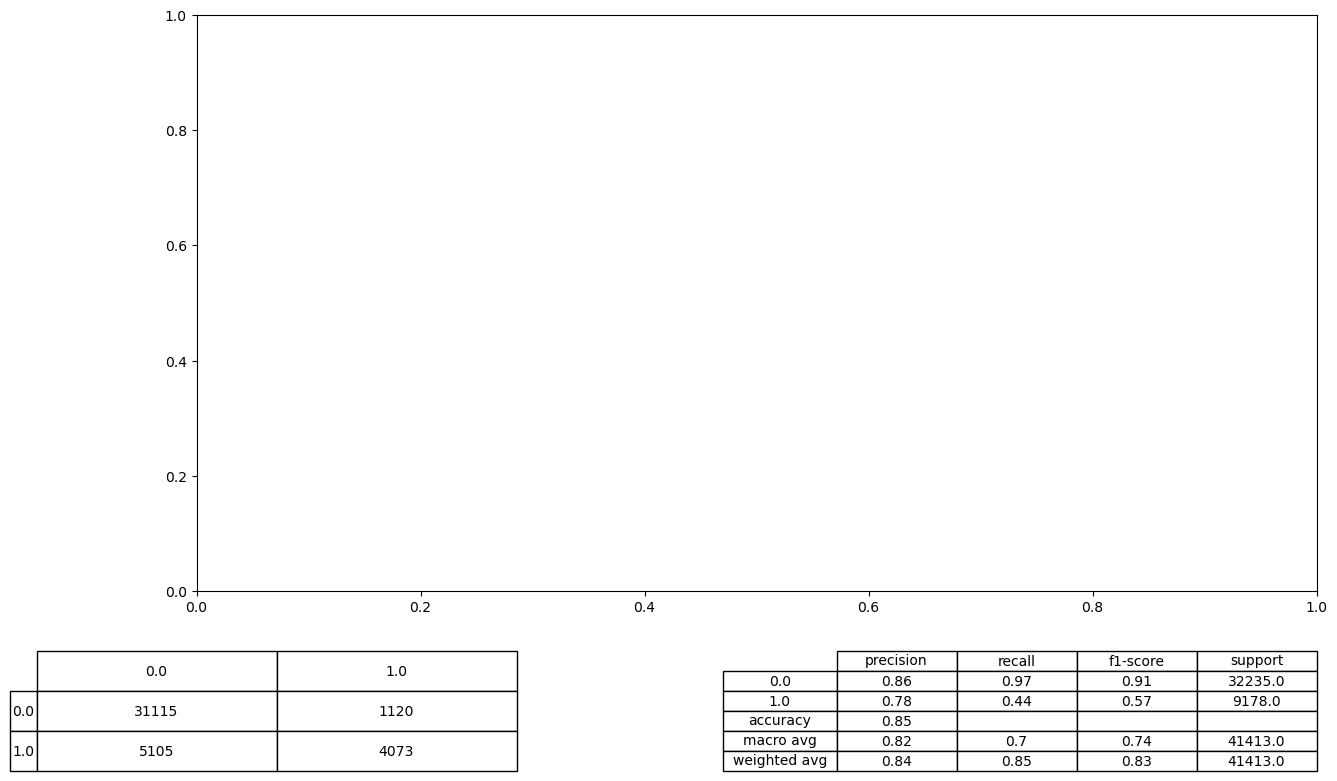

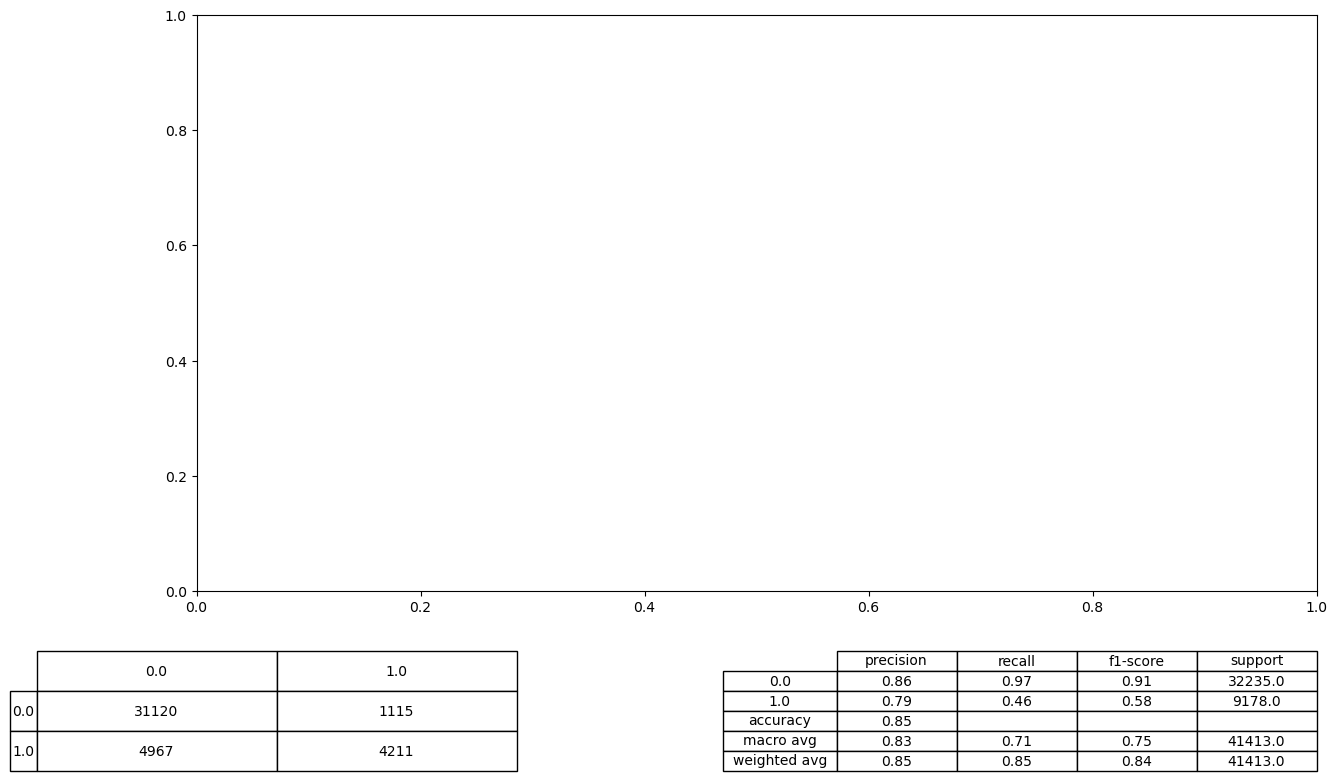

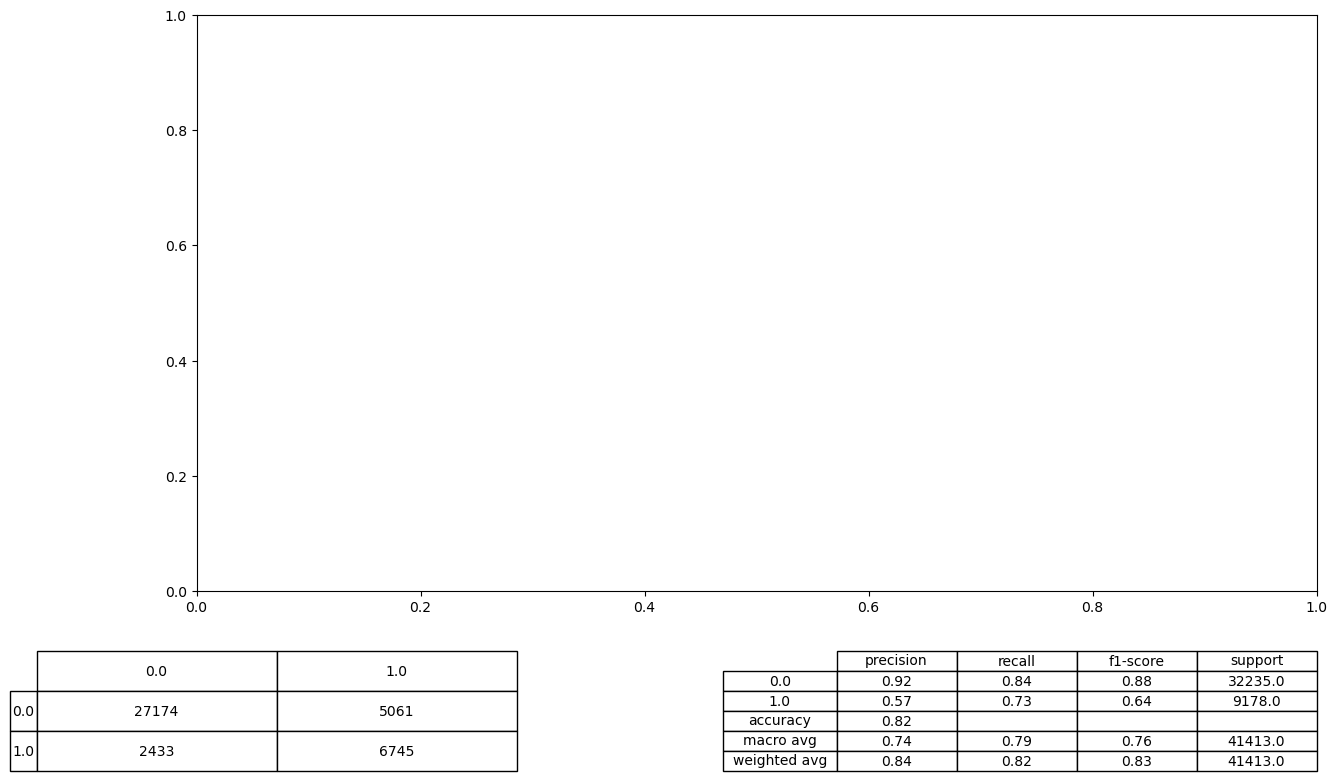

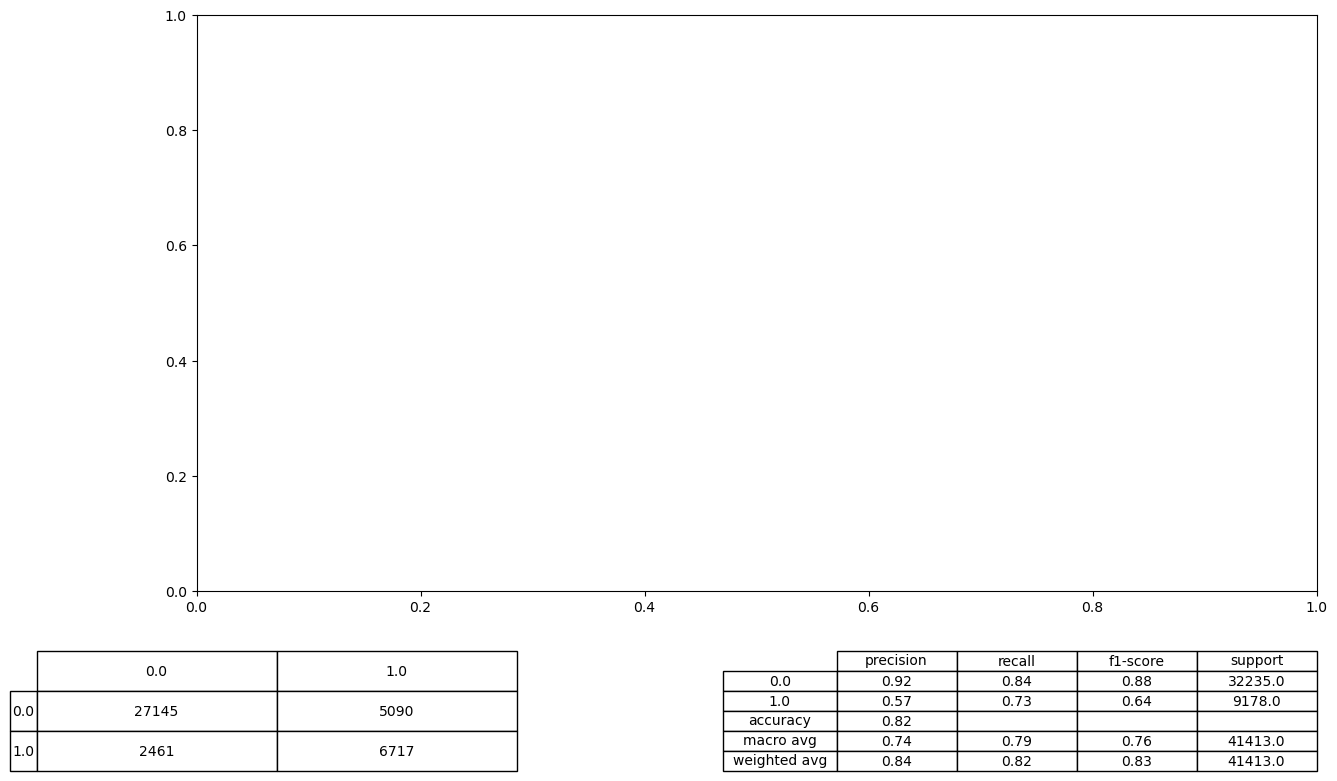

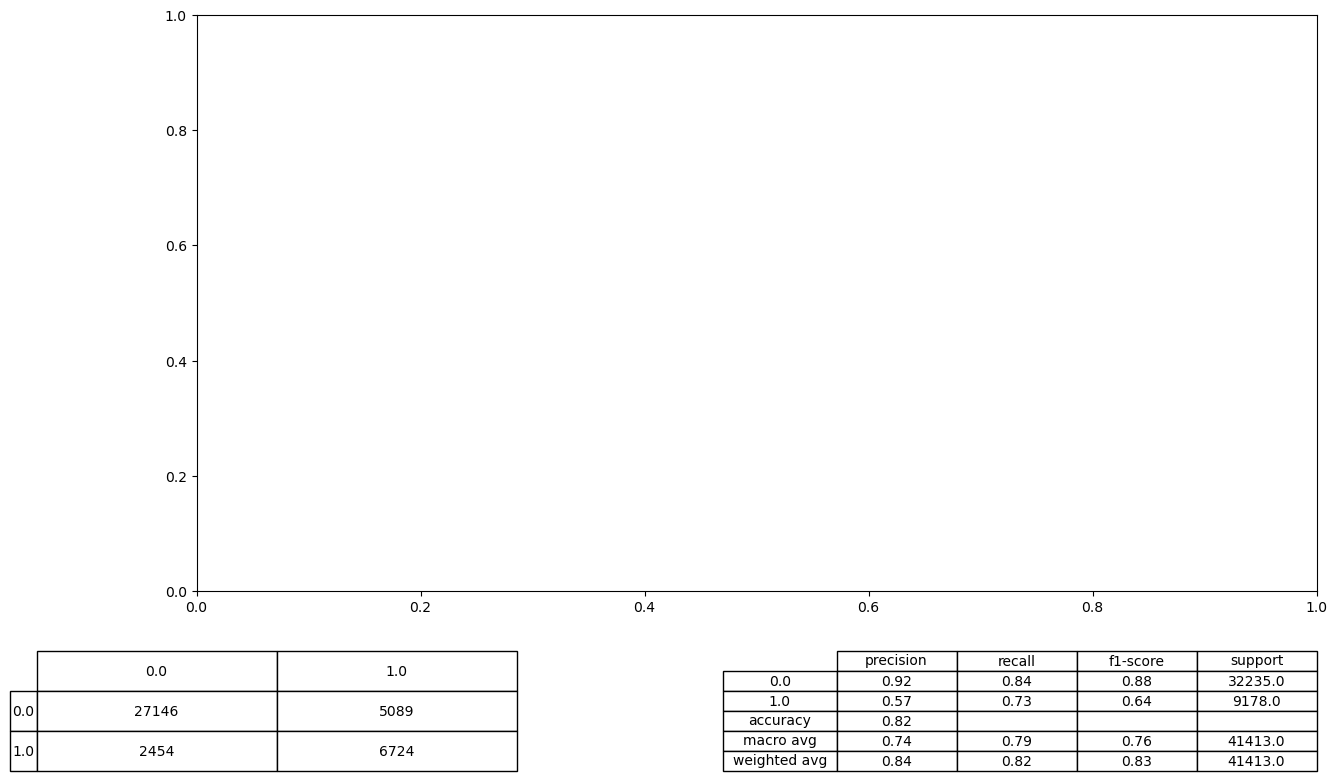

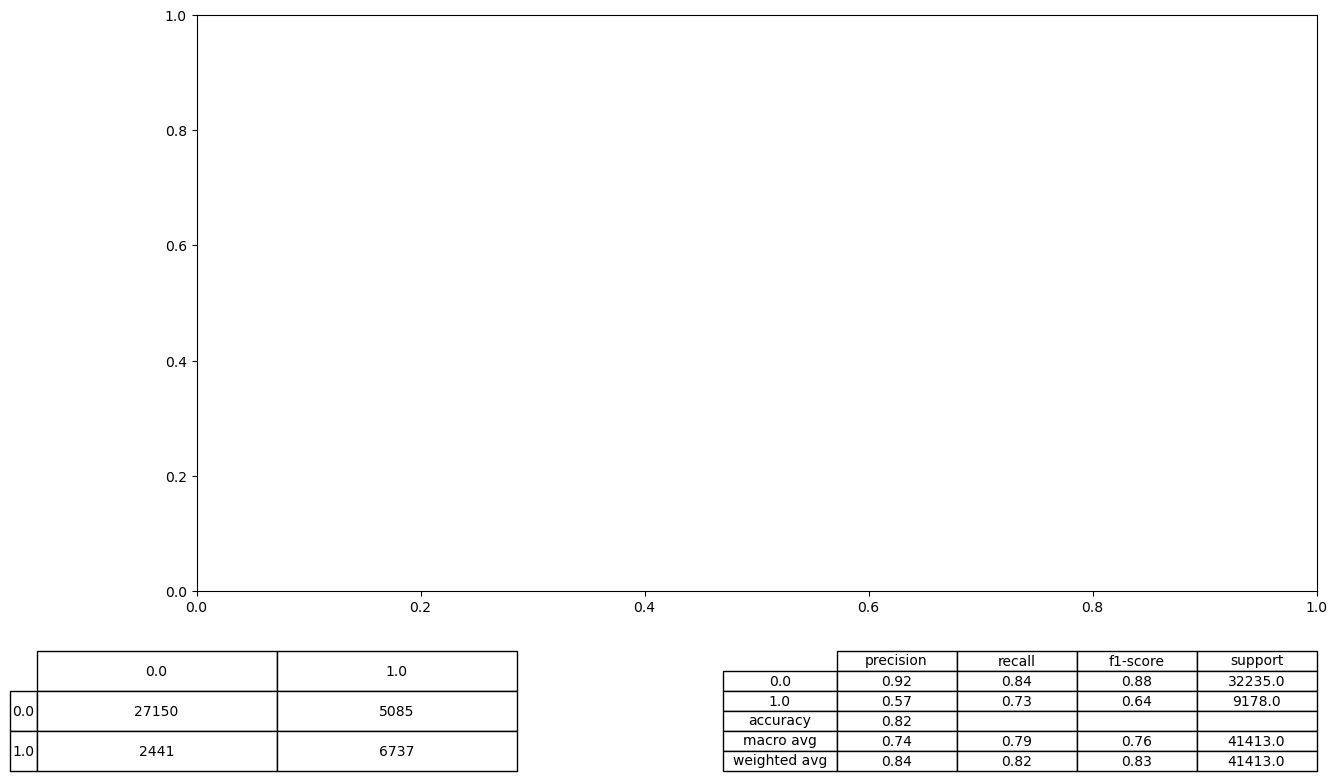

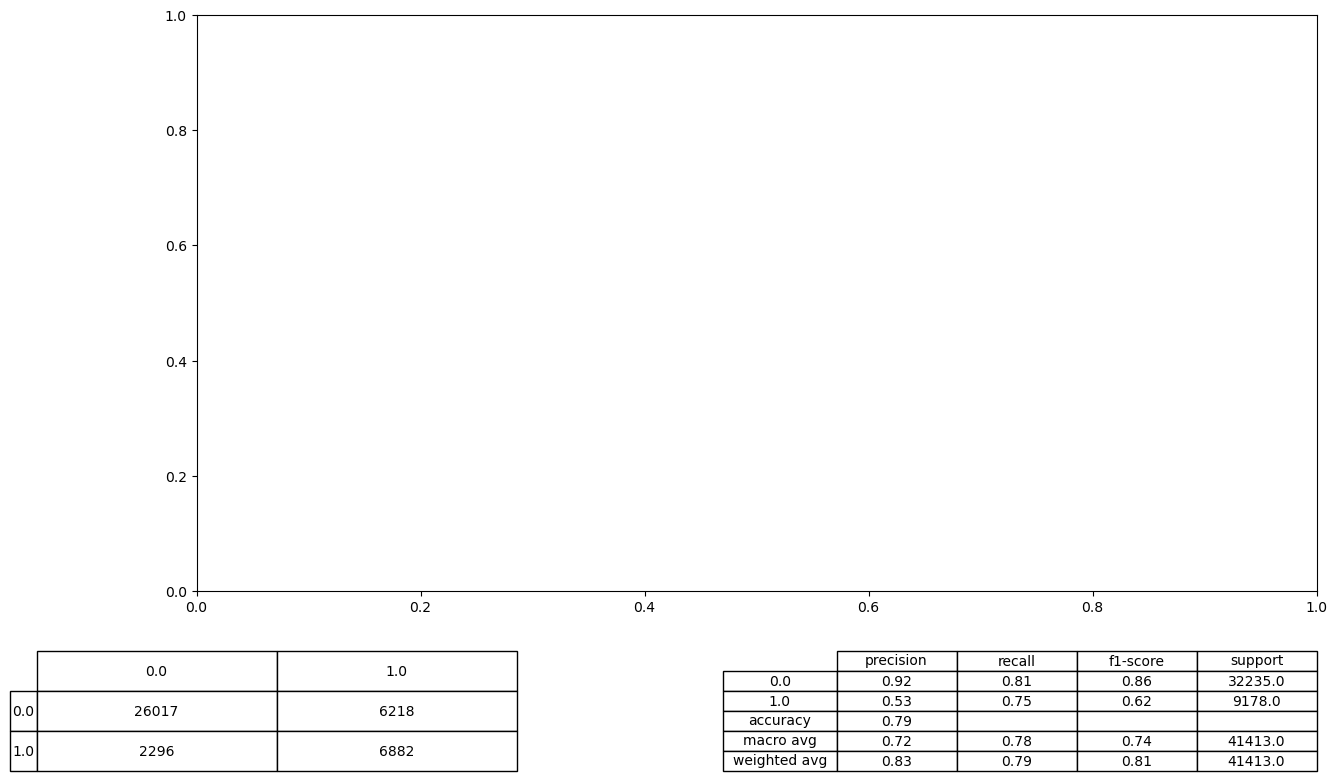

In [67]:
# tuning simple sur V2

model_list ={
    'BaggingClassifier': BaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1)}

dataset = "V2t"
modeling_batch = "simplegrid"
# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f05_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1),
                "f2_score" : make_scorer(fbeta_score, beta=2, pos_label=1)}
variable_cible = "Raintomorrow"
param_grids = param_grids1
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t

for model_name, model in model_list.items() : 

    mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                        grid_metrics, variable_cible, 
                        X_train_search, X_test_search, y_train_search, 
                        y_test_search, n_coef_graph)

### Données V3

Métrique de recherche : accuracy
Optimizing BaggingClassifier


GridSearchCV
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting  BaggingClassifier_tuned


Nom du modèle : BaggingClassifier_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.83    0.97      0.90 29559.00
1.0                0.76    0.31      0.44  8367.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.80    0.64      0.67 37926.00
weighted avg       0.82    0.83      0.80 37926.00
Matrice de confusion :
       0.00  1.00
0.00  28746   813
1.00   5810  2557
Métrique de recherche : average_precision
Optimizing BaggingClassifier


GridSearchCV
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting  BaggingClassifier_tuned


Nom du modèle : BaggingClassifier_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.83    0.97      0.90 29559.00
1.0                0.76   

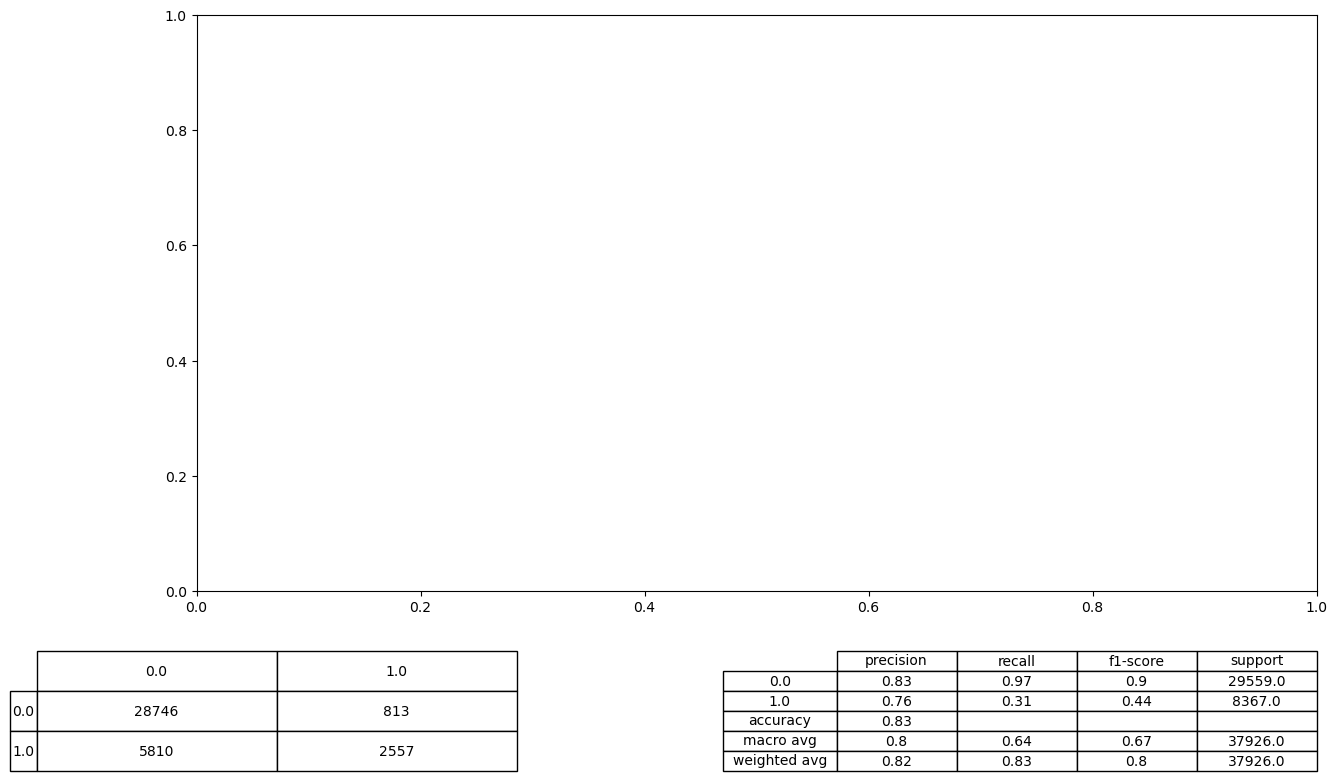

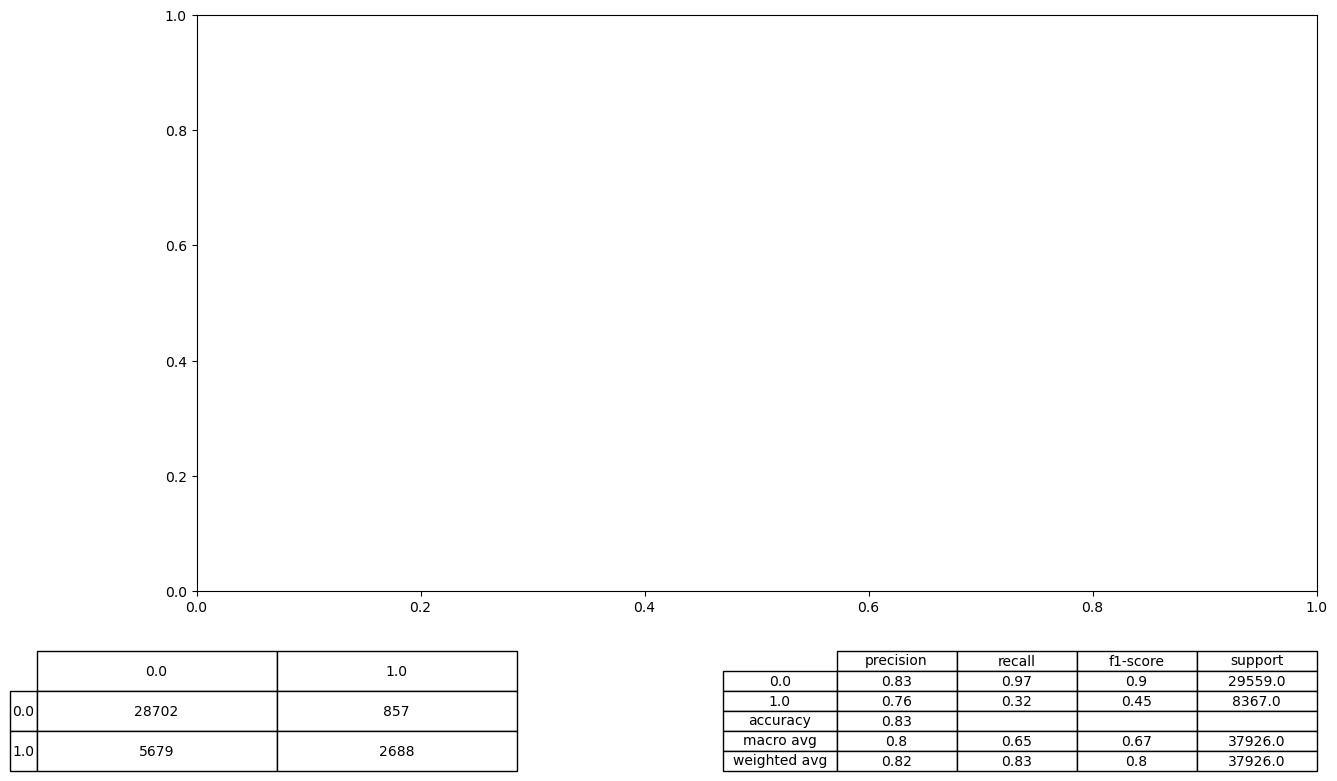

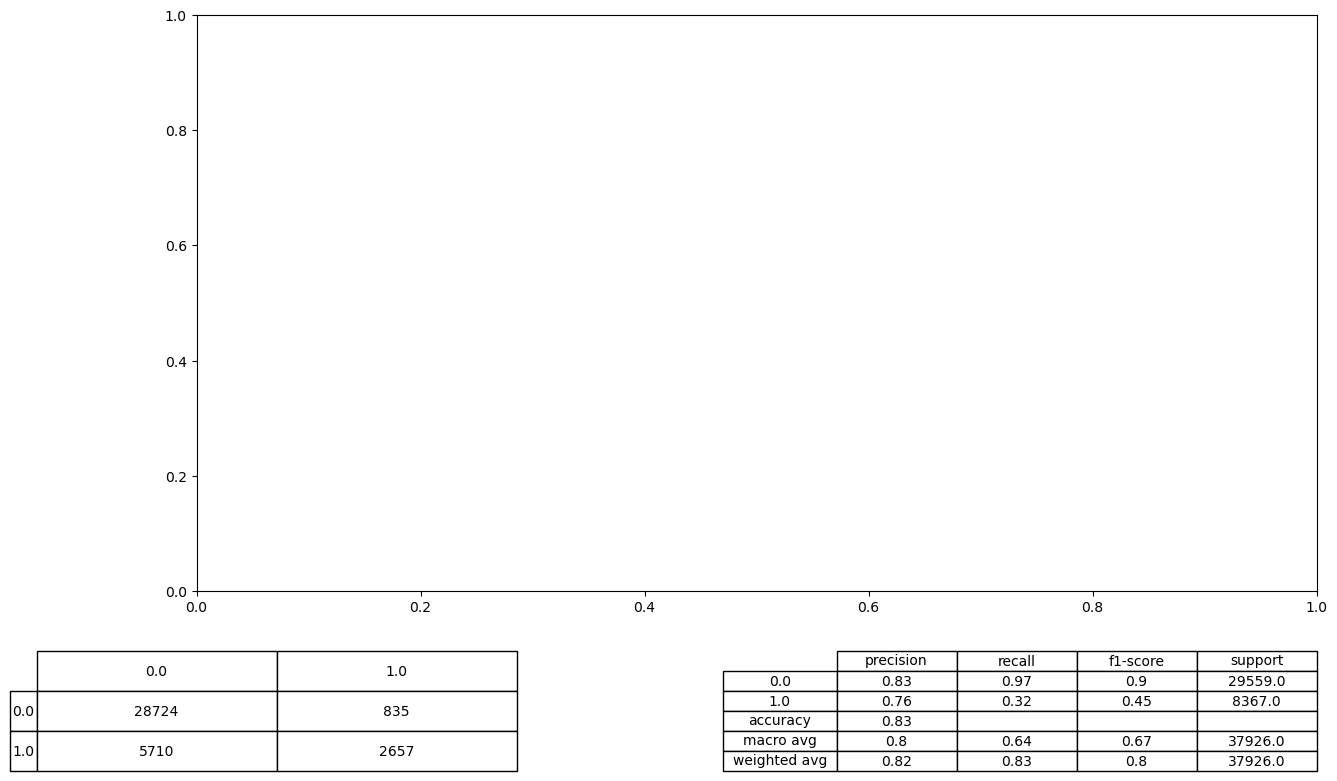

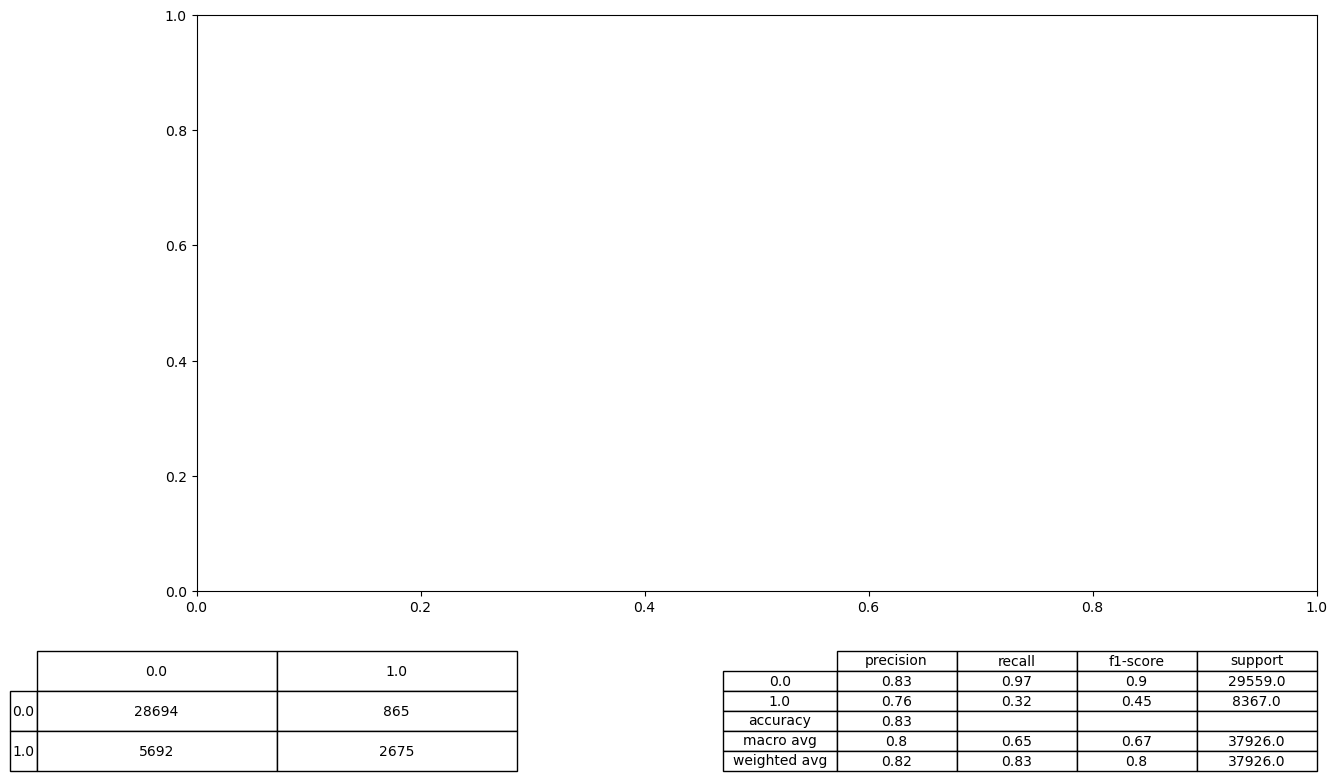

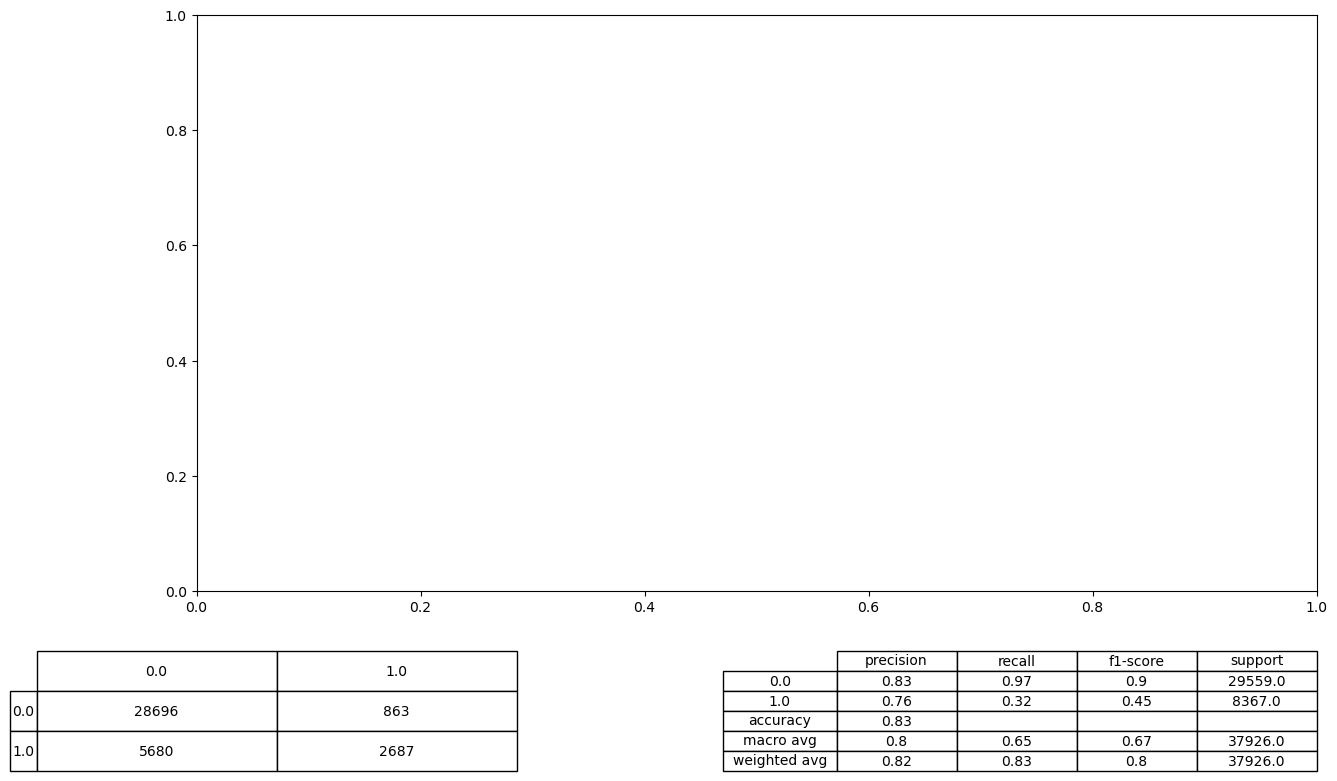

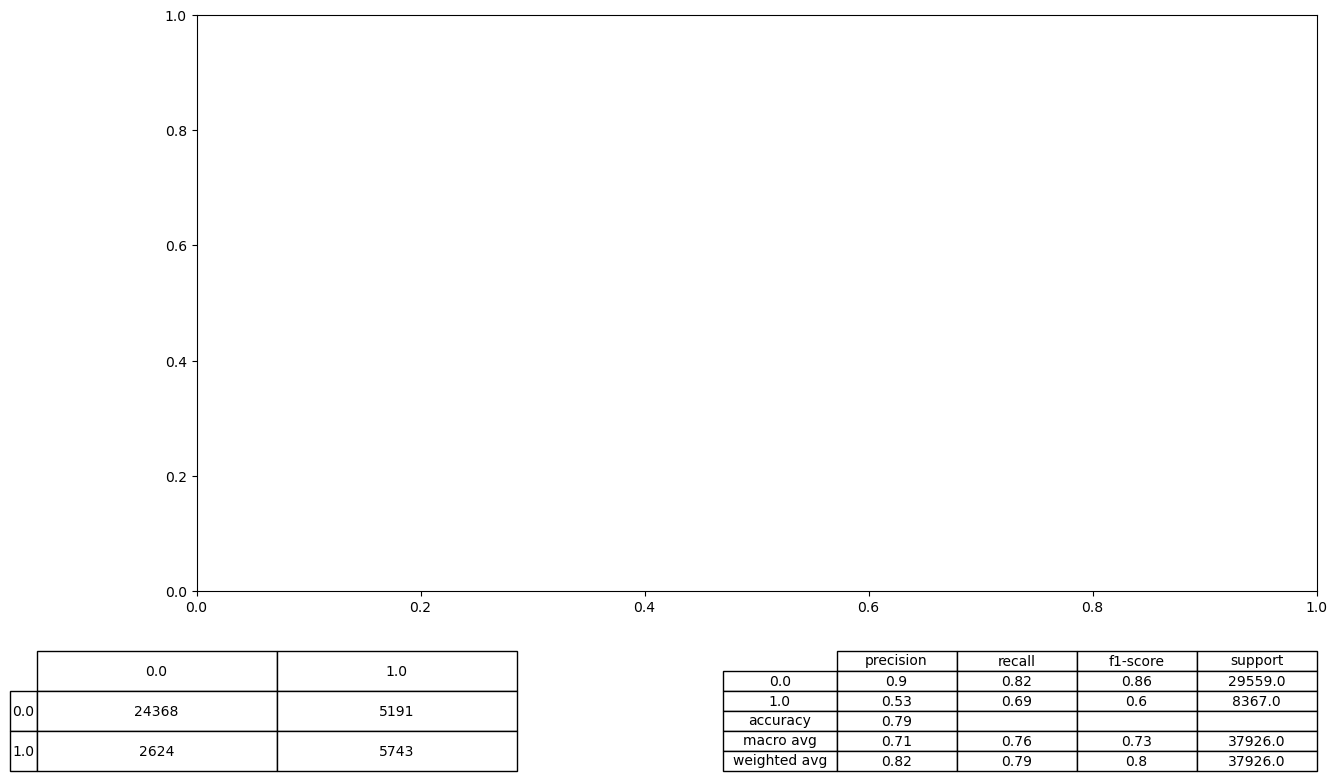

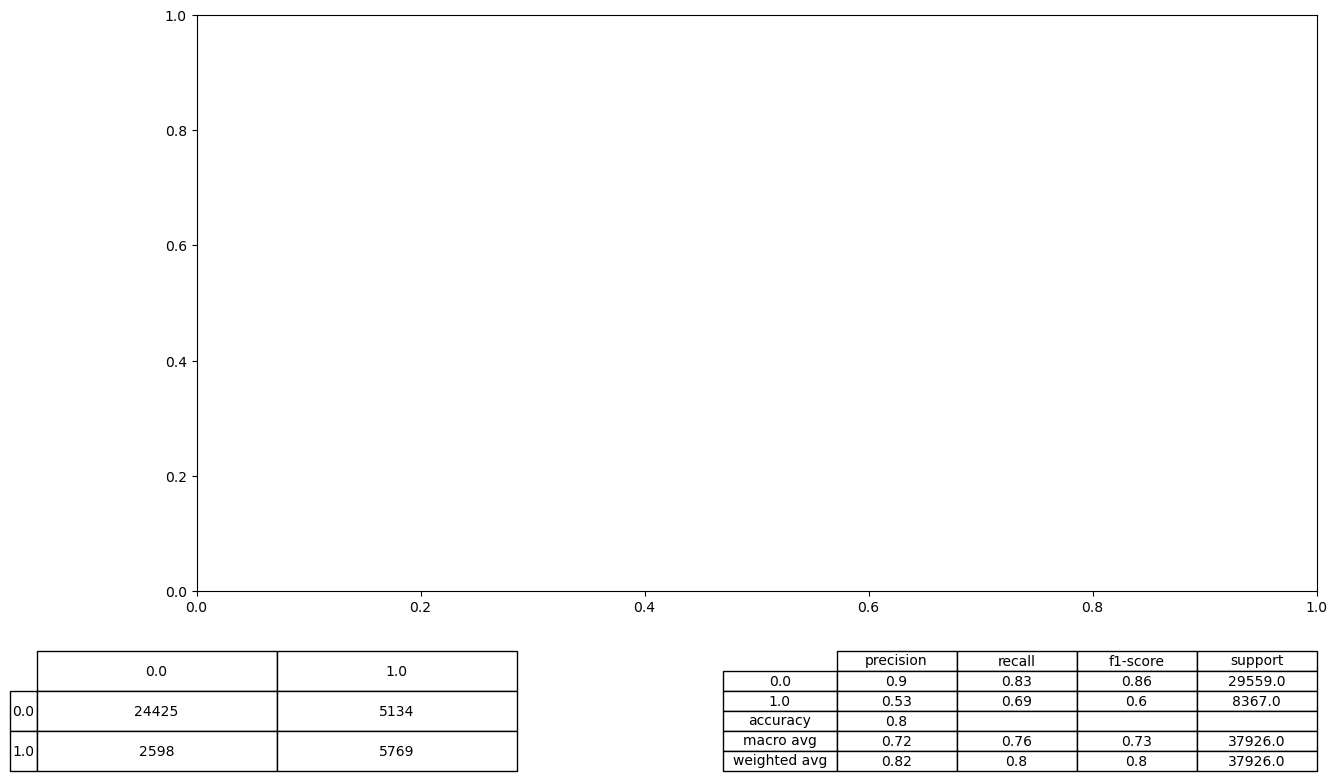

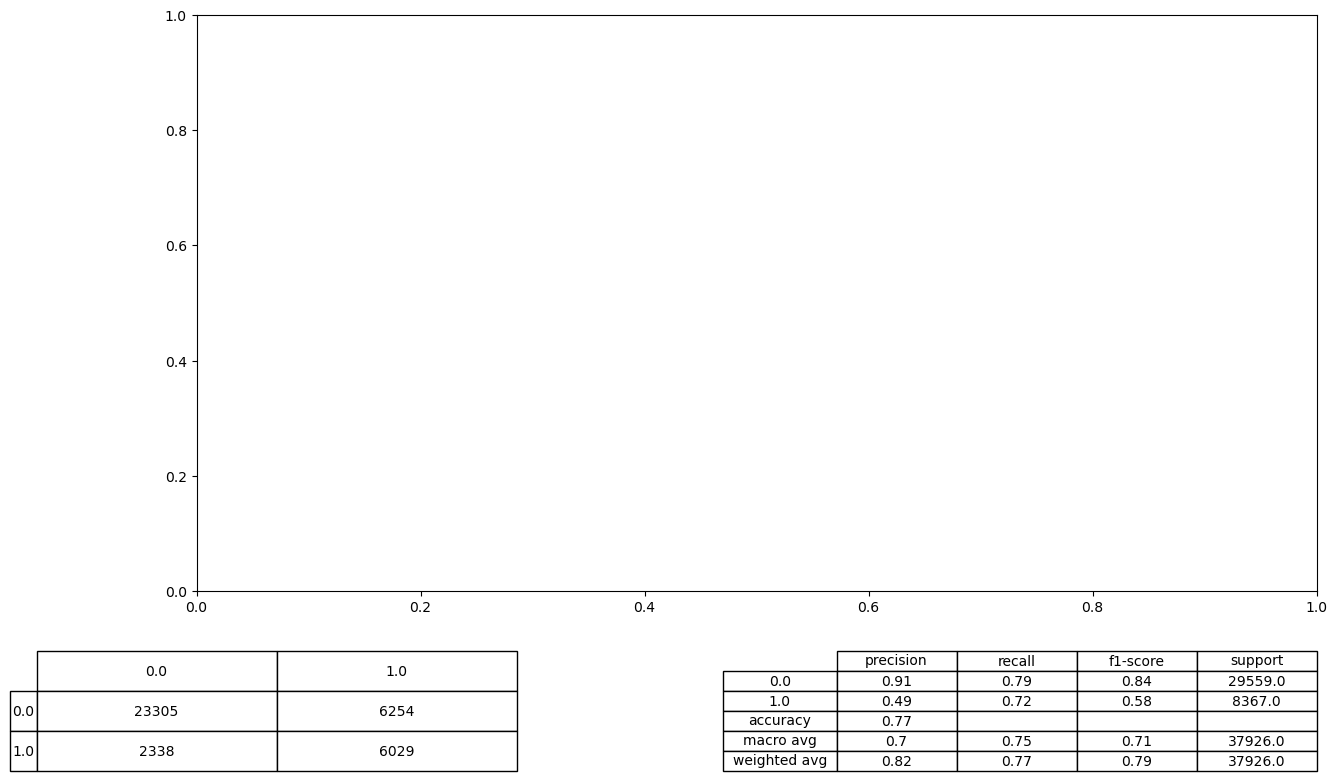

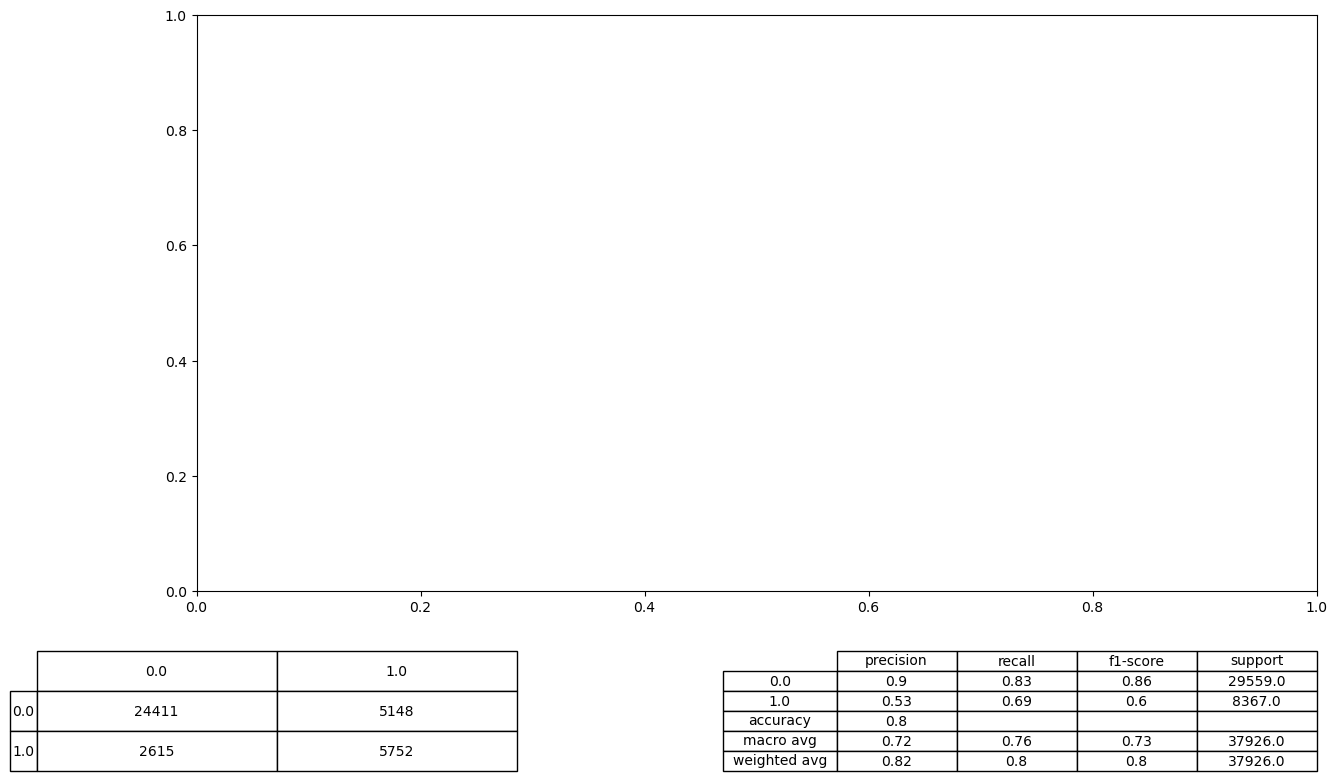

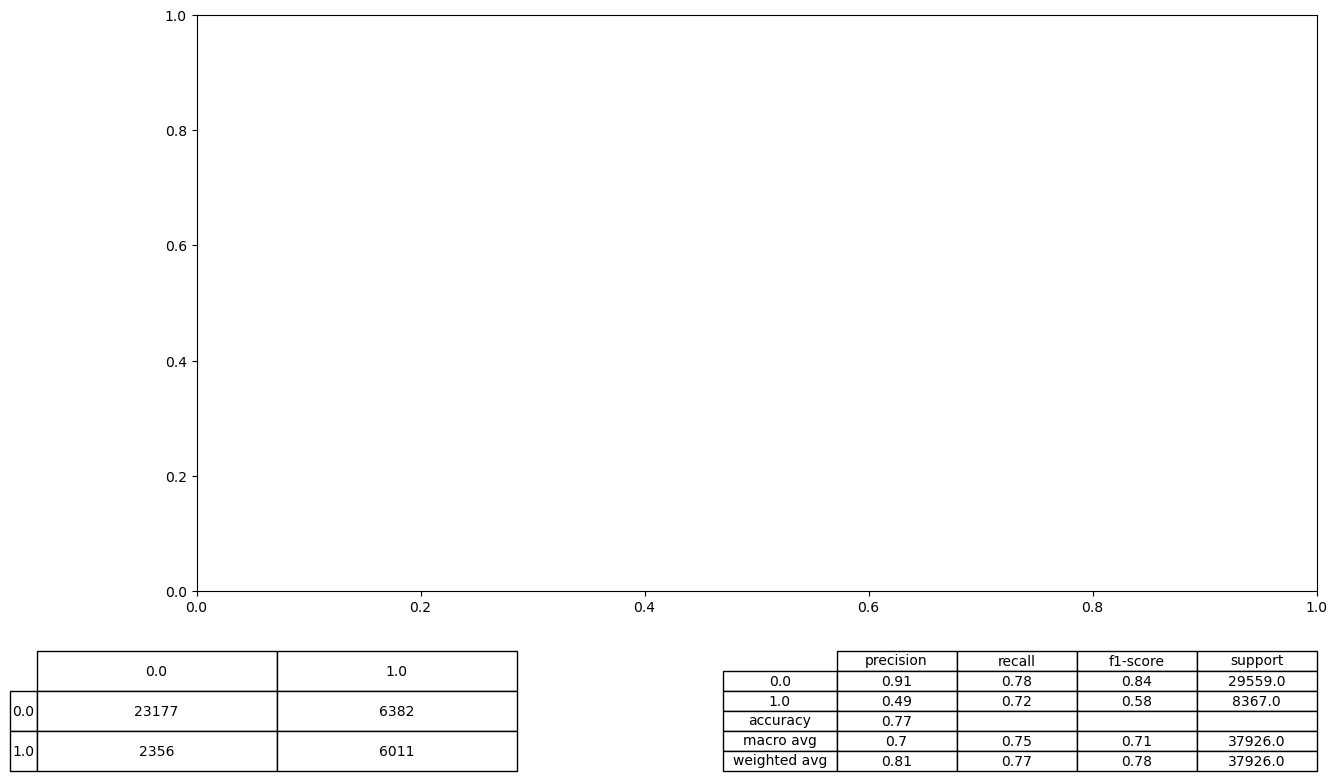

In [15]:
# tuning simple sur V3

model_list ={
    'BaggingClassifier': BaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1)}

dataset = "V3t"
modeling_batch = "simplegrid"
# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f05_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1),
                "f2_score" : make_scorer(fbeta_score, beta=2, pos_label=1)}
variable_cible = "Raintomorrow"
param_grids = param_grids1
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V3t_scaled, X_test_V3t_scaled, y_train_V3t,  y_test_V3t

for model_name, model in model_list.items() : 

    mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                        grid_metrics, variable_cible,
                        X_train_search, X_test_search, y_train_search, 
                        y_test_search, n_coef_graph)

### graph bagging

In [43]:
model_list ={
    'BaggingClassifier': BaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1)}

dataset = "V2t"
modeling_batch = "simplegrid"
variable_cible = "Raintomorrow"
scoring = "accuracy"
model_dir = "../saved_models/global/" + dataset + "/" + modeling_batch + "/" + \
    scoring  + '_BaggingClassifier_tuned' + ".pkl"
            
# charge le modèle
with open(model_dir, 'rb') as m: 
    model = pickle.load(m)


model = BaggingClassifier(n_estimators = 500, 
                          max_samples = 0.5, 
                          max_features = 1.0,
                          n_jobs=-1)
model.fit(X_train_V2t_scaled, y_train_V2t)

BaggingClassifier(max_samples=0.5, n_estimators=500, n_jobs=-1)

[3.41540591e-02 3.01110136e-02 3.85236978e-02 6.46489504e-02
 2.58762289e-02 2.79909968e-02 3.70503333e-02 2.85278352e-01
 3.90673181e-02 6.21266195e-02 3.11546520e-02 3.06696149e-02
 1.59661331e-03 1.18719105e-02 1.19295453e-02 1.67267824e-02
 1.66873344e-02 1.44395368e-02 1.40495195e-02 5.98282956e-03
 5.04815887e-03 1.58882864e-02 2.28202638e-02 1.64050830e-02
 2.06237932e-02 1.68697085e-02 2.05359398e-02 4.47487965e-04
 1.15149955e-03 1.14990533e-03 7.84366469e-04 2.24494767e-04
 2.72629806e-04 1.97969325e-03 3.78240951e-03 4.22729187e-03
 3.91865309e-03 4.14725600e-03 3.59697753e-03 4.13513879e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.80544976e-03
 0.00000000e+00 1.66480239e-03 4.55084234e-04 1.27839233e-03
 1.28091336e-03 1.50374766e-03 1.30229579e-03 6.40340395e-04
 1.41742122e-03 1.04939647e-03 1.36629659e-03 1.11049810e-03
 1.09776125e-04 5.30699112e-04 4.18875516e-04 2.15499524e-04
 9.00482121e-04 1.73321152e-03 1.29287812e-03 8.54107365e-04
 1.19538793e-03 1.404180

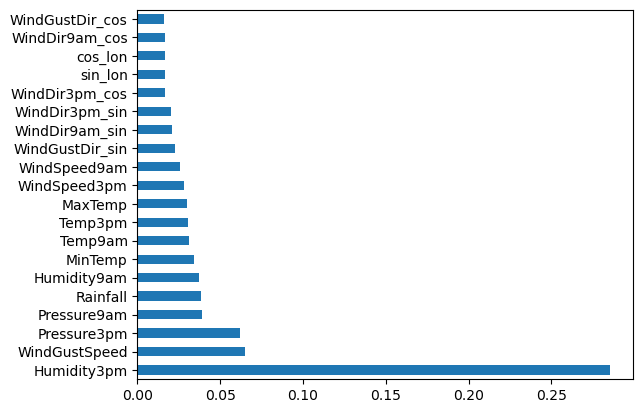

In [49]:
feat_importances = np.mean((
            [tree.feature_importances_ for tree in model.estimators_]),
            axis=0)

print(feat_importances)

feat_importances = pd.Series(feat_importances, index=X_train_V2_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')


print(model.max_features)

## Impact des paramètres de gridsearch (A REVOIR)

In [ ]:
# print(results_search_lr3)
# print(search_lr3.best_estimator_)
# print(search_lr3.best_score_)

# table_results = pd.DataFrame(search_lr3.cv_results_)
# sns.catplot(x = table_results["param_C"], 
#             y = table_results["mean_train_accuracy"], 
#             kind = "bar",
#              hue = table_results["param_solver"], 
#              row = table_results["param_penalty"],
#              col = table_results["param_max_iter"])

# Analyse des observations mal prédites

## Test sur un modèle

In [188]:
# tuning LR basique sur V2
model_name = 'RandomForestClassifier'
dataset = "V2t"
modeling_batch = "simplegrid"
variable_cible = "Raintomorrow"
scoring = "f05_score"

X_train, X_test, y_train,  y_test = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t

model_dir = "../saved_models/global/" + dataset + "/" + modeling_batch + "/" \
    + scoring + "_" + model_name + "_tuned"

# charge le modèle 
with open(model_dir + ".pkl", 'rb') as f:
   model = pickle.load(f)

y_pred = model.predict(X_test)


# crée un df avec les prédictions, les observations et les variables 
pred_df = pd.DataFrame(y_test)
pred_df =  pred_df.rename({"RainTomorrow":"Observations"}, axis = 1)
pred_df["Prédictions"] = y_pred
pred_df = pd.merge(pred_df, X_test, left_index=True, right_index=True)


pred_df["FP"] = 0
pred_df["FN"] = 0

pred_df[(pred_df['Observations'] == 0) & (pred_df['Prédictions'] == 1)] = 1
pred_df[(pred_df['Observations'] == 1) & (pred_df['Prédictions'] == 0)]["FN"] = 1

pred_df["Location"] = pred_df.index.get_level_values(0).values
pred_df["Date"] = pd.to_datetime(pred_df.index.get_level_values(1).values)
pred_df["Year"] = pred_df["Date"].dt.year
pred_df["Month"] = pred_df["Date"].dt.month

# Ajoute autres variables 
import init_data
import preprocess_Date


df_init = init_data.initialize_data_weatherAU(data_dir = "../data/weatherAUS.csv")
df_init = preprocess_Date.preprocess_Date(df_init )


pred_df = pd.merge(pred_df, df_init[["Climate", "Season"]], left_index=True, right_index=True, how = "left")

print(pred_df)

                        Observations  Prédictions  MinTemp  MaxTemp  Rainfall  \
id_Location id_Date                                                             
Albury      2015-01-01          0.00         0.00     0.47     0.72      0.00   
            2015-01-02          0.00         0.00     0.57     0.84      0.00   
            2015-01-03          0.00         0.00     0.60     0.81      0.00   
            2015-01-04          0.00         0.00     0.81     0.71      0.00   
            2015-01-05          0.00         0.00     0.65     0.75      0.00   
...                              ...          ...      ...      ...       ...   
Uluru       2017-06-20          0.00         0.00     0.28     0.50      0.00   
            2017-06-21          0.00         0.00     0.27     0.53      0.00   
            2017-06-22          0.00         0.00     0.29     0.56      0.00   
            2017-06-23          0.00         0.00     0.33     0.59      0.00   
            2017-06-24      

In [189]:
# Fonction pour afficher les FP et FN par variable

def plot_FP_FN(variable, pred_df, graph_dir) : 
    
    os.makedirs(os.path.dirname(graph_dir), exist_ok=True)
    data_plot = pd.DataFrame(
        pred_df.groupby(variable)["FP"].value_counts(normalize=True).reset_index())


    data_plot = data_plot[data_plot["FP"] == 1].sort_values("proportion")
    print(data_plot)

    sns.barplot(data = data_plot , x = variable , y="proportion")
    plt.xticks(rotation=90)
    plt.title("Proportion de faux positifs par " + variable)
    plt.savefig(graph_dir +"_FP_"+variable +".png", bbox_inches="tight")
    plt.show()
    

    data_plot = pd.DataFrame(
        pred_df.groupby(variable)["FN"].value_counts(normalize=True).reset_index())

    data_plot = data_plot[data_plot["FN"] == 1].sort_values("proportion")
    print(data_plot)

    sns.barplot(data = data_plot , x = variable , y="proportion")
    plt.xticks(rotation=90)
    plt.title("Proportion de faux négatifs par "+ variable)
    plt.savefig(graph_dir +"_FN_"+variable +".png", bbox_inches="tight")
    plt.show()

            Location  FP  proportion
79             Uluru   1        0.00
93           Woomera   1        0.01
19             Cobar   1        0.01
1           Adelaide   1        0.01
5       AliceSprings   1        0.01
41             Moree   1        0.01
81        WaggaWagga   1        0.01
39           Mildura   1        0.01
77       Tuggeranong   1        0.02
13          Brisbane   1        0.02
71            Sydney   1        0.02
61             Perth   1        0.02
67          Richmond   1        0.02
31         Katherine   1        0.02
59           Penrith   1        0.02
63      PerthAirport   1        0.02
3             Albury   1        0.02
11           Bendigo   1        0.03
17          Canberra   1        0.03
75        Townsville   1        0.03
57        PearceRAAF   1        0.03
47         Newcastle   1        0.03
55         Nuriootpa   1        0.03
69              Sale   1        0.03
87       Williamtown   1        0.03
23          Dartmoor   1        0.04
4

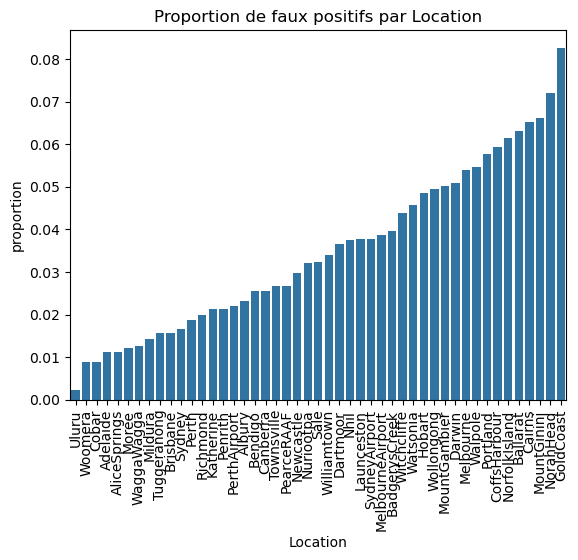

            Location  FN  proportion
79             Uluru   1        0.00
93           Woomera   1        0.01
19             Cobar   1        0.01
1           Adelaide   1        0.01
5       AliceSprings   1        0.01
41             Moree   1        0.01
81        WaggaWagga   1        0.01
39           Mildura   1        0.01
77       Tuggeranong   1        0.02
13          Brisbane   1        0.02
71            Sydney   1        0.02
61             Perth   1        0.02
67          Richmond   1        0.02
31         Katherine   1        0.02
59           Penrith   1        0.02
63      PerthAirport   1        0.02
3             Albury   1        0.02
11           Bendigo   1        0.03
17          Canberra   1        0.03
75        Townsville   1        0.03
57        PearceRAAF   1        0.03
47         Newcastle   1        0.03
55         Nuriootpa   1        0.03
69              Sale   1        0.03
87       Williamtown   1        0.03
23          Dartmoor   1        0.04
4

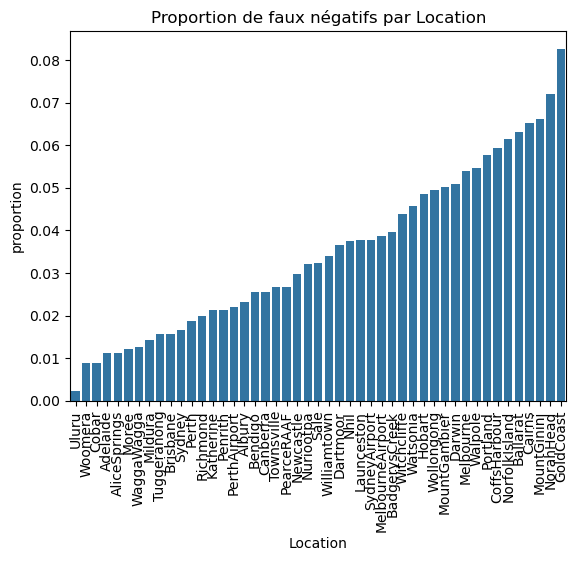

   Year  FP  proportion
1  2015   1        0.03
5  2017   1        0.03
3  2016   1        0.04


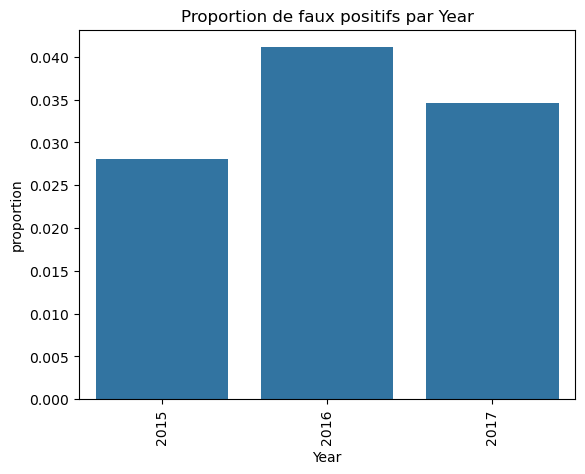

   Year  FN  proportion
1  2015   1        0.03
5  2017   1        0.03
3  2016   1        0.04


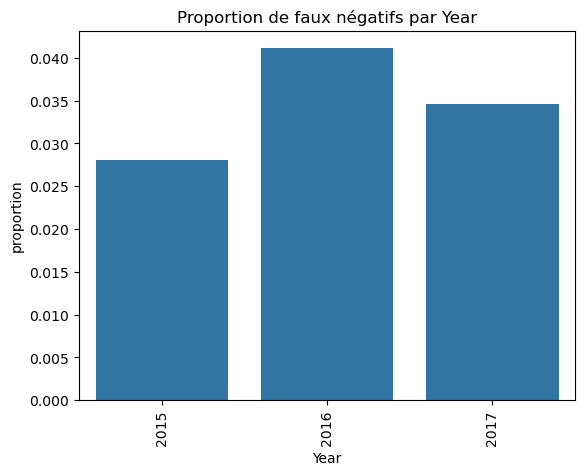

    Month  FP  proportion
7       4   1        0.02
23     12   1        0.02
21     11   1        0.03
3       2   1        0.03
19     10   1        0.03
15      8   1        0.03
17      9   1        0.03
5       3   1        0.03
1       1   1        0.04
9       5   1        0.04
13      7   1        0.05
11      6   1        0.05


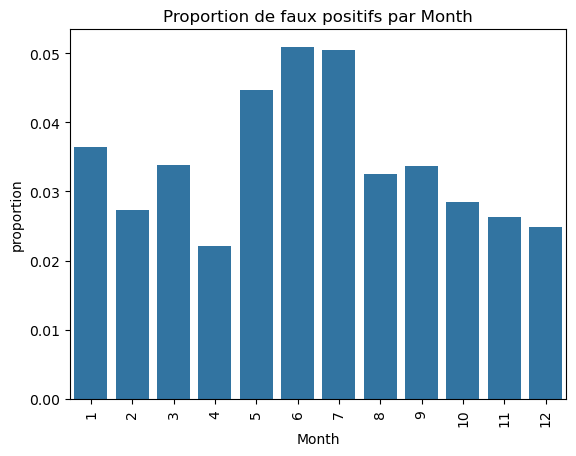

    Month  FN  proportion
7       4   1        0.02
23     12   1        0.02
21     11   1        0.03
3       2   1        0.03
19     10   1        0.03
15      8   1        0.03
17      9   1        0.03
5       3   1        0.03
1       1   1        0.04
9       5   1        0.04
13      7   1        0.05
11      6   1        0.05


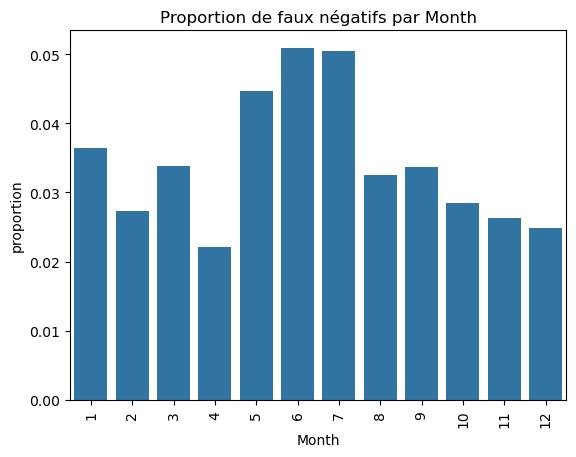

       Climate  FP  proportion
1       Desert   1        0.01
3    Grassland   1        0.01
5  Subtropical   1        0.04
7    Temperate   1        0.04
9     Tropical   1        0.04


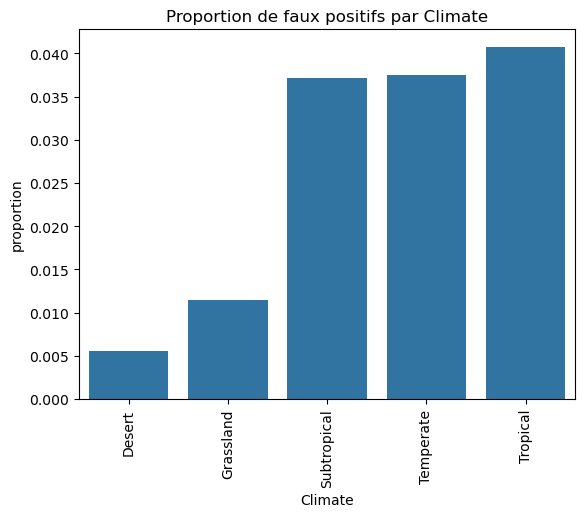

       Climate  FN  proportion
1       Desert   1        0.01
3    Grassland   1        0.01
5  Subtropical   1        0.04
7    Temperate   1        0.04
9     Tropical   1        0.04


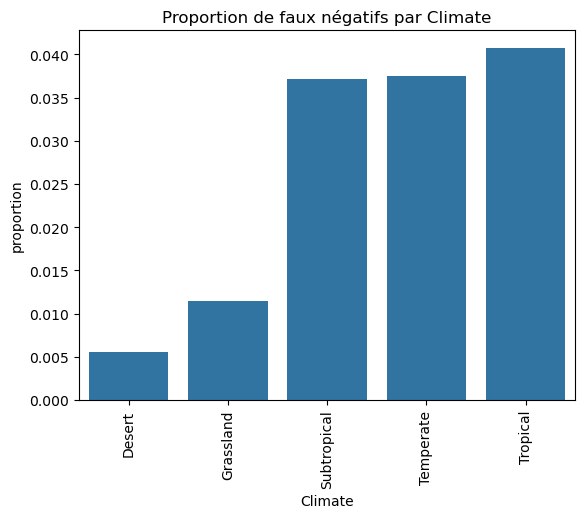

   Season  FP  proportion
3  Spring   1        0.03
5  Summer   1        0.03
1  Autumn   1        0.04
7  Winter   1        0.04


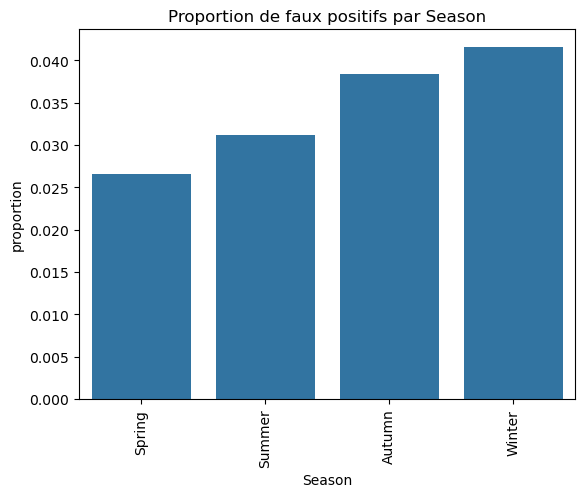

   Season  FN  proportion
3  Spring   1        0.03
5  Summer   1        0.03
1  Autumn   1        0.04
7  Winter   1        0.04


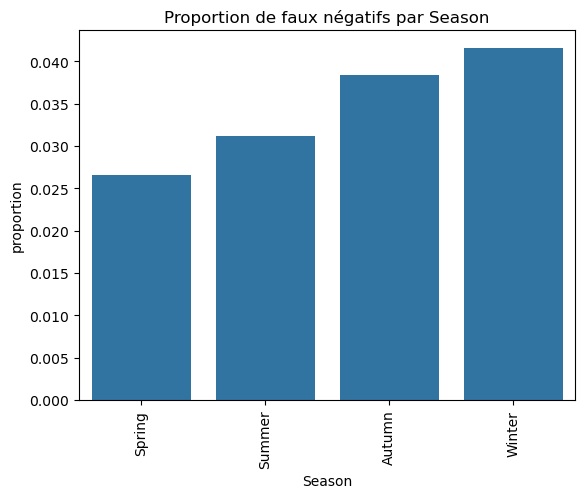

In [190]:
graph_dir = "../plots/rapport/plot_FP_FN/global/" + dataset + "/" + modeling_batch + "/" \
    + scoring + "_" + model_name + "_tuned"


plot_FP_FN("Location",pred_df,graph_dir)
plot_FP_FN("Year",pred_df,graph_dir)
plot_FP_FN("Month",pred_df,graph_dir)
plot_FP_FN("Climate",pred_df,graph_dir)
plot_FP_FN("Season",pred_df,graph_dir)


   FP  Climate_Tropical  proportion
2   1              1.00        1.00


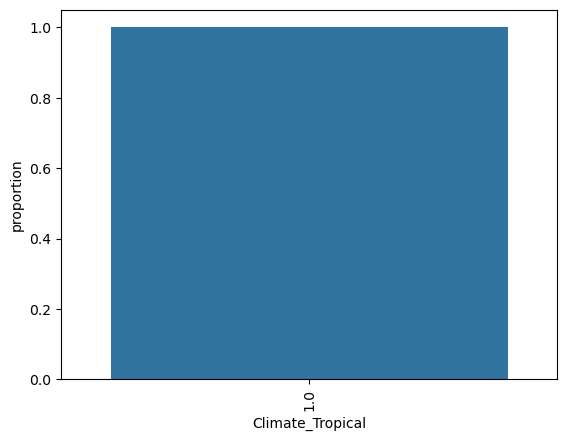

   FN  Climate_Tropical  proportion
2   1              1.00        1.00


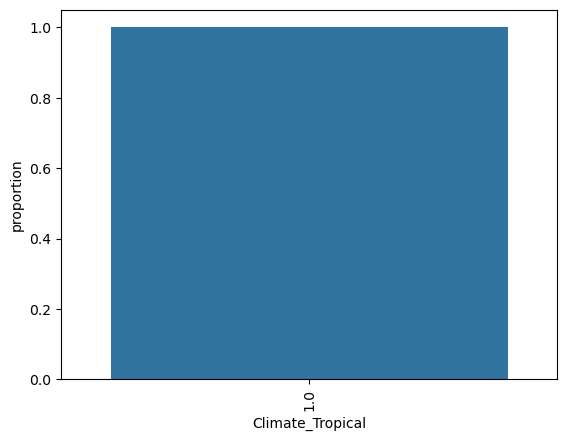

In [143]:
plot_FP_FN("Month",pred_df)

# Seuil de classification

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(41413, 2)
Best Threshold=0.024537, F-Score=0.000
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
Seuil :  0.27100106686966813
Avant ajustement : 
score accuracy :  0.8478738560355444
f1 score :  0.5903771131339401
roc-auc score :  0.7215511408155196
[[30573  1662]
 [ 4638  4540]] 


              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     32235
         1.0       0.73      0.49      0.59      9178

    accuracy                           0.85     41413
   macro avg       0.80      0.72      0.75     41413
weighted avg       0.84      0.85      0.84     41413

0.7320219284101903
0.49466114621921986
après ajustement : 
score accuracy :  0.8478738560355444
f1 score :  0.6081794195250659
roc-auc score :  0.7736138420578907
[[25588  6647]
 [ 2263  6915]] 


              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85     32235
         1.0       0.51      0.75      0.61   

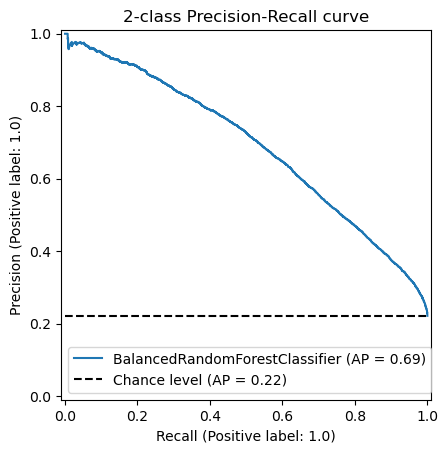

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

model_name = 'BalancedRandomForestClassifier'
dataset = "V2t"
modeling_batch = "simplegrid"
variable_cible = "Raintomorrow"
scoring = "f05_score"

X_train, X_test, y_train,  y_test = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t

model_dir = "../saved_models/global/" + dataset + "/" + modeling_batch + "/" \
    + scoring + "_" + model_name + "_tuned"

# charge le modèle 
with open(model_dir + ".pkl", 'rb') as f:
   model = pickle.load(f)


model.fit(X_train, y_train)
preds = model.predict_proba(X_test)
y_pred = model.predict(X_test)

print(np.array(y_test).reshape(-1,1))
print(preds.shape)
# calculate pr curve
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1], pos_label='1')

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))


from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
   model, X_test, y_test, name=model_name, plot_chance_level=True)
_ = display.ax_.set_title("2-class Precision-Recall curve")


fpr, tpr, thresholds = roc_curve( y_test, preds[:,1])
roc_auc = roc_auc_score(y_test, preds[:,1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred2 = (preds[:,1] > optimal_threshold).astype(int)


print("Seuil : ", optimal_threshold)

print("Avant ajustement : ")
print('score accuracy : ', model.score(X_test, y_test))
print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred), '\n\n')
print(classification_report(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

print("après ajustement : ")
print('score accuracy : ', model.score(X_test, y_test))
print('f1 score : ', f1_score(y_test, y_pred2))
print('roc-auc score : ', roc_auc_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2), '\n\n')
print(classification_report(y_test, y_pred2))
print(precision_score(y_test, y_pred2))
print(recall_score(y_test, y_pred2))


[[0.91038034 0.08961966]
 [0.86485569 0.13514431]
 [0.91077942 0.08922058]
 ...
 [0.93882323 0.06117677]
 [0.92219322 0.07780678]
 [0.95458245 0.04541755]]


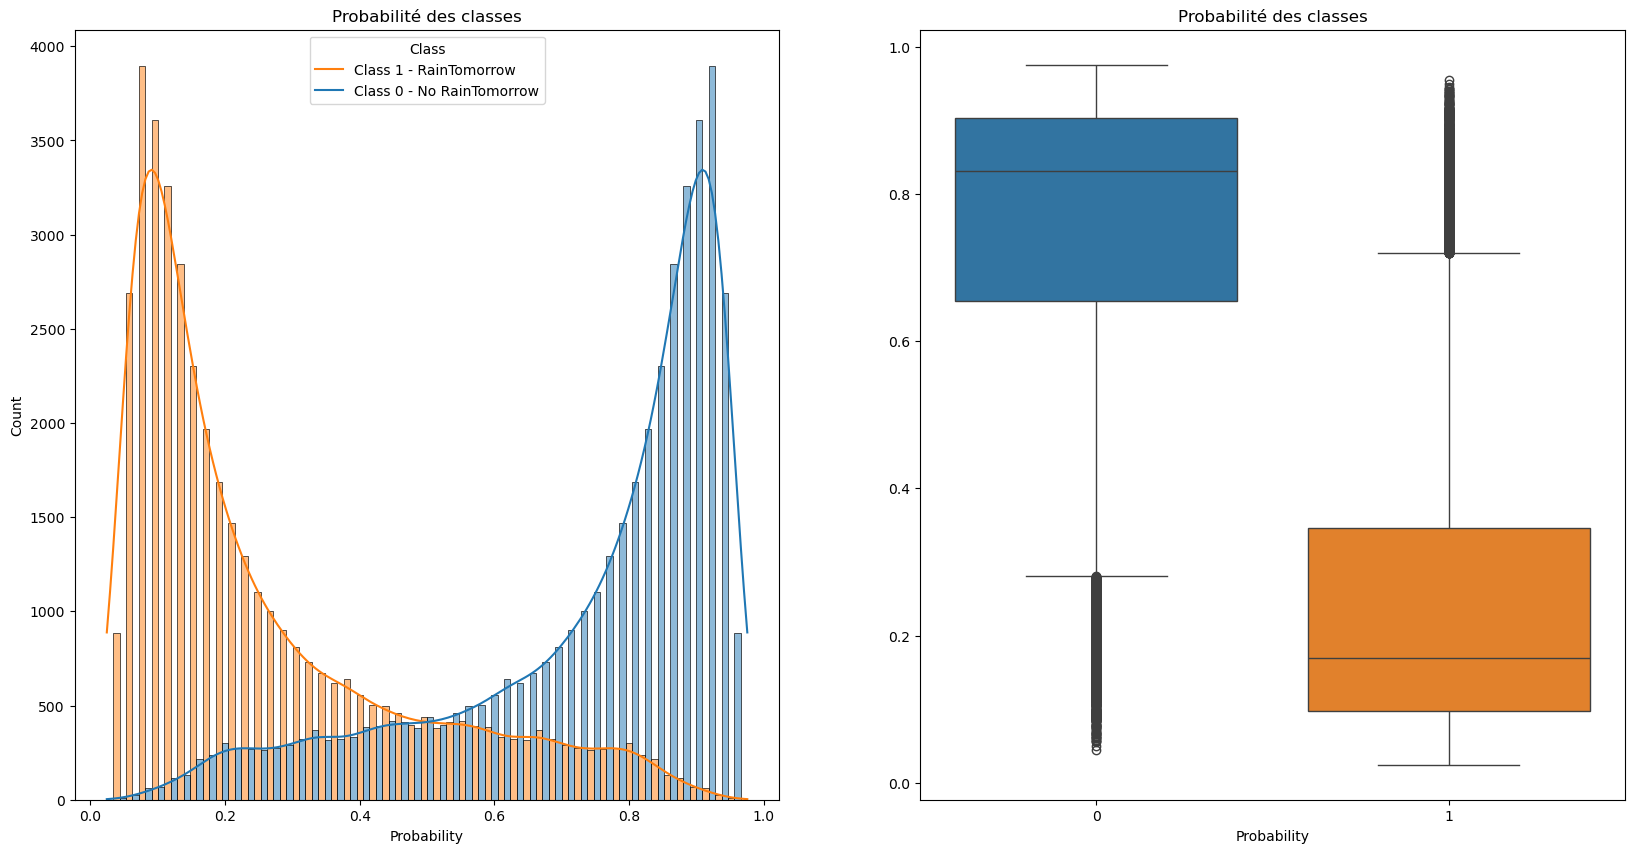

In [17]:
print(preds)

plt.figure(figsize = (20, 10))
plt.subplot(121)
sns.histplot(preds, bins = 50, kde = True,
             stat = 'count', multiple = 'dodge',
             color = ['yellow', 'blue'])
plt.xlabel('Probability')
plt.legend(title='Class', labels=['Class 1 - RainTomorrow', 'Class 0 - No RainTomorrow'], loc='upper center')
plt.title(f'Probabilité des classes')

plt.subplot(122)
sns.boxplot(preds)
plt.xlabel('Probability')
plt.title(f'Probabilité des classes')
plt.show()
plt.show()